### gears (other dl models) replication

In [1]:
import json
import os
import sys
import time
import copy
from pathlib import Path
from typing import Iterable, List, Tuple, Dict, Union, Optional
import warnings

import torch
import numpy as np
import matplotlib
from torch import nn
from torch.nn import functional as F


In [2]:
!pip list | grep torchaudio

torchaudio         2.5.1


In [5]:

from gears import PertData, GEARS
from gears.inference import compute_metrics, deeper_analysis, non_dropout_analysis
from gears.utils import create_cell_graph_dataset_for_prediction

In [14]:
# !pip install scanpy

In [4]:
import scanpy as sc

In [5]:
replogle = sc.read_h5ad('/hpc/group/yizhanglab/vk93/contrastiveVI/contrastive_vi_plus/notebooks/notebooks_pre_11_9/replogle_merged.h5ad')
replogle

AnnData object with n_obs × n_vars = 191969 × 1187
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'dataset'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano'

In [6]:
# gene should be called condition
# condition, cell_type in adata.obs
# so cell_type should just be k562
# make new h5ad with just var "gene_name existing" 
# so total --> obs has condition cell_type and var has gene_name
# call it gears replogle


import scanpy as sc
import anndata as ad

# path to your original file (change if needed)
in_path = '/hpc/group/yizhanglab/vk93/contrastiveVI/contrastive_vi_plus/notebooks/notebooks_pre_11_9/replogle_merged.h5ad'

# load
adata = sc.read_h5ad(in_path)
print("Loaded AnnData:", adata)

# 1) rename obs column 'gene' -> 'condition' (if it exists)
if 'gene' in adata.obs.columns:
    adata.obs = adata.obs.copy()  # avoid SettingWithCopy issues
    adata.obs = adata.obs.rename(columns={'gene': 'condition'})
    print("Renamed obs['gene'] -> obs['condition']")
else:
    raise KeyError("Input AnnData.obs does not contain a column named 'gene'")

# 2) ensure obs contains exactly 'condition' and 'cell_type'
# keep condition (created above), add cell_type = 'k562'
if 'condition' not in adata.obs.columns:
    raise KeyError("After renaming, 'condition' not found in adata.obs")

adata.obs['cell_type'] = 'k562'

# Keep only the two columns requested (but preserve the index)
adata.obs = adata.obs[['condition', 'cell_type']].copy()
print("adata.obs now has columns:", list(adata.obs.columns))

# 3) reduce var to only the 'gene_name' column (preserve index)
if 'gene_name' not in adata.var.columns:
    raise KeyError("adata.var does not contain 'gene_name' — check your file")

new_var = adata.var[['gene_name']].copy()

# Optionally: if you want gene_name to be the var_names (index), uncomment:
# new_var.index = new_var['gene_name'].astype(str)
# new_var = new_var[~new_var.index.duplicated()]  # remove duplicates if any (optional)
# if you change index you must also subset adata.X accordingly:
# adata = adata[:, new_var.index].copy()

# Replace var with the slimmed version (keep the original var index unless you changed it above)
adata.var = new_var
print("adata.var columns:", list(adata.var.columns))




Loaded AnnData: AnnData object with n_obs × n_vars = 191969 × 1187
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'dataset'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano'
Renamed obs['gene'] -> obs['condition']
adata.obs now has columns: ['condition', 'cell_type']
adata.var columns: ['gene_name']


In [7]:
adata.obs['condition'] = adata.obs['condition'].replace('non-targeting', 'ctrl')


In [8]:
adata.obs['condition'] = adata.obs['condition'].astype(str).apply(lambda x: x.strip() if '+' in x or x.strip().lower() == 'ctrl' else f"{x.strip()}+ctrl")


In [11]:
# out_path = '/hpc/group/yizhanglab/vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/gears_replogle.h5ad'


# # 4) Save new h5ad
# adata.write_h5ad(out_path)
# print(f"Saved new AnnData to: {out_path}")

In [13]:
pert_data = PertData('./data')


Found local copy...


In [14]:
import scipy.sparse as sp

if isinstance(adata.X, np.ndarray):
    adata.X = sp.csr_matrix(adata.X)

# get data
pert_data.new_data_process(dataset_name = 'replogle', adata = adata)
# to load the processed data
pert_data.load(data_path = './data/replogle')

Found local copy...
Creating pyg object for each cell in the data...
Creating dataset file...
  6%|▌         | 42/682 [00:17<06:05,  1.75it/s]

NEDD8-MDP1+ctrl


 17%|█▋        | 119/682 [00:47<02:08,  4.37it/s]

C7orf26+ctrl


 23%|██▎       | 159/682 [01:01<02:33,  3.40it/s]

RBM14-RBM4+ctrl


 49%|████▉     | 337/682 [01:57<01:12,  4.73it/s]

ST20-MTHFS+ctrl


 55%|█████▍    | 374/682 [02:10<01:44,  2.93it/s]

AC118549.1+ctrl


 74%|███████▎  | 502/682 [02:45<00:35,  5.14it/s]

RPS10-NUDT3+ctrl


100%|██████████| 682/682 [03:28<00:00,  3.27it/s]
Done!
Saving new dataset pyg object at ./data/replogle/data_pyg/cell_graphs.pkl
Done!
Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['NEDD8-MDP1+ctrl' 'C7orf26+ctrl' 'RBM14-RBM4+ctrl' 'ST20-MTHFS+ctrl'
 'AC118549.1+ctrl' 'RPS10-NUDT3+ctrl']
Local copy of pyg dataset is detected. Loading...
Done!


In [15]:
norman = sc.read_h5ad('/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/data/norman/perturb_processed.h5ad')

In [16]:
norman.obs

,condition,cell_type,dose_val,control,condition_name
cell_barcode,,,,,
AAACCTGAGGCATGTG-1,TSC22D1+ctrl,A549,1+1,0,A549_TSC22D1+ctrl_1+1
AAACCTGAGGCCCTTG-1,KLF1+MAP2K6,A549,1+1,0,A549_KLF1+MAP2K6_1+1
AAACCTGCACGAAGCA-1,ctrl,A549,1,1,A549_ctrl_1
AAACCTGCAGACGTAG-1,CEBPE+RUNX1T1,A549,1+1,0,A549_CEBPE+RUNX1T1_1+1
AAACCTGCAGCCTTGG-1,MAML2+ctrl,A549,1+1,0,A549_MAML2+ctrl_1+1
...,...,...,...,...,...
TTTGTCAGTCATGCAT-8,RHOXF2BB+SET,A549,1+1,0,A549_RHOXF2BB+SET_1+1
TTTGTCATCAGTACGT-8,FOXA3+ctrl,A549,1+1,0,A549_FOXA3+ctrl_1+1
TTTGTCATCCACTCCA-8,CELF2+ctrl,A549,1+1,0,A549_CELF2+ctrl_1+1


In [17]:
replogle_gears = sc.read_h5ad('/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/data/replogle/perturb_processed.h5ad')
replogle_gears.obs

,condition,cell_type,dose_val,control,condition_name
cell_barcode,,,,,
AAACCCAAGAACAGGA-209-replogle_ref,DHX33+ctrl,k562,1+1,0,k562_DHX33+ctrl_1+1
AAACCCAAGAAGCTCG-12-replogle_ref,UPF2+ctrl,k562,1+1,0,k562_UPF2+ctrl_1+1
AAACCCAAGAAGGTAG-137-replogle_ref,GPS1+ctrl,k562,1+1,0,k562_GPS1+ctrl_1+1
AAACCCAAGACAACAT-110-replogle_ref,INO80B+ctrl,k562,1+1,0,k562_INO80B+ctrl_1+1
AAACCCAAGAGCATAT-255-replogle_ref,LTV1+ctrl,k562,1+1,0,k562_LTV1+ctrl_1+1
...,...,...,...,...,...
TTTGTTGTCGTTCTCG-197-replogle_ntc,ctrl,k562,1,1,k562_ctrl_1
TTTGTTGTCTCATTAC-91-replogle_ntc,ctrl,k562,1,1,k562_ctrl_1
TTTGTTGTCTCCAAGA-253-replogle_ntc,ctrl,k562,1,1,k562_ctrl_1


In [18]:
# specify data split
pert_data.prepare_split(split = 'simulation', seed = 1)
# get dataloader with batch size
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128)



Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:169
Done!
Creating dataloaders....
Done!


here1


In [24]:
import scipy.sparse as sp


In [30]:
# ## make dense here for series operations (pandas)
# pert_data.adata.X = pert_data.adata.X.toarray() if hasattr(pert_data.adata.X, "toarray") else pert_data.adata.X


In [35]:
print(type(pert_data.adata.X))
print(hasattr(pert_data.adata.X, "toarray"))
print(type(pert_data.adata), hasattr(pert_data, "adata"))
print(type(pert_data.adata.obs['condition']), type(pert_data.adata.obs['condition'].values))


<class 'anndata._core.views.SparseCSRMatrixView'>
True
<class 'anndata._core.anndata.AnnData'> True
<class 'pandas.core.series.Series'> <class 'pandas.core.arrays.categorical.Categorical'>


In [36]:
import numpy as np

# 1) materialize the AnnData (get rid of view)
pert_data.adata = pert_data.adata.copy()

# 2) force X to be a dense numpy array
if hasattr(pert_data.adata.X, "toarray"):
    pert_data.adata.X = pert_data.adata.X.toarray()
else:
    # fallback (ensures ndarray)
    pert_data.adata.X = np.asarray(pert_data.adata.X)

# 3) make condition plain strings (object dtype) so boolean masks are numpy ndarrays
pert_data.adata.obs['condition'] = pert_data.adata.obs['condition'].astype(str)


In [27]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 144405333 stored elements and shape (191969, 1187)>

In [ ]:
# /hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/gears/utils.py


In [37]:
pert_data.adata.X

array([[  2.,   0.,   7., ...,  11.,   2.,  94.],
       [  0.,   0.,   2., ...,  18.,   7.,  75.],
       [  1.,   0.,   4., ...,  16.,   4.,  63.],
       ...,
       [  0.,   1.,   1., ...,  22.,   5., 154.],
       [  0.,   1.,  15., ...,  32.,   5., 129.],
       [  0.,   0.,   6., ...,  21.,   3.,  76.]],
      shape=(190763, 1187), dtype=float32)

In [38]:
# set up and train a model
gears_model = GEARS(pert_data, device = 'cuda:0')



In [ ]:
# ## make csr
# pert_data.adata.X = sp.csr_matrix(pert_data.adata.X)


In [ ]:
gears_model.model_initialize(hidden_size = 64)
gears_model.train(epochs = 20)

Epoch 20: Train Overall MSE: 4.1392 Validation Overall MSE: 9.5908. 
Train Top 20 DE MSE: 81.8165 Validation Top 20 DE MSE: 179.4204. 
Done!
Start Testing...
Best performing model: Test Top 20 DE MSE: 216.7941

In [49]:
state = gears_model.model.state_dict()
print("Example weight mean:", next(iter(state.values())).mean().item())


Example weight mean: 0.00016699827392585576


In [44]:

# save/load model
gears_model.save_model('gears_replogle')
gears_model.load_pretrained('gears_replogle')

In [48]:
state = gears_model.model.state_dict()
print("Example weight mean:", next(iter(state.values())).mean().item())


Example weight mean: 0.00016699827392585576


### replogle for scgpt

In [2]:

from gears import PertData, GEARS
from gears.inference import compute_metrics, deeper_analysis, non_dropout_analysis
from gears.utils import create_cell_graph_dataset_for_prediction

/hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import scanpy as sc
import anndata as ad

In [106]:
# !curl -L -o K562_gwps_raw_singlecell_01.h5ad "https://ndownloader.figshare.com/files/35775507"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 61.3G  100 61.3G    0     0  20.9M      0  0:50:03  0:50:03 --:--:-- 20.8M 1:10:33 17.8M  0:48:54 21.0M6424M    0     0  20.6M      0  0:50:33  0:05:10  0:45:23 21.0M0:44:08 21.0M   0  20.7M      0  0:50:19  0:07:21  0:42:58 21.0M    0  0:50:16  0:08:10  0:42:06 21.0M  20.8M      0  0:50:11  0:09:34  0:40:37 21.0M0.8M      0  0:50:11  0:09:44  0:40:27 21.0M      0  0:50:05  0:12:25  0:37:40 21.0MM      0  0:50:04  0:13:25  0:36:39 21.0M8M      0  0:50:06  0:18:13  0:31:53 20.8M2  0:28:26 20.8M25:44 20.9M 20.8M      0  0:50:05  0:25:23  0:24:42 20.9M9M8M      0  0:50:04  0:26:33  0:23:31 20.9M    0  0:50:04  0:27:44  0:22:20 20.9M      0  0:50:04  0:28:41  0:21:23 20.9M  0  20.9M      0  0:50:03  0:29:11  0:20:52 20.9M  0:20:34 20.9M1:34  0:18:29 20.

In [4]:
import anndata as ad
import pandas as pd

adata = ad.read_h5ad("K562_gwps_raw_singlecell_01.h5ad")

print("Shape (cells × genes):", adata.shape)
print("\nObservations (adata.obs) columns:\n", adata.obs.columns.tolist())
print("\nVariables (adata.var) columns:\n", adata.var.columns.tolist())
print("\nFirst few obs rows:")
print(adata.obs.head())

print(adata.var.head())

if 'perturbation' in adata.obs.columns:
    print("\nTop perturbations:")
    print(adata.obs['perturbation'].value_counts().head())

print("\nX matrix info:")
print(adata.X)



Shape (cells × genes): (1989578, 8248)

Observations (adata.obs) columns:
 ['gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count']

Variables (adata.var) columns:
 ['gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano']

First few obs rows:
                      gem_group  ... core_adjusted_UMI_count
cell_barcode                     ...                        
AAACCCAAGAAACCAT-157        157  ...            13992.900391
AAACCCAAGAAACCAT-207        207  ...            15038.004883
AAACCCAAGAAACCAT-29          29  ...            22613.423828
AAACCCAAGAAAGCGA-149        149  ...            15476.669922
AAACCCAAGAAATCCA-172        172  ...            11147.856445

[5 rows x 11 columns]
                 gene_name   chr   start  ...       std        cv      fano
gene_id                                   ...                     

In [5]:
adata

AnnData object with n_obs × n_vars = 1989578 × 8248
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano'

In [6]:
rg = sc.read_h5ad('/hpc/group/yizhanglab/vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/gears_replogle.h5ad')

In [8]:
import scipy.sparse as sp


In [9]:
X = rg.X

# Convert to 1D nonzero values
if sp.issparse(X):
    nonzero_vals = X.data  # Sparse format stores only nonzero values
else:
    nonzero_vals = X[X != 0].ravel()

# Take first 10 nonzero entries
first10 = nonzero_vals[:10]

# Check which are integers
are_integers = np.isclose(first10, np.round(first10))

# Show results
for i, val in enumerate(first10):
    print(f"{i+1}: {val} -> integer? {are_integers[i]}")

# Optional summary
print("\nAll integers:", np.all(are_integers))

1: 2.0 -> integer? True
2: 7.0 -> integer? True
3: 18.0 -> integer? True
4: 8.0 -> integer? True
5: 1.0 -> integer? True
6: 1.0 -> integer? True
7: 2.0 -> integer? True
8: 5.0 -> integer? True
9: 3.0 -> integer? True
10: 3.0 -> integer? True

All integers: True


In [10]:
rg

AnnData object with n_obs × n_vars = 191969 × 1187
    obs: 'condition', 'cell_type'
    var: 'gene_name'

In [13]:
adata.obs

,gem_group,gene,gene_id,transcript,gene_transcript,sgID_AB,mitopercent,UMI_count,z_gemgroup_UMI,core_scale_factor,core_adjusted_UMI_count
cell_barcode,,,,,,,,,,,
AAACCCAAGAAACCAT-157,157,CTSC,ENSG00000109861,P1P2,1946_CTSC_P1P2_ENSG00000109861,CTSC_-_88070848.23-P1P2|CTSC_-_88070918.23-P1P2,0.088177,14709.0,0.470687,1.051176,13992.900391
AAACCCAAGAAACCAT-207,207,CWC25,ENSG00000273559,P1P2,1973_CWC25_P1P2_ENSG00000273559,CWC25_+_36981555.23-P1P2|CWC25_+_36981567.23-P1P2,0.114342,16162.0,0.824790,1.074744,15038.004883
AAACCCAAGAAACCAT-29,29,PDE4DIP,ENSG00000178104,ENST00000313431.9,6168_PDE4DIP_ENST00000313431.9_ENSG00000178104,PDE4DIP_+_144932474.23-ENST00000313431.9|PDE4D...,0.107157,33297.0,2.627126,1.472444,22613.423828
AAACCCAAGAAAGCGA-149,149,ZZEF1,ENSG00000074755,P1P2,10745_ZZEF1_P1P2_ENSG00000074755,ZZEF1_+_4046247.23-P1P2|ZZEF1_+_4046255.23-P1P2,0.143107,7435.0,0.918149,0.480401,15476.669922
AAACCCAAGAAATCCA-172,172,SNAPIN,ENSG00000143553,P1P2,8210_SNAPIN_P1P2_ENSG00000143553,SNAPIN_+_153631238.23-P1P2|SNAPIN_-_153631252....,0.130754,7755.0,-0.230920,0.695649,11147.856445
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCTTTCCAA-201,201,SCRIB,ENSG00000180900,P1P2,7706_SCRIB_P1P2_ENSG00000180900,SCRIB_-_144897465.23-P1P2|SCRIB_-_144897339.23...,0.115868,11867.0,-0.441665,1.151834,10302.698242
TTTGTTGTCTTTCGAT-79,79,CADM4,ENSG00000105767,P1P2,1151_CADM4_P1P2_ENSG00000105767,CADM4_+_44143915.23-P1P2|CADM4_+_44143932.23-P1P2,0.094454,6437.0,-1.208969,0.935249,6882.660156
TTTGTTGTCTTTCTAG-218,218,SLC4A7,ENSG00000033867,P1P2,8098_SLC4A7_P1P2_ENSG00000033867,SLC4A7_+_27525847.23-P1P2|SLC4A7_+_27525631.23...,0.170080,11377.0,-0.109167,1.000028,11376.682617


In [14]:
# gene should be called condition
# condition, cell_type in adata.obs
# so cell_type should just be k562
# make new h5ad with just var "gene_name existing" 
# so total --> obs has condition cell_type and var has gene_name
# call it gears replogle


import scanpy as sc
import anndata as ad

print("Loaded AnnData:", adata)

# 1) rename obs column 'gene' -> 'condition' (if it exists)
if 'gene' in adata.obs.columns:
    adata.obs = adata.obs.copy()  # avoid SettingWithCopy issues
    adata.obs = adata.obs.rename(columns={'gene': 'condition'})
    print("Renamed obs['gene'] -> obs['condition']")
else:
    raise KeyError("Input AnnData.obs does not contain a column named 'gene'")

# 2) ensure obs contains exactly 'condition' and 'cell_type'
# keep condition (created above), add cell_type = 'k562'
if 'condition' not in adata.obs.columns:
    raise KeyError("After renaming, 'condition' not found in adata.obs")

adata.obs['cell_type'] = 'k562'

# Keep only the two columns requested (but preserve the index)
adata.obs = adata.obs[['condition', 'cell_type']].copy()
print("adata.obs now has columns:", list(adata.obs.columns))

# 3) reduce var to only the 'gene_name' column (preserve index)
if 'gene_name' not in adata.var.columns:
    raise KeyError("adata.var does not contain 'gene_name' — check your file")

new_var = adata.var[['gene_name']].copy()

# Optionally: if you want gene_name to be the var_names (index), uncomment:
# new_var.index = new_var['gene_name'].astype(str)
# new_var = new_var[~new_var.index.duplicated()]  # remove duplicates if any (optional)
# if you change index you must also subset adata.X accordingly:
# adata = adata[:, new_var.index].copy()

# Replace var with the slimmed version (keep the original var index unless you changed it above)
adata.var = new_var
print("adata.var columns:", list(adata.var.columns))




Loaded AnnData: AnnData object with n_obs × n_vars = 1989578 × 8248
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano'
Renamed obs['gene'] -> obs['condition']
adata.obs now has columns: ['condition', 'cell_type']
adata.var columns: ['gene_name']


In [15]:
adata.obs

,condition,cell_type
cell_barcode,,
AAACCCAAGAAACCAT-157,CTSC,k562
AAACCCAAGAAACCAT-207,CWC25,k562
AAACCCAAGAAACCAT-29,PDE4DIP,k562
AAACCCAAGAAAGCGA-149,ZZEF1,k562
AAACCCAAGAAATCCA-172,SNAPIN,k562
...,...,...
TTTGTTGTCTTTCCAA-201,SCRIB,k562
TTTGTTGTCTTTCGAT-79,CADM4,k562
TTTGTTGTCTTTCTAG-218,SLC4A7,k562


In [16]:
adata.var

,gene_name
gene_id,
ENSG00000237491,LINC01409
ENSG00000228794,LINC01128
ENSG00000188976,NOC2L
ENSG00000187961,KLHL17
ENSG00000188290,HES4
...,...
ENSG00000198727,MT-CYB
ENSG00000278704,BX004987.1
ENSG00000278384,AL354822.1


In [17]:
rg.obs

,condition,cell_type
cell_barcode,,
AAACCCAAGAACAGGA-209-replogle_ref,DHX33,k562
AAACCCAAGAAGCTCG-12-replogle_ref,UPF2,k562
AAACCCAAGAAGGTAG-137-replogle_ref,GPS1,k562
AAACCCAAGACAACAT-110-replogle_ref,INO80B,k562
AAACCCAAGAGCATAT-255-replogle_ref,LTV1,k562
...,...,...
TTTGTTGTCGTTCTCG-197-replogle_ntc,ctrl,k562
TTTGTTGTCTCATTAC-91-replogle_ntc,ctrl,k562
TTTGTTGTCTCCAAGA-253-replogle_ntc,ctrl,k562


In [19]:
# View all unique condition values first
print(adata.obs['condition'].unique())

# Filter rows where condition == 'ctrl'
ctrl_cells = adata.obs[adata.obs['condition'] == 'non-targeting']

# Show how many and preview first few
print(f"Number of 'ctrl' cells: {ctrl_cells.shape[0]}")
print(ctrl_cells.head())


['CTSC', 'CWC25', 'PDE4DIP', 'ZZEF1', 'SNAPIN', ..., 'LRP8', 'FECH', 'OGDH', 'MCOLN1', 'ZNF774']
Length: 9867
Categories (9867, object): ['A1BG', 'AAAS', 'AACS', 'AAGAB', ..., 'ZYG11B', 'ZYX', 'ZZEF1', 'non-targeting']
Number of 'ctrl' cells: 75328
                          condition cell_type
cell_barcode                                 
AAACCCAAGAGTGAAG-129  non-targeting      k562
AAACCCAAGATACATG-238  non-targeting      k562
AAACCCAAGCACTCCG-164  non-targeting      k562
AAACCCAAGCCACTCG-32   non-targeting      k562
AAACCCAAGCGCTGCT-118  non-targeting      k562


In [20]:
print(rg.obs['condition'].unique())


['DHX33', 'UPF2', 'GPS1', 'INO80B', 'LTV1', ..., 'RPL6', 'CCT7', 'CPSF2', 'PDCD11', 'ctrl']
Length: 682
Categories (682, object): ['AAR2', 'AARS', 'AARS2', 'AATF', ..., 'ZNF560', 'ZNHIT1', 'ZNHIT6', 'ctrl']


In [24]:
rg.var

,gene_name
gene_id,
ENSG00000188976,NOC2L
ENSG00000187608,ISG15
ENSG00000175756,AURKAIP1
ENSG00000197785,ATAD3A
ENSG00000116251,RPL22
...,...
ENSG00000212907,MT-ND4L
ENSG00000198886,MT-ND4
ENSG00000198786,MT-ND5


In [25]:
import numpy as np

conds = rg.obs['condition'].unique()
vars_ = rg.var['gene_name'].to_numpy()

in_vars = np.isin(conds, vars_)
conds_in = conds[in_vars]
conds_not = conds[~in_vars]

print(len(conds_in), "in var")
print(len(conds_not), "not in var")
print("In var:", conds_in)
print("Not in var:", conds_not)


124 in var
558 not in var
In var: ['RPS24', 'PCM1', 'PSMB7', 'MRPS30', 'UCHL5', ..., 'EIF3G', 'PSMG4', 'RPL27A', 'DIS3', 'CCT7']
Length: 124
Categories (682, object): ['AAR2', 'AARS', 'AARS2', 'AATF', ..., 'ZNF560', 'ZNHIT1', 'ZNHIT6', 'ctrl']
Not in var: ['DHX33', 'UPF2', 'GPS1', 'INO80B', 'LTV1', ..., 'SYMPK', 'RPL6', 'CPSF2', 'PDCD11', 'ctrl']
Length: 558
Categories (682, object): ['AAR2', 'AARS', 'AARS2', 'AATF', ..., 'ZNF560', 'ZNHIT1', 'ZNHIT6', 'ctrl']


In [26]:
rg.X

array([[  2.,   0.,   7., ...,  11.,   2.,  94.],
       [  0.,   0.,   2., ...,  18.,   7.,  75.],
       [  1.,   0.,   4., ...,  16.,   4.,  63.],
       ...,
       [  0.,   1.,   1., ...,  22.,   5., 154.],
       [  0.,   1.,  15., ...,  32.,   5., 129.],
       [  0.,   0.,   6., ...,  21.,   3.,  76.]],
      shape=(191969, 1187), dtype=float32)

In [27]:
adata.X

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 4., ..., 0., 0., 0.],
       [0., 1., 3., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [2., 0., 2., ..., 1., 0., 1.]],
      shape=(1989578, 8248), dtype=float32)

In [61]:
from anndata import AnnData


In [62]:
def get_gene_names(a):
    return a.var['gene_name'].astype(str).to_numpy() if 'gene_name' in a.var.columns else np.asarray(a.var_names).astype(str)

# existing inputs: rg (AnnData), adata (AnnData)
rg_vars = get_gene_names(rg)
adata_vars = get_gene_names(adata)

# conditions in rg to be present as genes (your original intention)
conds = np.asarray(rg.obs['condition'].astype(str).unique())
missing = [g for g in conds if g not in rg_vars]
to_add = [g for g in adata_vars if g in missing]

def map_rg_index(ix):
    p = ix.split('-')
    return '-'.join(p[:2]) if len(p) >= 2 else ix

# map adata.obs index labels into the form used by rg.obs
rg_mapped_idx = np.array([map_rg_index(x) for x in rg.obs.index.astype(str).to_numpy()])

cols = []
added_names = []
for g in to_add:
    matches = np.where(adata.var['gene_name'].astype(str).to_numpy() == g)[0]
    if matches.size == 0:
        continue
    # extract column vector from adata
    mat = adata[:, matches[0]].X
    arr = mat.toarray().ravel() if sp.issparse(mat) else np.asarray(mat).ravel()
    cols.append(arr)
    added_names.append(g)

if cols:
    # build matrix of added columns, aligned to rg.obs via rg_mapped_idx
    X_add_arr = np.vstack(cols).T  # shape: (n_obs_in_adata, n_added_genes)
    X_add_df = pd.DataFrame(X_add_arr, index=adata.obs.index.astype(str), columns=added_names)
    # reindex rows to match rg.obs (mapping duplicates/NA -> fill 0)
    X_add_df = X_add_df.reindex(rg_mapped_idx).fillna(0)
    # convert to csr (rows should now align with rg.obs order)
    X_add_csr = csr_matrix(X_add_df.values)

    # existing rg.X as csr
    rg_X_csr = rg.X.tocsr() if sp.issparse(rg.X) else csr_matrix(rg.X)
    new_X = hstack([rg_X_csr, X_add_csr], format='csr')  # shape: (n_rg_obs, n_old_vars + n_added)

    # construct updated var DataFrame whose index order matches columns of new_X:
    # keep original rg.var (in its current order), then append new vars in the same order as added_names
    new_var = pd.DataFrame(index=added_names)
    new_var['gene_name'] = added_names

    # Ensure indices for concatenation are unique or appropriate for your downstream usage.
    updated_var = pd.concat([rg.var.copy(), new_var], axis=0)

    # Sanity checks BEFORE constructing new AnnData
    n_obs = rg.n_obs
    if new_X.shape[0] != n_obs:
        raise ValueError(f"Row count mismatch: new_X has {new_X.shape[0]} rows but rg has {n_obs} observations.")
    if new_X.shape[1] != updated_var.shape[0]:
        raise ValueError(f"Column/var count mismatch: new_X has {new_X.shape[1]} cols but updated_var has {updated_var.shape[0]} rows.")

    # Build a new AnnData with X and var set together (this avoids the setter circular-check issue)
    new_rg = AnnData(X=new_X, obs=rg.obs.copy(), var=updated_var)

    # copy other axis-aligned annotations if needed (layers, uns, obsm, varm, etc.)
    # copy obsm and uns if you want to preserve them:
    # new_rg.obsm = rg.obsm.copy()
    # new_rg.uns = rg.uns.copy()

    # Replace rg with the new AnnData object
    rg = new_rg

# drop observations whose 'condition' still could not be resolved (same as original logic)
still_missing = [g for g in missing if g not in added_names]
if still_missing:
    mask = rg.obs['condition'].astype(str).isin(still_missing)
    rg = rg[~mask].copy()

print("added:", len(added_names), "still_missing:", len(still_missing))

added: 516 still_missing: 42


In [63]:
rg.shape


(108407, 1703)

In [64]:
rg.obs


,condition,cell_type
cell_barcode,,
AAACCCAAGAACAGGA-209-replogle_ref,DHX33,k562
AAACCCAAGAAGCTCG-12-replogle_ref,UPF2,k562
AAACCCAAGAAGGTAG-137-replogle_ref,GPS1,k562
AAACCCAAGACAACAT-110-replogle_ref,INO80B,k562
AAACCCAAGAGCATAT-255-replogle_ref,LTV1,k562
...,...,...
TTTGTTGTCTGTCCCA-76-replogle_ref,OGFOD1,k562
TTTGTTGTCTGTCTCG-210-replogle_ref,ZNHIT6,k562
TTTGTTGTCTTCTAAC-214-replogle_ref,CPSF3,k562


In [65]:
rg.var

,gene_name
ENSG00000188976,NOC2L
ENSG00000187608,ISG15
ENSG00000175756,AURKAIP1
ENSG00000197785,ATAD3A
ENSG00000116251,RPL22
...,...
TAF1,TAF1
RPS4X,RPS4X
PGK1,PGK1
HMGB3,HMGB3


In [72]:
len(added_names)

516

In [70]:
print(set(added_names) <= set(rg.var['gene_name']))
gene = added_names[0]
col_idx = list(rg.var['gene_name']).index(gene)
print("Example gene:", gene)
print("Nonzero entries:", (rg.X[:, col_idx] > 0).sum())



True
Example gene: ENO1
Nonzero entries: 106914


In [73]:
rg

AnnData object with n_obs × n_vars = 108407 × 1703
    obs: 'condition', 'cell_type'
    var: 'gene_name'

In [74]:
# rg.write("scgpt_replogle.h5ad")


In [78]:
rg.obs

,condition,cell_type
cell_barcode,,
AAACCCAAGAACAGGA-209-replogle_ref,DHX33,k562
AAACCCAAGAAGCTCG-12-replogle_ref,UPF2,k562
AAACCCAAGAAGGTAG-137-replogle_ref,GPS1,k562
AAACCCAAGACAACAT-110-replogle_ref,INO80B,k562
AAACCCAAGAGCATAT-255-replogle_ref,LTV1,k562
...,...,...
TTTGTTGTCTGTCCCA-76-replogle_ref,OGFOD1,k562
TTTGTTGTCTGTCTCG-210-replogle_ref,ZNHIT6,k562
TTTGTTGTCTTCTAAC-214-replogle_ref,CPSF3,k562


In [82]:
# [x for x in still_missing if x in rg.obs['condition'].astype(str).unique()]
"ctrl" in rg.obs['condition'].astype(str).unique()
# or for a broader match:
any("ctrl" in c.lower() for c in rg.obs['condition'].astype(str).unique())


False

In [83]:
gears_replogle_dataset = sc.read_h5ad('/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/gears_replogle.h5ad')

In [84]:
gears_replogle_dataset.obs

,condition,cell_type
cell_barcode,,
AAACCCAAGAACAGGA-209-replogle_ref,DHX33,k562
AAACCCAAGAAGCTCG-12-replogle_ref,UPF2,k562
AAACCCAAGAAGGTAG-137-replogle_ref,GPS1,k562
AAACCCAAGACAACAT-110-replogle_ref,INO80B,k562
AAACCCAAGAGCATAT-255-replogle_ref,LTV1,k562
...,...,...
TTTGTTGTCGTTCTCG-197-replogle_ntc,ctrl,k562
TTTGTTGTCTCATTAC-91-replogle_ntc,ctrl,k562
TTTGTTGTCTCCAAGA-253-replogle_ntc,ctrl,k562


In [88]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, vstack
from anndata import AnnData

# 1) get ctrl rows from gears_replogle_dataset
ctrl_mask = gears_replogle_dataset.obs['condition'].astype(str).str.lower().str.contains('ctrl')
ctrl_part = gears_replogle_dataset[ctrl_mask].copy()
if ctrl_part.n_obs == 0:
    raise ValueError("No ctrl rows found in gears_replogle_dataset.")

# 2) union of vars
union_vars = list(np.unique(np.concatenate([rg.var_names.astype(str), ctrl_part.var_names.astype(str)])))

# 3) compute ctrl means for all genes in union_vars (use 0 if gene not present in ctrl_part)
#    handle sparse X: compute column means
ctrl_means = pd.Series(0.0, index=union_vars)
if ctrl_part.n_vars > 0:
    # get means for genes present in ctrl_part
    # ctrl_part.X.mean(axis=0) returns a 1xN matrix for sparse or ndarray for dense
    mean_arr = np.asarray(ctrl_part.X.mean(axis=0)).ravel()  # works for both sparse and dense
    ctrl_index = ctrl_part.var_names.astype(str)
    ctrl_means.loc[ctrl_index] = mean_arr

# 4) helper to align an AnnData to union_vars and fill missing cols with ctrl_means
from scipy.sparse import csr_matrix

def make_aligned_sparse_with_ctrl_fill(adata, union_vars, ctrl_means):
    X = adata.X
    # convert dense array to sparse if needed
    if not sp.issparse(X):
        X = csr_matrix(X)

    df = pd.DataFrame.sparse.from_spmatrix(
        X, index=adata.obs.index.astype(str), columns=adata.var_names.astype(str)
    )
    df = df.reindex(columns=union_vars)
    df = df.fillna(ctrl_means).fillna(0)
    return csr_matrix(df.values), df.columns.tolist()


# 5) align both rg and ctrl_part
rg_X_union, _ = make_aligned_sparse_with_ctrl_fill(rg, union_vars, ctrl_means)
ctrl_X_union, _ = make_aligned_sparse_with_ctrl_fill(ctrl_part, union_vars, ctrl_means)

# 6) stack obs and X
new_obs = pd.concat([rg.obs, ctrl_part.obs], axis=0)
new_X = vstack([rg_X_union, ctrl_X_union], format='csr')

# 7) build var DataFrame (index matches union_vars) and optional gene_name preservation
new_var = pd.DataFrame(index=union_vars)
if 'gene_name' in rg.var.columns or 'gene_name' in ctrl_part.var.columns:
    gene_name_map = {}
    for a in (rg, ctrl_part):
        if 'gene_name' in a.var.columns:
            for vn, gn in zip(a.var_names.astype(str), a.var['gene_name'].astype(str)):
                if vn not in gene_name_map:
                    gene_name_map[vn] = gn
    new_var['gene_name'] = [gene_name_map.get(v, v) for v in union_vars]
else:
    new_var['gene_name'] = union_vars

# 8) sanity checks and new AnnData
assert new_X.shape[0] == new_obs.shape[0]
assert new_X.shape[1] == new_var.shape[0]
new_rg = AnnData(X=new_X, obs=new_obs.copy(), var=new_var)

print("done. new rg.shape:", new_rg.shape)


done. new rg.shape: (183735, 1703)


In [89]:
new_rg

AnnData object with n_obs × n_vars = 183735 × 1703
    obs: 'condition', 'cell_type'
    var: 'gene_name'

In [90]:
new_rg.X.shape, new_rg.obs.shape, new_rg.var.shape

((183735, 1703), (183735, 2), (1703, 1))

In [91]:
new_rg.obs

,condition,cell_type
cell_barcode,,
AAACCCAAGAACAGGA-209-replogle_ref,DHX33,k562
AAACCCAAGAAGCTCG-12-replogle_ref,UPF2,k562
AAACCCAAGAAGGTAG-137-replogle_ref,GPS1,k562
AAACCCAAGACAACAT-110-replogle_ref,INO80B,k562
AAACCCAAGAGCATAT-255-replogle_ref,LTV1,k562
...,...,...
TTTGTTGTCGTTCTCG-197-replogle_ntc,ctrl,k562
TTTGTTGTCTCATTAC-91-replogle_ntc,ctrl,k562
TTTGTTGTCTCCAAGA-253-replogle_ntc,ctrl,k562


In [92]:
# new_rg.write("scgpt_replogle_with_ctrl.h5ad")

In [94]:
# rg.obs['condition'] = adata.obs['condition'].replace('non-targeting', 'ctrl')
new_rg.obs['condition'] = new_rg.obs['condition'].astype(str).apply(lambda x: x.strip() if '+' in x or x.strip().lower() == 'ctrl' else f"{x.strip()}+ctrl")

import scipy.sparse as sp

if isinstance(rg.X, np.ndarray):
    new_rg.X = sp.csr_matrix(new_rg.X)


In [96]:
new_rg.obs

,condition,cell_type
cell_barcode,,
AAACCCAAGAACAGGA-209-replogle_ref,DHX33+ctrl,k562
AAACCCAAGAAGCTCG-12-replogle_ref,UPF2+ctrl,k562
AAACCCAAGAAGGTAG-137-replogle_ref,GPS1+ctrl,k562
AAACCCAAGACAACAT-110-replogle_ref,INO80B+ctrl,k562
AAACCCAAGAGCATAT-255-replogle_ref,LTV1+ctrl,k562
...,...,...
TTTGTTGTCGTTCTCG-197-replogle_ntc,ctrl,k562
TTTGTTGTCTCATTAC-91-replogle_ntc,ctrl,k562
TTTGTTGTCTCCAAGA-253-replogle_ntc,ctrl,k562


In [98]:
pert_data = PertData('./data')

# get data
pert_data.new_data_process(dataset_name = 'replogle_scgpt', adata = new_rg)
# to load the processed data
pert_data.load(data_path = './data/replogle_scgpt')

Creating pyg object for each cell in the data...
100%|██████████| 641/641 [04:00<00:00,  2.66it/s]
Saving new dataset pyg object at ./data/replogle_scgpt/data_pyg/cell_graphs.pkl
Done!
Local copy of pyg dataset is detected. Loading...
Done!


In [99]:
# specify data split
pert_data.prepare_split(split = 'simulation', seed = 1)
# get dataloader with batch size
pert_data.get_dataloader(batch_size = 32, test_batch_size = 64)



Creating new splits....
Saving new splits at ./data/replogle_scgpt/splits/replogle_scgpt_simulation_1_0.75.pkl
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:160
Done!
Creating dataloaders....
Done!


### scgpt (foundation model) replication

In [1]:
import json
import os
import sys
import time
import copy
from pathlib import Path
from typing import Iterable, List, Tuple, Dict, Union, Optional
import warnings

import torch
import numpy as np
import matplotlib
from torch import nn
from torch.nn import functional as F

from torch_geometric.loader import DataLoader

from gears import PertData, GEARS
from gears.inference import compute_metrics, deeper_analysis, non_dropout_analysis
from gears.utils import create_cell_graph_dataset_for_prediction


/hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
# pip install scgpt "flash-attn<1.0.5"

  Using cached scgpt-0.2.4-py3-none-any.whl.metadata (10.0 kB)
  Using cached flash_attn-1.0.4-cp310-cp310-linux_x86_64.whl
  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
  Using cached cell_gears-0.0.2-py3-none-any.whl
  Using cached datasets-2.21.0-py3-none-any.whl.metadata (21 kB)
  Using cached leidenalg-0.11.0-cp38-abi3-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (10 kB)
  Using cached orbax-0.1.7-py3-none-any.whl.metadata (1.9 kB)
  Using cached scib-1.1.7-1-py3-none-any.whl.metadata (9.8 kB)
  Using cached scikit_misc-0.5.2-cp310-cp310-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (5.0 kB)
  Using cached scvi_tools-0.20.3-py3-none-any.whl.metadata (9.8 kB)
  Using cached torchtext-0.18.0-cp310-cp310-manylinux1_x86_64.whl.metadata (7.9 kB)
  Using cached pyarrow-22.0.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.2 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached multiprocess-0.70.18-py310-none-any.whl.meta

#### torchtext debug

In [58]:
import torch, sys, os; 
print('torch', torch.__version__, 'cuda', torch.version.cuda); 
print('torch file', torch.__file__); 
# import torchtext
# print('torchtext', torchtext.__version__ if hasattr(torchtext,'__version__') else 'no __version__', 'file', torchtext.__file__) ## FAILS


torch 2.5.1 cuda 12.4
torch file /hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/torch/__init__.py


In [59]:
import importlib, os
m = importlib.util.find_spec("torchtext")
print("torchtext module file:", m.origin)
# guess the library path:
p = os.path.dirname(m.origin)
print("expected lib dir:", os.path.join(p, "lib", "libtorchtext.so"))

torchtext module file: /hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/torchtext/__init__.py
expected lib dir: /hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/torchtext/lib/libtorchtext.so


In [60]:
import os
lib_path = "/hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/torchtext/lib/libtorchtext.so"
print("exists:", os.path.exists(lib_path))
print("size(bytes):", os.path.getsize(lib_path) if os.path.exists(lib_path) else "NA")


exists: True
size(bytes): 4269488


In [61]:
import subprocess, shlex
cmd = f"ldd {lib_path}"
try:
    out = subprocess.check_output(shlex.split(cmd), stderr=subprocess.STDOUT, text=True)
    print(out)
except subprocess.CalledProcessError as e:
    print("ldd failed:", e.output)
except FileNotFoundError as e:
    print("ldd not found on system:", e)


	linux-vdso.so.1 (0x00007ffe4ef56000)
	libc10.so => not found
	libtorch.so => not found
	libtorch_cpu.so => not found
	libpthread.so.0 => /lib64/libpthread.so.0 (0x00007f9546bca000)
	libstdc++.so.6 => /lib64/libstdc++.so.6 (0x00007f9546800000)
	libm.so.6 => /lib64/libm.so.6 (0x00007f9546aed000)
	libgcc_s.so.1 => /lib64/libgcc_s.so.1 (0x00007f9546ad3000)
	libc.so.6 => /lib64/libc.so.6 (0x00007f9546400000)
	/lib64/ld-linux-x86-64.so.2 (0x00007f9546f60000)



In [ ]:
cmd = f"readelf -Ws {lib_path}"
try:
    out = subprocess.check_output(shlex.split(cmd), stderr=subprocess.STDOUT, text=True)
    # print only lines containing parseSchemaOrName or 'UND' (undefined)
    lines = [l for l in out.splitlines() if "parseSchemaOrName" in l or " UND " in l]
    print("\n".join(lines[:200]))   # limit output
except Exception as e:
    print("readelf failed:", e)


In [ ]:
cmd = f"nm -u {lib_path}"
try:
    out = subprocess.check_output(shlex.split(cmd), stderr=subprocess.STDOUT, text=True)
    print("\n".join(out.splitlines()[:200]))
except Exception as e:
    print("nm failed:", e)


In [64]:
import torch, os
print("torch.__version__:", torch.__version__)
# location of torch python package
print("torch package file:", torch.__file__)
# location of the C-extension (libtorch) used by this torch build
try:
    print("torch._C file:", torch._C.__file__)
except Exception as e:
    print("can't access torch._C.__file__:", e)
# try to find libtorch linked file on disk by checking torch._C.__file__ parent
cpath = getattr(torch._C, "__file__", None)
if cpath:
    cand = os.path.dirname(cpath)
    print("candidate dir for libtorch:", cand)
    for f in ["libtorch.so", "libtorch_cpu.so", "libtorch_cuda.so"]:
        p = os.path.join(cand, f)
        if os.path.exists(p):
            print("found", p, os.path.getsize(p))


torch.__version__: 2.5.1
torch package file: /hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/torch/__init__.py
torch._C file: /hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/torch/_C.cpython-310-x86_64-linux-gnu.so
candidate dir for libtorch: /hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/torch


In [65]:
import ctypes
try:
    ctypes.CDLL(lib_path)
    print("ctypes load succeeded")
except OSError as e:
    print("ctypes load OSError:", e)


ctypes load OSError: /hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs


In [69]:


# from torchtext.vocab import Vocab
# from torchtext._torchtext import Vocab as VocabPybind


## FAILS


In [70]:
# --- begin patch: torchtext fallback shim ---
try:
    # prefer real torchtext if it imports successfully
    from torchtext.vocab import Vocab
    from torchtext._torchtext import Vocab as VocabPybind
except Exception:
    # minimal pure-Python replacements for scGPT usage
    import json
    class VocabPybind:
        """Mimic pybind-backed Vocab constructor used as VocabPybind(tokens, None)."""
        def __init__(self, tokens, _):
            # tokens is a list of strings
            self.tokens = list(tokens)
        def __iter__(self):
            return iter(self.tokens)

    class Vocab:
        """Simple Vocab: supports len(), indexing by token -> id, id -> token, append_token, set_default_index."""
        def __init__(self, pybind_vocab):
            # pybind_vocab: instance of VocabPybind or list
            if hasattr(pybind_vocab, "tokens"):
                tokens = list(pybind_vocab.tokens)
            else:
                tokens = list(pybind_vocab)
            self._id2tok = tokens
            self._tok2id = {t: i for i, t in enumerate(tokens)}
            self._default = 0
        def __len__(self):
            return len(self._id2tok)
        def __getitem__(self, item):
            # if int -> token, else token -> id (like torchtext Vocab)
            if isinstance(item, int):
                return self._id2tok[item]
            return self._tok2id.get(item, self._default)
        def append_token(self, token):
            if token not in self._tok2id:
                self._tok2id[token] = len(self._id2tok)
                self._id2tok.append(token)
        def set_default_index(self, idx):
            # support setting default pad index by integer or token
            if isinstance(idx, int):
                self._default = idx
            else:
                self._default = self._tok2id.get(idx, 0)
        # optional: helper to dump/load same JSON format used by your GeneVocab
        @classmethod
        def from_file(cls, path):
            try:
                with open(path, "r") as f:
                    data = json.load(f)
                tokens = data.get("itos") or data.get("tokens") or list(data.keys())
            except Exception:
                # fallback: treat file as newline token list
                with open(path, "r") as f:
                    tokens = [l.strip() for l in f if l.strip()]
            return cls(VocabPybind(tokens, None))
# --- end patch ---


#### scgpt to use our custom vocab

In [2]:
import importlib, sys
spec = importlib.util.find_spec("scgpt")
print("scgpt spec:", spec)
if spec:
    print("scgpt origin:", spec.origin)


scgpt spec: ModuleSpec(name='scgpt', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7fa20ee3ed70>, origin='/hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/scgpt/__init__.py', submodule_search_locations=['/hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/scgpt'])
scgpt origin: /hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/scgpt/__init__.py


In [1]:
# import importlib, os, shutil, io

# spec = importlib.util.find_spec("scgpt")
# if not spec:
#     raise SystemExit("scgpt not found in sys.path")
# pkg_dir = os.path.dirname(spec.origin)
# tok_dir = os.path.join(pkg_dir, "tokenizer")
# print("scgpt site-packages dir:", pkg_dir)

# shim = r'''
# # --- begin inserted torchtext fallback shim (auto-inserted) ---
# try:
#     from torchtext.vocab import Vocab
#     from torchtext._torchtext import Vocab as VocabPybind

# except Exception:
### ....

## make a try/except shim within the file.... /hpc/home/vk93/lab_vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/scgpt/tokenizer/gene_tokenizer.py
## like try to import and if not, use our custom...


In [101]:
import scgpt
print("imported scgpt from", scgpt.__file__)


imported scgpt from /hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/scgpt/__init__.py


In [3]:

from gears import PertData, GEARS
from gears.inference import compute_metrics, deeper_analysis, non_dropout_analysis
from gears.utils import create_cell_graph_dataset_for_prediction

In [ ]:
# !pip install scanpy

In [4]:
import scanpy as sc

In [5]:
pert_data = PertData('./data')


In [6]:
pert_data

In [7]:

# to load the processed data
pert_data.load(data_path = './data/replogle_scgpt')

Local copy of pyg dataset is detected. Loading...
Done!


In [8]:
# specify data split
pert_data.prepare_split(split = 'simulation', seed = 1)
# get dataloader with batch size
pert_data.get_dataloader(batch_size = 32, test_batch_size = 64)



Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:160
Done!
Creating dataloaders....
Done!


In [28]:
from pathlib import Path
import json, numpy as np, torch
from scgpt.tokenizer.gene_tokenizer import GeneVocab, Vocab, VocabPybind

# special tokens
special_tokens = ["<pad>", "<cls>", "<eoc>"]
pad_token = "<pad>"
pad_value = 0
pert_pad_id = 2

# load pretrained model directory
load_model = "/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/scGPT_human 2"
model_dir = Path(load_model)
vocab_file = model_dir / "vocab.json"
model_file = model_dir / "best_model.pt"
model_config_file = model_dir / "args.json"


In [29]:
print(GeneVocab)
# load vocab and add specials
vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)
vocab.set_default_index(vocab[pad_token])


<class 'scgpt.tokenizer.gene_tokenizer.GeneVocab'>


In [9]:
vocab

In [30]:
# check the type
print(type(vocab))

# number of tokens in vocab
print("vocab size:", len(vocab))

# view first 20 tokens
print("first 20 tokens:", [vocab[i] for i in range(20)])

# look up index of a specific token
print("index of <pad>:", vocab["<pad>"])

# or reverse lookup (id → token)
print("token for index 0:", vocab[0])

# see all special tokens you added
for s in special_tokens:_


<class 'scgpt.tokenizer.gene_tokenizer.GeneVocab'>
vocab size: 60697
first 20 tokens: ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1', 'A2ML1-AS2', 'A3GALT2', 'A4GALT', 'A4GNT', 'AA06', 'AAAS', 'AACS', 'AADAC', 'AADACL2', 'AADACL2-AS1', 'AADACL3', 'AADACL4', 'AADAT']
index of <pad>: 60694
token for index 0: A1BG


In [31]:

# map gene names
genes = pert_data.adata.var["gene_name"].tolist()
gene_ids = np.array([vocab[gene] if gene in vocab else vocab[pad_token] for gene in genes])
n_genes = len(genes)


In [14]:
gene_ids

array([   25,    28,    34, ..., 35903, 36467, 36497], shape=(1703,))

In [32]:
from scgpt.model import TransformerGenerator

with open(model_config_file) as f:
    cfg = json.load(f)


In [11]:
cfg

{'data_source': '/scratch/ssd004/datasets/cellxgene/scb_strict/human',
 'save_dir': '/scratch/ssd004/datasets/cellxgene/save/cellxgene_census_human-May23-08-36-2023',
 'load_model': None,
 'n_hvg': None,
 'valid_size_or_ratio': 0.003,
 'dist_backend': 'nccl',
 'grad_accu_steps': 1,
 'pad_token': '<pad>',
 'input_style': 'binned',
 'input_emb_style': 'continuous',
 'n_bins': 51,
 'max_seq_len': 1200,
 'training_tasks': 'both',
 'dist_url': 'tcp://gpu188.cluster.local:53833',
 'mask_ratio': [0.25, 0.5, 0.75],
 'trunc_by_sample': True,
 'vocab_path': '/scratch/ssd004/datasets/cellxgene/scFormer/scformer/tokenizer/default_census_vocab.json',
 'rank': 0,
 'batch_size': 32,
 'eval_batch_size': 64,
 'epochs': 6,
 'lr': 0.0001,
 'scheduler_interval': 100,
 'scheduler_factor': 0.99,
 'warmup_ratio_or_step': 10000.0,
 'no_cls': True,
 'no_cce': True,
 'fp16': True,
 'fast_transformer': True,
 'nlayers': 12,
 'nheads': 8,
 'embsize': 512,
 'd_hid': 512,
 'dropout': 0.2,
 'n_layers_cls': 3,
 'log_

In [17]:
len(vocab)

60697

In [18]:
TransformerGenerator

scgpt.model.generation_model.TransformerGenerator

In [19]:
import inspect
from scgpt.model.generation_model import TransformerGenerator

print("signature:", inspect.signature(TransformerGenerator))
print("\n--- docstring ---\n", TransformerGenerator.__doc__)


signature: (ntoken: int, d_model: int, nhead: int, d_hid: int, nlayers: int, nlayers_cls: int, n_cls: int, vocab: Any, dropout: float = 0.5, pad_token: str = '<pad>', pad_value: int = 0, pert_pad_id: int = 2, do_mvc: bool = False, domain_spec_batchnorm: Union[bool, str] = False, n_input_bins: Optional[int] = 0, cell_emb_style: str = 'cls', mvc_decoder_style: str = 'inner product', decoder_activation: Optional[str] = None, decoder_adaptive_bias: bool = False, ecs_threshold: float = 0.3, explicit_zero_prob: bool = False, use_fast_transformer: bool = False, fast_transformer_backend: str = 'flash', pre_norm: bool = False)

--- docstring ---
 None


In [13]:


model = TransformerGenerator(
    ntoken=len(vocab),                # vocab size
    d_model=cfg["embsize"],           # embedding dim (was embsize)
    nhead=cfg["nheads"],              # attention heads
    d_hid=cfg["d_hid"],               # feedforward dim
    nlayers=cfg["nlayers"],           # encoder layers
    nlayers_cls=cfg.get("n_layers_cls", 3),
    n_cls=1,
    vocab=vocab,
    dropout=cfg.get("dropout", 0.2),
    pad_token=pad_token,
    pad_value=pad_value,
    pert_pad_id=pert_pad_id,
    use_fast_transformer=True,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


In [51]:

# load pretrained weights (encoder etc.)
state = torch.load(model_file, map_location="cpu")
model_dict = model.state_dict()
for k, v in state.items():
    if any(k.startswith(p) for p in ["encoder", "value_encoder", "transformer_encoder"]):
        model_dict[k] = v
model.load_state_dict(model_dict, strict=False)
print("Loaded pretrained params.")


Loaded pretrained params.


In [22]:
len(model.state_dict().items())

176

In [23]:
for name, param in model.state_dict().items():
    print(name, param.shape)


encoder.embedding.weight torch.Size([60697, 512])
encoder.enc_norm.weight torch.Size([512])
encoder.enc_norm.bias torch.Size([512])
value_encoder.linear1.weight torch.Size([512, 1])
value_encoder.linear1.bias torch.Size([512])
value_encoder.linear2.weight torch.Size([512, 512])
value_encoder.linear2.bias torch.Size([512])
value_encoder.norm.weight torch.Size([512])
value_encoder.norm.bias torch.Size([512])
pert_encoder.weight torch.Size([3, 512])
transformer_encoder.layers.0.self_attn.in_proj_weight torch.Size([1536, 512])
transformer_encoder.layers.0.self_attn.in_proj_bias torch.Size([1536])
transformer_encoder.layers.0.self_attn.out_proj.weight torch.Size([512, 512])
transformer_encoder.layers.0.self_attn.out_proj.bias torch.Size([512])
transformer_encoder.layers.0.linear1.weight torch.Size([512, 512])
transformer_encoder.layers.0.linear1.bias torch.Size([512])
transformer_encoder.layers.0.linear2.weight torch.Size([512, 512])
transformer_encoder.layers.0.linear2.bias torch.Size([512

In [24]:
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


TransformerGenerator(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (pert_encoder): Embedding(3, 512, padding_idx=2)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias

In [25]:
pert_data.dataloader.keys()

dict_keys(['train_loader', 'val_loader', 'test_loader'])

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [27]:
### training

import time, warnings, copy, torch
from torch import nn
from scgpt.loss import masked_mse_loss, masked_relative_error
from scgpt.utils import map_raw_id_to_vocab_id

criterion = masked_mse_loss

def train(model: nn.Module, train_loader: torch.utils.data.DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_mse = 0.0, 0.0
    start_time = time.time()

    num_batches = len(train_loader)
    for batch, batch_data in enumerate(train_loader):
        batch_size = len(batch_data.y)
        batch_data.to(device)
        x: torch.Tensor = batch_data.x  # (batch_size * n_genes, 2)
       
        ori_gene_values = x[:, 0].view(batch_size, n_genes)
        pert_flags = x[:, 1].long().view(batch_size, n_genes)
        target_gene_values = batch_data.y  # (batch_size, n_genes)

        if include_zero_gene in ["all", "batch-wise"]:
            if include_zero_gene == "all":
                input_gene_ids = torch.arange(n_genes, device=device, dtype=torch.long)
            else:
                input_gene_ids = ori_gene_values.nonzero()[:, 1].flatten().unique().sort()[0]

            # sample input_gene_id
            if len(input_gene_ids) > max_seq_len:
                input_gene_ids = torch.randperm(len(input_gene_ids), device=device)[:max_seq_len]

            input_values = ori_gene_values[:, input_gene_ids]
            input_pert_flags = pert_flags[:, input_gene_ids]
            target_values = target_gene_values[:, input_gene_ids]

            mapped_input_gene_ids = map_raw_id_to_vocab_id(input_gene_ids, gene_ids)
            mapped_input_gene_ids = mapped_input_gene_ids.repeat(batch_size, 1)

            src_key_padding_mask = torch.zeros_like(input_values, dtype=torch.bool, device=device)

        with torch.cuda.amp.autocast(enabled=amp):
            output_dict = model(
                mapped_input_gene_ids,
                input_values,
                input_pert_flags,
                src_key_padding_mask=src_key_padding_mask,
                CLS=CLS,
                CCE=CCE,
                MVC=MVC,
                ECS=ECS,
            )
            output_values = output_dict["mlm_output"]

            masked_positions = torch.ones_like(input_values, dtype=torch.bool)
            loss = loss_mse = criterion(output_values, target_values, masked_positions)

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_mse += loss_mse.item()
        if batch % log_interval == 0 and batch > 0:
            lr_ = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            print(f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches "
                  f"| lr {lr_:05.4f} | ms/batch {ms_per_batch:5.2f} | loss {cur_loss:5.2f} | mse {cur_mse:5.2f} |")
            total_loss = 0
            total_mse = 0
            start_time = time.time()




In [28]:


### eval

def evaluate(model: nn.Module, val_loader: torch.utils.data.DataLoader) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_error = 0.0

    with torch.no_grad():
        for batch, batch_data in enumerate(val_loader):
            batch_size = len(batch_data.y)
            batch_data.to(device)
            x: torch.Tensor = batch_data.x  # (batch_size * n_genes, 2)
            ori_gene_values = x[:, 0].view(batch_size, n_genes)
            pert_flags = x[:, 1].long().view(batch_size, n_genes)
            target_gene_values = batch_data.y

            if include_zero_gene in ["all", "batch-wise"]:
                if include_zero_gene == "all":
                    input_gene_ids = torch.arange(n_genes, device=device)
                else:
                    input_gene_ids = ori_gene_values.nonzero()[:, 1].flatten().unique().sort()[0]

                if len(input_gene_ids) > max_seq_len:
                    input_gene_ids = torch.randperm(len(input_gene_ids), device=device)[:max_seq_len]

                input_values = ori_gene_values[:, input_gene_ids]
                input_pert_flags = pert_flags[:, input_gene_ids]
                target_values = target_gene_values[:, input_gene_ids]

                mapped_input_gene_ids = map_raw_id_to_vocab_id(input_gene_ids, gene_ids)
                mapped_input_gene_ids = mapped_input_gene_ids.repeat(batch_size, 1)

                src_key_padding_mask = torch.zeros_like(input_values, dtype=torch.bool, device=input_values.device)

            with torch.cuda.amp.autocast(enabled=amp):
                output_dict = model(
                    mapped_input_gene_ids,
                    input_values,
                    input_pert_flags,
                    src_key_padding_mask=src_key_padding_mask,
                    CLS=CLS,
                    CCE=CCE,
                    MVC=MVC,
                    ECS=ECS,
                    do_sample=True,
                )
                output_values = output_dict["mlm_output"]

                masked_positions = torch.ones_like(input_values, dtype=torch.bool)
                loss = criterion(output_values, target_values, masked_positions)
            total_loss += loss.item()
            total_error += masked_relative_error(output_values, target_values, masked_positions).item()

    return total_loss / len(val_loader), total_error / len(val_loader)






In [52]:
# ---------- training runner ----------
import time, copy, warnings, torch, math
from torch import nn

# hyperparams (use your existing values if defined)
lr = globals().get("lr", 1e-4)
epochs = globals().get("epochs", 15)
schedule_interval = globals().get("schedule_interval", 1)
early_stop = globals().get("early_stop", 5)
amp = globals().get("amp", True)
log_interval = globals().get("log_interval", 100)

# losses / optim
criterion = globals().get("criterion", None) or __import__("scgpt.loss", fromlist=["masked_mse_loss"]).masked_mse_loss
criterion_cls = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, schedule_interval, gamma=0.9)
scaler = torch.cuda.amp.GradScaler(enabled=amp)

# training state
best_val_loss = float("inf")
best_model = None
patience = 0


In [30]:
# use gears train dataloaders (dict_keys(['train_loader', 'val_loader', 'test_loader']))
train_loader = pert_data.dataloader["train_loader"]
valid_loader = pert_data.dataloader["val_loader"]


In [31]:
pert_data.adata

AnnData object with n_obs × n_vars = 183735 × 1703
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'

In [33]:
import pickle

path = "/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/data/replogle_scgpt/data_pyg/cell_graphs.pkl"
with open(path, "rb") as f:
    data = pickle.load(f)


In [ ]:
data

In [35]:
# all perturbation gene names (before "+ctrl")
pert_genes = [k.split("+")[0] for k in data.keys() if k != "ctrl"]

# all genes present in adata.var
var_genes = set(pert_data.adata.var["gene_name"])

# intersection
present = [g for g in pert_genes if g in var_genes]

print(f"{len(present)} of {len(pert_genes)} perturbation genes are in adata.var")
print("Example overlaps:", present[:10])
### only 124 out of the 681 in adata.var (out of the 1187)

640 of 640 perturbation genes are in adata.var
Example overlaps: ['DHX33', 'UPF2', 'GPS1', 'INO80B', 'LTV1', 'FUNDC2', 'ELP5', 'MRPL18', 'CHMP6', 'MAK16']


In [36]:
len(data)

641

In [37]:
d = train_loader.dataset[0]
print("before adding flags -> x shape:", d.x.shape)


before adding flags -> x shape: torch.Size([1703, 2])


In [38]:
import numpy as np

non_ctrl = [i for i,d in enumerate(train_loader.dataset) if d.pert != "ctrl"]
ctrls     = [i for i,d in enumerate(train_loader.dataset) if d.pert == "ctrl"]

for idx in np.random.choice(non_ctrl, 4, replace=False).tolist() + \
           np.random.choice(ctrls, 2, replace=False).tolist():
    d = train_loader.dataset[idx]
    cond = d.pert
    print(f"\nCondition: {cond}")
    if cond != "ctrl" and "+ctrl" in cond:
        gene = cond.split("+")[0]
        match = np.where(pert_data.adata.var["gene_name"] == gene)[0]
        if len(match) == 0:
            print(f"Gene {gene} not found in .var (likely filtered out).")
            continue
        gene_idx = match[0]
        print(f"Pert gene: {gene}, index in var: {gene_idx}")
        print("x[gene_idx]:", d.x[gene_idx])
        print("Total flagged 1s:", int(d.x[:, 1].sum().item()))
    else:
        print("Control cell — all flags should be 0.")
        print("Sum of flags:", int(d.x[:, 1].sum().item()))



Condition: MAD2L1+ctrl
Pert gene: MAD2L1, index in var: 1391
x[gene_idx]: tensor([0., 1.])
Total flagged 1s: 1

Condition: DGCR8+ctrl
Pert gene: DGCR8, index in var: 567
x[gene_idx]: tensor([1., 1.])
Total flagged 1s: 1

Condition: UPF1+ctrl
Pert gene: UPF1, index in var: 1669
x[gene_idx]: tensor([0., 1.])
Total flagged 1s: 1

Condition: ALDOA+ctrl
Pert gene: ALDOA, index in var: 11
x[gene_idx]: tensor([0., 1.])
Total flagged 1s: 1

Condition: ctrl
Control cell — all flags should be 0.
Sum of flags: 0

Condition: ctrl
Control cell — all flags should be 0.
Sum of flags: 0


In [39]:
len(valid_loader)

237

In [40]:
len(train_loader)

4693

In [41]:


# inspect a single batch
batch = next(iter(pert_data.dataloader["train_loader"]))
print("batch keys:", batch.keys if hasattr(batch, "keys") else getattr(batch, "__dict__", None))
print("x shape:", batch.x.shape)
print("y shape:", getattr(batch, "y").shape)
print("example x (first 5 rows):\n", batch.x[:5])
# show min/max to see if second column exists
print("x columns unique counts:", [torch.unique(batch.x[:,i]).numel() if batch.x.shape[1]>i else None for i in range(min(3,batch.x.shape[1]))])


batch keys: <bound method BaseData.keys of DataBatch(x=[54496, 2], y=[32, 1703], de_idx=[32], pert=[32], batch=[54496], ptr=[33])>
x shape: torch.Size([54496, 2])
y shape: torch.Size([32, 1703])
example x (first 5 rows):
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
x columns unique counts: [242, 2]


In [42]:
# inspect nonzero flags in batch.x
flag_col = batch.x[:, 0]
nonzero_idx = torch.nonzero(flag_col).squeeze()

print("total nonzeros:", nonzero_idx.numel())
if nonzero_idx.numel() > 0:
    print("first 10 nonzero indices:", nonzero_idx[:10].tolist())

    # show first few actual values for those indices
    print("example nonzeros (idx, expr, flag):")
    for i in nonzero_idx[:5]:
        i = i.item()
        print(f"  idx={i:<5} expr={batch.x[i,0]:.3f} flag={batch.x[i,1].item()}")

    # detect contiguous spans of nonzeros
    nz = nonzero_idx.cpu().numpy()
    spans = np.split(nz, np.where(np.diff(nz) != 1)[0] + 1)
    print(f"found {len(spans)} contiguous spans of nonzeros")
    for s in spans[:5]:
        print(f"  span {s[0]}–{s[-1]} (len={len(s)})")
else:
    print("no nonzeros found in flag column.")


total nonzeros: 24776
first 10 nonzero indices: [112, 113, 115, 116, 117, 118, 119, 120, 121, 123]
example nonzeros (idx, expr, flag):
  idx=112   expr=5.000 flag=0.0
  idx=113   expr=1.000 flag=0.0
  idx=115   expr=3.000 flag=0.0
  idx=116   expr=5.000 flag=0.0
  idx=117   expr=7.000 flag=0.0
found 8079 contiguous spans of nonzeros
  span 112–113 (len=2)
  span 115–121 (len=7)
  span 123–124 (len=2)
  span 126–127 (len=2)
  span 130–131 (len=2)


Total nonzeros: 24776
First 10 nonzero indices: [112, 113, 115, 116, 117, 118, 119, 120, 121, 123]
Found 8079 contiguous spans of nonzeros.
Span 112–113 (len=2)
Span 115–121 (len=7)
Span 123–124 (len=2)
Span 126–127 (len=2)
Span 130–131 (len=2)


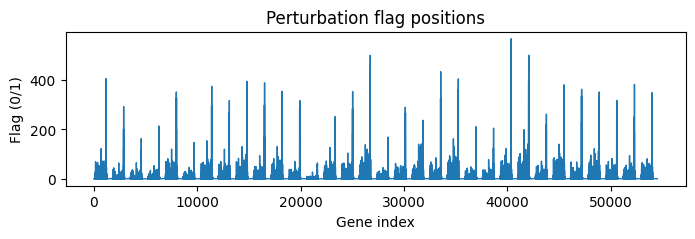

In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# assume second column in x (index 1) is the perturbation flag
flag_col = batch.x[:, 0].cpu().numpy()

# find nonzero indices
nonzero_positions = np.nonzero(flag_col)[0]
print(f"Total nonzeros: {len(nonzero_positions)}")
if len(nonzero_positions) > 0:
    print("First 10 nonzero indices:", nonzero_positions[:10].tolist())

    # group contiguous nonzero positions into spans
    spans = np.split(nonzero_positions, np.where(np.diff(nonzero_positions) != 1)[0] + 1)
    print(f"Found {len(spans)} contiguous spans of nonzeros.")
    for s in spans[:5]:  # show first few spans
        print(f"Span {s[0]}–{s[-1]} (len={len(s)})")

    # visualize the flag column to see pattern
    plt.figure(figsize=(8,2))
    plt.plot(flag_col, lw=1)
    plt.title("Perturbation flag positions")
    plt.xlabel("Gene index")
    plt.ylabel("Flag (0/1)")
    plt.show()
else:
    print("No nonzeros found in flag column.")


In [44]:
### how many ctrl and non ctrl cells in the train/val loaders
def count_ctrl_nonctrl(loader, name="loader"):
    ds = loader.dataset
    ctrl = sum(1 for d in ds if d.pert == "ctrl")
    nonctrl = len(ds) - ctrl
    print(f"{name}: {ctrl} ctrl | {nonctrl} non-ctrl | total {len(ds)}")

count_ctrl_nonctrl(train_loader, "train")
count_ctrl_nonctrl(valid_loader, "val")


train: 75328 ctrl | 74860 non-ctrl | total 150188
val: 0 ctrl | 7584 non-ctrl | total 7584


In [45]:
# same as tutorial default
include_zero_gene = "all"   # or "batch-wise" / False if you prefer
max_seq_len = 1536          # also used in the same block


In [12]:
n_hvg = 0  # number of highly variable genes
include_zero_gene = "all"  # include zero expr genes in training input, "all", "batch-wise", "row-wise", or False
max_seq_len = 1536

# settings for training
MLM = True  # whether to use masked language modeling, currently it is always on.
CLS = False  # celltype classification objective
CCE = False  # Contrastive cell embedding objective
MVC = False  # Masked value prediction for cell embedding
ECS = False  # Elastic cell similarity objective
cell_emb_style = "cls"
mvc_decoder_style = "inner product, detach"
amp = True

In [55]:
save_dir = '/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/scgpt_replogle_save_dir'

In [57]:

print(f"Start training on device={device}. n_train_batches={len(train_loader)}, n_val_batches={len(valid_loader)}")

for epoch in range(1, 13 + 1):

    # inspect a single batch
    batch = next(iter(pert_data.dataloader["train_loader"]))
    print("batch keys:", batch.keys if hasattr(batch, "keys") else getattr(batch, "__dict__", None))
    print("x shape:", batch.x.shape)
    print("y shape:", getattr(batch, "y").shape)
    print("example x (first 5 rows):\n", batch.x[:5])
    # show min/max to see if second column exists
    print("x columns unique counts:", [torch.unique(batch.x[:,i]).numel() if batch.x.shape[1]>i else None for i in range(min(3,batch.x.shape[1]))])

    epoch_start_time = time.time()
    # call train() defined earlier
    train(model, train_loader)

    # evaluate
    val_loss, val_mre = evaluate(model, valid_loader)
    elapsed = time.time() - epoch_start_time
    print("-" * 80)
    print(f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | valid loss {val_loss:.6f} | valid MRE {val_mre:.6f} |")
    print("-" * 80)

    # checkpoint / early stop
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        print(f"New best model (val_loss={best_val_loss:.6f})")
        patience = 0
        torch.save(best_model.state_dict(), save_dir / "best_model.pt")
    else:
        patience += 1
        print(f"No improvement (patience={patience}/{early_stop})")
        if patience >= early_stop:
            print(f"Early stopping at epoch {epoch}")
            break

    # save per-epoch (optional)
    torch.save(model.state_dict(), f"{save_dir}/model_{epoch}.pt")


    # step scheduler
    scheduler.step()

print("Training finished. Best val loss:", best_val_loss)


Start training on device=cuda. n_train_batches=4693, n_val_batches=237
batch keys: <bound method BaseData.keys of DataBatch(x=[54496, 2], y=[32, 1703], de_idx=[32], pert=[32], batch=[54496], ptr=[33])>
x shape: torch.Size([54496, 2])
y shape: torch.Size([32, 1703])
example x (first 5 rows):
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
x columns unique counts: [238, 2]
| epoch   1 | 100/4693 batches | lr 0.0001 | ms/batch 303.13 | loss 65.57 | mse 65.57 |
| epoch   1 | 200/4693 batches | lr 0.0001 | ms/batch 301.49 | loss 62.20 | mse 62.20 |
| epoch   1 | 300/4693 batches | lr 0.0001 | ms/batch 302.72 | loss 65.99 | mse 65.99 |
| epoch   1 | 400/4693 batches | lr 0.0001 | ms/batch 304.14 | loss 61.25 | mse 61.25 |
| epoch   1 | 500/4693 batches | lr 0.0001 | ms/batch 304.33 | loss 64.40 | mse 64.40 |
| epoch   1 | 600/4693 batches | lr 0.0001 | ms/batch 304.90 | loss 62.94 | mse 62.94 |
| epoch   1 | 700/4693 batches | lr 0.0001 | ms/batch 

In [186]:
### check if vocab was correct...
# 1) specials present and default index set correctly
assert "<pad>" in vocab and "<cls>" in vocab and "<eoc>" in vocab
assert vocab["<pad>"] == vocab.get_stoi().get("<pad>")  # pad exists in stoi
print("Specials & default OK")

# 2) vocab length matches expected (what you printed)
print("vocab size:", len(vocab))

# 3) all dataset genes map to an index (and index in valid range)
genes = pert_data.adata.var["gene_name"].tolist()
mapped = [vocab[g] if g in vocab else vocab["<pad>"] for g in genes]
assert len(mapped) == len(genes)
assert all(0 <= i < len(vocab) for i in mapped)
print("All dataset genes mapped to valid vocab indices")

# 4) mapping array shape and type
import numpy as np
gene_ids = np.array(mapped, dtype=int)
print("gene_ids shape:", gene_ids.shape)

# 5) embedding size agrees with vocab size (model must be created/loaded)
emb_num = model.encoder.embedding.num_embeddings
assert emb_num == len(vocab), f"embedding vocab ({emb_num}) != vocab length ({len(vocab)})"
print("Model embedding size matches vocab length")

# 6) sample token/id roundtrip sanity
tok0 = vocab[0]
id0 = vocab[tok0]
print("roundtrip:", tok0, id0, "OK" if id0 == 0 else "BAD")


Specials & default OK
vocab size: 60697
All dataset genes mapped to valid vocab indices
gene_ids shape: (1703,)
Model embedding size matches vocab length
roundtrip: A1BG 0 OK


In [187]:
import json, os
print("vocab file path:", vocab_file)
print("file exists:", os.path.exists(vocab_file))

# show a few tokens from the pretrained vocab.json
with open(vocab_file) as f:
    v = json.load(f)
print("keys:", list(v.keys())[:5])
print("num tokens in file:", len(v))

# confirm model embedding matches this vocab length
print("embedding count:", model.encoder.embedding.num_embeddings)
print("matches vocab.json length:", len(v) == model.encoder.embedding.num_embeddings)


vocab file path: /hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/scGPT_human 2/vocab.json
file exists: True
keys: ['RP5-973N23.5', 'RP11-182N22.10', 'CTB-53D8.3', 'RP11-348N17.2', 'RP11-205M20.8']
num tokens in file: 60697
embedding count: 60697
matches vocab.json length: True


We loaded the pretrained scGPT vocabulary (vocab.json from ../save/scGPT_human) to ensure our fine-tuning used the exact same gene-to-token mapping as the original model. This preserved the pretrained embedding alignment—each gene corresponds to the same embedding index as during pretraining—allowing us to leverage the pretrained weights directly instead of retraining from scratch. The vocabulary also includes special tokens like <pad>, <cls>, and <eoc>, which handle sequence padding and cell-level representations. Using this pretrained vocab guarantees consistent tokenization and embedding semantics between pretraining and fine-tuning.

For our dataset, we then mapped each gene name in .var["gene_name"] to its corresponding token ID in this pretrained vocab. Genes not found were assigned the <pad> token. This produced a gene_ids array matching our dataset’s feature order. Checks confirmed that every gene mapped to a valid index and that the model’s embedding matrix size exactly matched the vocab length (60,697 tokens). In summary, the fine-tuned model uses an identical tokenization scheme to the pretrained scGPT, ensuring consistency between pretraining and downstream training.

Initially, scGPT depended on torchtext for its Vocab class, but torchtext failed to import due to a binary mismatch with our installed PyTorch (libtorchtext.so symbol error). To avoid rebuilding torchtext, we implemented a pure-Python vocabulary shim that replicated the minimal functionality needed by scGPT (Vocab, VocabPybind, and torch_vocab.vocab()). This eliminated the C++ dependency while keeping token-ID mapping behavior identical to the original torchtext version. In short, the tokenization setup let us fine-tune the pretrained model reliably, even in an environment where torchtext could not be used.

In [3]:
save_dir = '/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/scgpt_replogle_save_dir'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
epoch =3

In [ ]:
### sanity check for the scgpt dicts....
import torch
from scgpt.model import TransformerGenerator

# reload model in a new instance


model2 = TransformerGenerator(
    ntoken=len(vocab),                # vocab size
    d_model=cfg["embsize"],           # embedding dim (was embsize)
    nhead=cfg["nheads"],              # attention heads
    d_hid=cfg["d_hid"],               # feedforward dim
    nlayers=cfg["nlayers"],           # encoder layers
    nlayers_cls=cfg.get("n_layers_cls", 3),
    n_cls=1,
    vocab=vocab,
    dropout=cfg.get("dropout", 0.2),
    pad_token=pad_token,
    pad_value=pad_value,
    pert_pad_id=pert_pad_id,
    use_fast_transformer=True,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


# load saved weights
state = torch.load( f"{save_dir}/model_{epoch}.pt", map_location=device)
missing, unexpected = model2.load_state_dict(state, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

for k in state.keys():
    print(k)



In [ ]:
state

In [22]:
key = "encoder.embedding.weight"
print("orig:", model.state_dict()[key][:2, :5])   # first few values
print("reloaded:", model2.state_dict()[key][:2, :5])
print("difference (L2):", (model.state_dict()[key] - model2.state_dict()[key]).pow(2).sum().sqrt())


orig: tensor([[-0.0171, -0.0894,  0.0491,  0.0715, -0.0552],
        [-0.0472,  0.0704, -0.0689,  0.0539, -0.0816]], device='cuda:0')
reloaded: tensor([[-0.0215, -0.0562,  0.0499,  0.0620, -0.0471],
        [-0.1289, -0.0153,  0.0437,  0.0256,  0.0902]], device='cuda:0')
difference (L2): tensor(491.1216, device='cuda:0')


In [4]:
!nvidia-smi

Thu Nov 13 07:17:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  |   00000000:1B:00.0 Off |                  Off |
| 30%   25C    P8             19W /  300W |       4MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### linear and mean models

In [1]:
import json
import os
import sys
import time
import copy
from pathlib import Path
from typing import Iterable, List, Tuple, Dict, Union, Optional
import warnings

import torch
import numpy as np
import matplotlib
from torch import nn
from torch.nn import functional as F

from torch_geometric.loader import DataLoader

from gears import PertData, GEARS
from gears.inference import compute_metrics, deeper_analysis, non_dropout_analysis
from gears.utils import create_cell_graph_dataset_for_prediction


/hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
pert_data = PertData('./data')
pert_data.load(data_path = './data/replogle_scgpt')
# specify data split
pert_data.prepare_split(split = 'simulation', seed = 1)
# get dataloader with batch size
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:160
Done!
Creating dataloaders....
Done!


In [3]:
import numpy as np
from sklearn.linear_model import Ridge



In [10]:
# use gears train dataloaders (dict_keys(['train_loader', 'val_loader', 'test_loader']))
train_loader = pert_data.dataloader["train_loader"]
valid_loader = pert_data.dataloader["val_loader"]


In [7]:
import numpy as np, torch


In [19]:

batch = next(iter(train_loader))
print("batch type, len:", type(batch), len(batch))
for i, item in enumerate(batch):
    t = type(item)
    # try to get shape
    shape = getattr(item, "shape", None)
    # try to get dtype
    try:
        if isinstance(item, torch.Tensor):
            dtype = str(item.dtype)
            sample = item.flatten()[:5].cpu().numpy()
        elif isinstance(item, np.ndarray):
            dtype = str(item.dtype)
            sample = item.flatten()[:5]
        elif isinstance(item, (list, tuple)):
            dtype = "list/tuple"
            try:
                sample = item[:3]
            except Exception:
                sample = repr(item)[:100]
        else:
            dtype = getattr(item, "dtype", type(item))
            sample = repr(item)[:100]
    except Exception as e:
        dtype = "?"
        sample = f"error:{e}"
    print(f"[{i}] type={t}, shape={shape}, dtype={dtype}, sample={sample}")


batch type, len: <class 'abc.DataBatch'> 32
[0] type=<class 'tuple'>, shape=None, dtype=list/tuple, sample=('x', tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]))
[1] type=<class 'tuple'>, shape=None, dtype=list/tuple, sample=('y', tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 2.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
[2] type=<class 'tuple'>, shape=None, dtype=list/tuple, sample=('de_idx', [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], array([  18,  104, 1554, 1555, 1557, 1558, 1559, 1561, 1562, 1563, 1564,
       1569, 1570, 1571, 1572, 1573, 1575, 1576, 1577, 1578]), array([  19,  111, 1554, 1555, 1556, 1557, 1558, 1561, 1562, 1564, 1570,
       1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1617]), array([  19

In [12]:
import numpy as np
from collections import defaultdict
from sklearn.linear_model import Ridge


In [25]:
import numpy as np
from collections import defaultdict
from sklearn.linear_model import Ridge

def get_field(batch, key):
    """Extract a field (e.g., 'y' or 'pert') from GEARS batch objects safely."""
    try:
        # Case 1: batch is a tuple/list of ('name', value)
        if isinstance(batch, (list, tuple)):
            for item in batch:
                if isinstance(item, (list, tuple)) and len(item) >= 2 and item[0] == key:
                    return item[1]
        # Case 2: batch is an object with attributes
        if hasattr(batch, key):
            return getattr(batch, key)
        # Case 3: batch is dict-like
        if isinstance(batch, dict) and key in batch:
            return batch[key]
        # Fallback (may raise)
        return batch[key]
    except Exception:
        raise KeyError(key)

def gather_pseudobulks(loader):
    """Aggregate all cells in each perturbation into pseudobulk mean expression."""
    d = defaultdict(list)
    batch_count = 0
    for batch in loader:
        batch_count += 1
        # print(f"\nProcessing batch {batch_count}...")

        # get expression matrix and perturbation labels
        ybat = get_field(batch, 'y')
        perts = get_field(batch, 'pert')
        # print(f"  ybat type={type(ybat)}, perts type={type(perts)}")

        # convert ybat to numpy
        y_np = ybat.detach().cpu().numpy() if hasattr(ybat, 'detach') else np.asarray(ybat)
        # print(f"  ybat shape={y_np.shape}")

        # make sure perts are strings
        perts_list = [
            p if isinstance(p, str)
            else (p.item().decode() if isinstance(p, bytes) else str(p))
            for p in perts
        ]
        # print(f"  example perturbations: {perts_list[:5]}")

        # group cells by perturbation
        for i, p in enumerate(perts_list):
            d[p].append(y_np[i])

    print(f"\nTotal perturbations found: {len(d)}")
    names = list(d.keys())
    Y = np.vstack([np.mean(d[n], axis=0) for n in names])
    print(f"Pseudobulk matrix shape: {Y.shape}")
    return names, Y

# ======= Main =======
print("Gathering training pseudobulks...")
train_names, Y_train = gather_pseudobulks(train_loader)
print("Gathering validation pseudobulks...")
val_names, Y_val = gather_pseudobulks(valid_loader)

# sanity checks
assert Y_train.ndim == 2, "Y_train must be 2D"
assert Y_val.ndim == 2, "Y_val must be 2D"
assert len(train_names) == Y_train.shape[0], "train_names length mismatch"
assert len(val_names) == Y_val.shape[0], "val_names length mismatch"

print(f"\nTraining set: {Y_train.shape}, Validation set: {Y_val.shape}")

# ======= Mean baseline =======
mean_vec = Y_train.mean(axis=0)
mean_pred = np.tile(mean_vec, (Y_val.shape[0], 1))
print(f"Mean baseline prediction shape: {mean_pred.shape}")

# ======= Linear baseline =======
P_train = np.eye(len(train_names))
print(f"Perturbation identity matrix (train) shape: {P_train.shape}")

print("Fitting ridge regression (alpha=0.1)...")
model = Ridge(alpha=0.1, fit_intercept=True)
model.fit(P_train, Y_train)

# sanity check
print(f"Ridge model coefficients shape: {model.coef_.shape}")

name2idx = {n:i for i,n in enumerate(train_names)}
P_val = np.zeros((len(val_names), len(train_names)))

for i, n in enumerate(val_names):
    if n in name2idx:
        P_val[i, name2idx[n]] = 1.0
    else:
        print(f"Warning: validation perturbation '{n}' not in training set")

lin_pred = model.predict(P_val)
print(f"Linear baseline prediction shape: {lin_pred.shape}")

# final sanity check
assert mean_pred.shape == lin_pred.shape == Y_val.shape, "Shape mismatch among predictions and ground truth"

print("\nDone computing mean and linear baseline predictions.")
print(f"Y_val shape: {Y_val.shape}, mean_pred shape: {mean_pred.shape}, lin_pred shape: {lin_pred.shape}")


Gathering training pseudobulks...

Total perturbations found: 433
Pseudobulk matrix shape: (433, 1703)
Gathering validation pseudobulks...

Total perturbations found: 48
Pseudobulk matrix shape: (48, 1703)

Training set: (433, 1703), Validation set: (48, 1703)
Mean baseline prediction shape: (48, 1703)
Perturbation identity matrix (train) shape: (433, 433)
Fitting ridge regression (alpha=0.1)...
Ridge model coefficients shape: (1703, 433)
Linear baseline prediction shape: (48, 1703)

Done computing mean and linear baseline predictions.
Y_val shape: (48, 1703), mean_pred shape: (48, 1703), lin_pred shape: (48, 1703)


### GEARS train with replogle scgpt codes.

In [ ]:
### gears load code...

In [63]:

from gears import PertData, GEARS
from gears.inference import compute_metrics, deeper_analysis, non_dropout_analysis
from gears.utils import create_cell_graph_dataset_for_prediction



In [64]:
pert_data = PertData('./data')
pert_data.load(data_path = './data/replogle_scgpt')
# specify data split
pert_data.prepare_split(split = 'simulation', seed = 1)
# get dataloader with batch size
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128)



Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:160
Done!
Creating dataloaders....
Done!


In [65]:
pert_data

In [69]:
pert_data.adata.X = pert_data.adata.X.toarray() if hasattr(pert_data.adata.X, "toarray") else pert_data.adata.X

gears_model = GEARS(pert_data, device = 'cuda:0')


In [70]:
from scipy.sparse import csr_matrix
pert_data.adata.X = csr_matrix(pert_data.adata.X)


In [71]:
gears_model.model_initialize(hidden_size = 64)

100%|██████████| 1647/1647 [01:37<00:00, 16.94it/s]


In [ ]:
gears_model.train(epochs = 20)


Epoch 20: Train Overall MSE: 4.6228 Validation Overall MSE: 7.7308. 
Train Top 20 DE MSE: 76.7921 Validation Top 20 DE MSE: 43.8704. 
Done!
Start Testing...
Best performing model: Test Top 20 DE MSE: 96.2841


In [73]:

# save/load model
gears_model.save_model('gears_replogle_scgpt_data')
gears_model.load_pretrained('gears_replogle_scgpt_data')



In [74]:
gears_model

In [75]:
# basic info
print(gears_model)
print("Device:", gears_model.device)
print("Num genes:", gears_model.num_genes)

# control expression vector
print("ctrl_expression shape:", gears_model.ctrl_expression.shape)

# perturbation embedding matrix
print("pert_emb shape:", gears_model.model.pert_emb.weight.data.shape)
print("pert_emb (first 5 rows):")
print(gears_model.model.pert_emb.weight.data[:5].cpu().numpy())

# gene embedding matrix
print("gene_emb shape:", gears_model.model.gene_emb.weight.data.shape)


Device: cuda:0
Num genes: 1703
ctrl_expression shape: torch.Size([1703])
pert_emb shape: torch.Size([1703, 64])
pert_emb (first 5 rows):
[[-1.63127668e-02  5.20095155e-02 -1.94636025e-02  5.02435155e-02
  -3.63404304e-02 -2.19801500e-01 -1.05301058e-02  8.68472308e-02
  -4.60892124e-03 -2.24820435e-01  1.17205262e-01 -4.35350463e-02
  -3.31509747e-02  1.33964106e-01 -1.33096114e-01  2.22746179e-01
  -1.03773504e-01  3.99775095e-02  2.04784811e-01  1.10802718e-01
  -1.50396407e-01 -2.58477293e-02 -6.30917400e-02 -6.90318830e-03
  -2.71411799e-02 -6.85356334e-02 -6.19565733e-02  1.96557064e-02
   1.13529572e-02 -6.74690632e-03 -1.39317736e-01 -5.66327162e-02
   2.76163071e-02 -4.11582142e-02  4.61085998e-02 -4.03096937e-02
   4.57273312e-02  9.30220857e-02  5.05937613e-04  1.71349257e-01
  -1.81017518e-01 -9.52062830e-02  8.49767551e-02 -1.33699700e-01
  -7.77832745e-03  3.53123873e-01 -1.60385191e-01  1.07844666e-01
   9.52168033e-02  1.59805074e-01  6.43030033e-02  2.50922352e-01
   1.

### new model 

linear model with laplacian grn prior.
The GRN is the adjacency matrix adj we supply — it encodes which genes regulate or connect to each other.
From that, the code builds a graph Laplacian L = D − A, which adds a smoothness constraint so connected genes get similar predicted effects.
So the model = linear ridge regression + GRN-based regularization that couples gene predictions along the network edges.

In [ ]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import inv as sp_inv
from sklearn.linear_model import Ridge


In [ ]:
## pull adj from gears


In [ ]:
import os

root_dir = "/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/data/replogle_scgpt/"

for dirpath, dirnames, filenames in os.walk(root_dir):
    # Compute indentation level
    level = dirpath.replace(root_dir, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(dirpath)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in filenames:
        print(f"{subindent}{f}")


/
    go.csv
    simulation_1_0.75_0.4_20_co_expression_network.csv
    perturb_processed.h5ad
splits/
    replogle_scgpt_simulation_1_0.75_subgroup.pkl
    replogle_scgpt_simulation_1_0.75.pkl
data_pyg/
    cell_graphs.pkl


In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
import numpy as np
from scipy.sparse.linalg import inv as sp_inv_scipy  # fallback if sp_inv not in scope
from sklearn.linear_model import Ridge



In [ ]:

# path to GEARS co-expression network file
net_path = "/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/data/replogle_scgpt/simulation_1_0.75_0.4_20_co_expression_network.csv"

# load; typical format: source_gene, target_gene, weight
df = pd.read_csv(net_path)

# if no header, try: df = pd.read_csv(net_path, header=None, names=['source','target','weight'])
# inspect to confirm columns
print(df.head())

# make list of unique genes and mapping
genes = sorted(set(df.iloc[:,0]).union(df.iloc[:,1]))
gene2idx = {g:i for i,g in enumerate(genes)}
n = len(genes)

# build sparse adjacency
rows = [gene2idx[g] for g in df.iloc[:,0]]
cols = [gene2idx[g] for g in df.iloc[:,1]]
vals = df.iloc[:,2].values if df.shape[1] > 2 else np.ones(len(df))

A = sparse.coo_matrix((vals, (rows, cols)), shape=(n, n))
# make symmetric (undirected graph)
A = A + A.T.multiply(A.T > A) - A.multiply(A.T > A)
# remove self-loops
A.setdiag(0)
A.eliminate_zeros()

print(f"Adjacency matrix built: {A.shape}, {A.nnz} edges")
adj = A.tocsr()


  source target  importance
0   AAR2   AAR2    1.000000
1  AARS2  AARS2    1.000000
2   CCT2   AATF    0.593408
3  SUMO2   AATF    0.594140
4  RPL24   AATF    0.595151
Adjacency matrix built: (1702, 1702), 33106 edges


In [ ]:
Y_pred_val.shape

(48, 1703)

In [ ]:
class GRNModel:
    def __init__(self, ridge_model, Gmat):
        self.model = ridge_model
        self.Gmat = Gmat

    def predict(self, X):
        # predict in GRN-transformed space then map back
        return self.model.predict(X) @ self.Gmat

# define your GRN model wrapper
grn_model = GRNModel(clf, Gmat)


In [ ]:
# GRN-regularized linear predictions (same logic as plain ridge)
zero_row = np.zeros((1, len(name2idx)))
intercept_pred = grn_model.predict(zero_row)[0]  # fallback for unseen perturbations
grn_preds = np.zeros_like(mean_preds)

for i, pname in enumerate(pert_names):
    if pname in name2idx:
        onehot = np.zeros((1, len(name2idx)))
        onehot[0, name2idx[pname]] = 1.0
        grn_preds[i] = grn_model.predict(onehot)[0]
    else:
        grn_preds[i] = intercept_pred


In [ ]:
grn_preds.shape

(640, 1703)

In [ ]:
unseen = [p for p in val_names if p not in train_names]
print(f"{len(unseen)} unseen perturbations out of {len(val_names)} total")
print("Examples:", unseen[:10])


48 unseen perturbations out of 48 total
Examples: ['PSMC2+ctrl', 'ESF1+ctrl', 'DCAF11+ctrl', 'SDAD1+ctrl', 'RPL37+ctrl', 'GBA2+ctrl', 'MCRS1+ctrl', 'METTL3+ctrl', 'RNF31+ctrl', 'NBAS+ctrl']


### Replication of figures with linear,mean, gears, scgpt -- and replogle 1187 dataset.

relevant to replicate.
* **Main Fig 2** → core single-perturbation benchmark (L2 + Pearson-delta).
* **ED Fig 7** → variation of predicted vs observed expression across perturbations.
* **ED Fig 8** → alternative single-perturbation metrics (Pearson-delta + L2 vs top-N genes).


In [ ]:
### scgpt load code...


In [ ]:
pert_data = PertData('./data')
pert_data.load(data_path = './data/replogle_scgpt')
# specify data split
pert_data.prepare_split(split = 'simulation', seed = 1)
# get dataloader with batch size
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128)

In [ ]:
from pathlib import Path
import json, numpy as np, torch
from scgpt.tokenizer.gene_tokenizer import GeneVocab, Vocab, VocabPybind

# special tokens
special_tokens = ["<pad>", "<cls>", "<eoc>"]
pad_token = "<pad>"
pad_value = 0
pert_pad_id = 2

# load pretrained model directory
load_model = "/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/scGPT_human 2"
model_dir = Path(load_model)
vocab_file = model_dir / "vocab.json"
model_file = model_dir / "best_model.pt"
model_config_file = model_dir / "args.json"

print(GeneVocab)
# load vocab and add specials
vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)
vocab.set_default_index(vocab[pad_token])

# check the type
print(type(vocab))

# number of tokens in vocab
print("vocab size:", len(vocab))

# view first 20 tokens
print("first 20 tokens:", [vocab[i] for i in range(20)])

# look up index of a specific token
print("index of <pad>:", vocab["<pad>"])

# or reverse lookup (id → token)
print("token for index 0:", vocab[0])

# see all special tokens you added
for s in special_tokens:_


# map gene names
genes = pert_data.adata.var["gene_name"].tolist()
gene_ids = np.array([vocab[gene] if gene in vocab else vocab[pad_token] for gene in genes])
n_genes = len(genes)

from scgpt.model import TransformerGenerator

with open(model_config_file) as f:
    cfg = json.load(f)



In [ ]:


save_dir = '/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/scgpt_replogle_save_dir'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
epoch =3

### sanity check for the scgpt dicts....
import torch
from scgpt.model import TransformerGenerator

# reload model in a new instance


model2 = TransformerGenerator(
    ntoken=len(vocab),                # vocab size
    d_model=cfg["embsize"],           # embedding dim (was embsize)
    nhead=cfg["nheads"],              # attention heads
    d_hid=cfg["d_hid"],               # feedforward dim
    nlayers=cfg["nlayers"],           # encoder layers
    nlayers_cls=cfg.get("n_layers_cls", 3),
    n_cls=1,
    vocab=vocab,
    dropout=cfg.get("dropout", 0.2),
    pad_token=pad_token,
    pad_value=pad_value,
    pert_pad_id=pert_pad_id,
    use_fast_transformer=True,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


# load saved weights
state = torch.load( f"{save_dir}/model_{epoch}.pt", map_location=device)
missing, unexpected = model2.load_state_dict(state, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

for k in state.keys():
    print(k)



cuda
Missing keys: []
Unexpected keys: []
encoder.embedding.weight
encoder.enc_norm.weight
encoder.enc_norm.bias
value_encoder.linear1.weight
value_encoder.linear1.bias
value_encoder.linear2.weight
value_encoder.linear2.bias
value_encoder.norm.weight
value_encoder.norm.bias
pert_encoder.weight
transformer_encoder.layers.0.self_attn.in_proj_weight
transformer_encoder.layers.0.self_attn.in_proj_bias
transformer_encoder.layers.0.self_attn.out_proj.weight
transformer_encoder.layers.0.self_attn.out_proj.bias
transformer_encoder.layers.0.linear1.weight
transformer_encoder.layers.0.linear1.bias
transformer_encoder.layers.0.linear2.weight
transformer_encoder.layers.0.linear2.bias
transformer_encoder.layers.0.norm1.weight
transformer_encoder.layers.0.norm1.bias
transformer_encoder.layers.0.norm2.weight
transformer_encoder.layers.0.norm2.bias
transformer_encoder.layers.1.self_attn.in_proj_weight
transformer_encoder.layers.1.self_attn.in_proj_bias
transformer_encoder.layers.1.self_attn.out_proj.w

#### get the preds

In [109]:
# def predict(
#     model: TransformerGenerator, pert_list: List[str], pool_size: Optional[int] = None
# ) -> Dict:
#     """
#     Predict the gene expression values for the given perturbations.

#     Args:
#         model (:class:`torch.nn.Module`): The model to use for prediction.
#         pert_list (:obj:`List[str]`): The list of perturbations to predict.
#         pool_size (:obj:`int`, optional): For each perturbation, use this number
#             of cells in the control and predict their perturbation results. Report
#             the stats of these predictions. If `None`, use all control cells.
#     """
#     adata = pert_data.adata
#     ctrl_adata = adata[adata.obs["condition"] == "ctrl"]
#     if pool_size is None:
#         pool_size = len(ctrl_adata.obs)
#     gene_list = pert_data.gene_names.values.tolist()
#     for pert in pert_list:
#         for i in pert:
#             if i not in gene_list:
#                 raise ValueError(
#                     "The gene is not in the perturbation graph. Please select from GEARS.gene_list!"
#                 )

#     model.eval()
#     device = next(model.parameters()).device
#     with torch.no_grad():
#         results_pred = {}
#         for pert in pert_list:
#             cell_graphs = create_cell_graph_dataset_for_prediction(
#                 pert, ctrl_adata, gene_list, device, num_samples=pool_size
#             )
#             loader = DataLoader(cell_graphs, batch_size=eval_batch_size, shuffle=False)
#             preds = []
#             for batch_data in loader:
#                 pred_gene_values = model.pred_perturb(
#                     batch_data, include_zero_gene, gene_ids=gene_ids, amp=amp
#                 )
#                 preds.append(pred_gene_values)
#             preds = torch.cat(preds, dim=0)
#             results_pred["_".join(pert)] = np.mean(preds.detach().cpu().numpy(), axis=0)

#     return results_pred



from tqdm import tqdm
import torch, numpy as np
# use PyG's DataLoader
from torch_geometric.loader import DataLoader as GeoDataLoader

def predict(
    model: TransformerGenerator, pert_list: List[str], pool_size: Optional[int] = None
) -> Dict:
    adata = pert_data.adata
    ctrl_adata = adata[adata.obs["condition"] == "ctrl"]
    if pool_size is None:
        pool_size = len(ctrl_adata.obs)
        print(pool_size)
    gene_list = pert_data.gene_names.values.tolist()
    for pert in pert_list:
        for i in pert:
            if i not in gene_list:
                raise ValueError(f"Gene {i} not in perturbation graph!")

    model.eval()
    device = next(model.parameters()).device
    print(f"\n Running predictions on device: {device}\n")

    results_pred = {}
    with torch.no_grad():
        for pert in tqdm(pert_list, desc="Predicting perturbations", ncols=100):
            cell_graphs = create_cell_graph_dataset_for_prediction(
                pert, ctrl_adata, gene_list, device, num_samples=pool_size
            )
            # use PyG DataLoader which knows how to batch Data objects
            loader = GeoDataLoader(cell_graphs, batch_size=eval_batch_size, shuffle=False)
            preds = []
            for batch_data in loader:
                pred_gene_values = model.pred_perturb(
                    batch_data, include_zero_gene, gene_ids=gene_ids, amp=amp
                )
                preds.append(pred_gene_values)
            preds = torch.cat(preds, dim=0)
            results_pred["_".join(pert)] = np.mean(preds.detach().cpu().numpy(), axis=0)

    print("\n Finished all predictions.")
    return results_pred



In [81]:
import numpy as np

# prepare perturbation lists (exclude ctrl) and canonicalize to lists of gene names
adata = pert_data.adata
conds = adata.obs['condition'].astype(str)
pert_names = sorted([c for c in conds.unique() if c != 'ctrl'])
pert_lists = [[g for g in p.split('+') if g != 'ctrl'] for p in pert_names]

# helper: compute pseudobulk mean for a condition (returns 1D numpy)
def pseudobulk_mean(cond):
    mask = (conds == cond).values if hasattr(conds, "values") else (conds == cond)
    X = adata.X[mask]
    if hasattr(X, "toarray"):
        return np.asarray(X.toarray()).mean(axis=0).ravel()
    return np.asarray(X).mean(axis=0).ravel()

# ground truth matrix aligned to pert_names
Y_obs = np.vstack([pseudobulk_mean(p) for p in pert_names])


In [85]:
Y_obs.shape

(640, 1703)

In [83]:
pert_lists[0:5]

[['AAR2'], ['AARS'], ['AARS2'], ['AATF'], ['ABCF1']]

In [86]:

# MEAN predictions (global training mean vector `mean_vec` assumed available)
mean_preds = np.tile(mean_vec, (len(pert_names), 1))


In [87]:
mean_preds.shape

(640, 1703)

In [88]:

# LINEAR predictions: use trained Ridge `model` and name2idx mapping (train perturb names -> idx)
zero_row = np.zeros((1, len(name2idx)))
intercept_pred = model.predict(zero_row)[0]  # fallback for unseen pert
lin_preds = np.zeros_like(mean_preds)
for i, pname in enumerate(pert_names):
    if pname in name2idx:
        onehot = np.zeros((1, len(name2idx)))
        onehot[0, name2idx[pname]] = 1.0
        lin_preds[i] = model.predict(onehot)[0]
    else:
        lin_preds[i] = intercept_pred


In [89]:
lin_preds.shape

(640, 1703)

In [90]:

# GEARS predictions: gears_model.predict expects list-of-lists like pert_lists
gears_out = gears_model.predict(pert_lists)  # returns dict keyed by "_".join(pert)
gears_preds = np.vstack([gears_out["_".join(pl)] for pl in pert_lists])


In [91]:
gears_preds.shape

(640, 1703)

In [114]:
eval_batch_size = 16
n_hvg = 0  # number of highly variable genes
include_zero_gene = "all"  # include zero expr genes in training input, "all", "batch-wise", "row-wise", or False
max_seq_len = 1536

# settings for training
MLM = True  # whether to use masked language modeling, currently it is always on.
CLS = False  # celltype classification objective
CCE = False  # Contrastive cell embedding objective
MVC = False  # Masked value prediction for cell embedding
ECS = False  # Elastic cell similarity objective
cell_emb_style = "cls"
mvc_decoder_style = "inner product, detach"
amp = True

pool_size=1000

In [115]:

# scGPT predictions: use the provided predict(...) function for scGPT
scgpt_out = predict(model2, pert_lists, pool_size=pool_size)  # returns dict keyed by "_".join(pert)
scgpt_preds = np.vstack([scgpt_out["_".join(pl)] for pl in pert_lists])



 Running predictions on device: cuda:0



Predicting perturbations:   0%|                                             | 0/640 [00:00<?, ?it/s]

Predicting perturbations: 100%|███████████████████████████████████| 640/640 [34:26<00:00,  3.23s/it]


 Finished all predictions.


In [116]:
scgpt_preds.shape

(640, 1703)

In [ ]:
# GRN-regularized linear predictions (same logic as plain ridge)
zero_row = np.zeros((1, len(name2idx)))
intercept_pred = grn_model.predict(zero_row)[0]  # fallback for unseen perturbations
grn_preds = np.zeros_like(mean_preds)

for i, pname in enumerate(pert_names):
    if pname in name2idx:
        onehot = np.zeros((1, len(name2idx)))
        onehot[0, name2idx[pname]] = 1.0
        grn_preds[i] = grn_model.predict(onehot)[0]
    else:
        grn_preds[i] = intercept_pred


In [ ]:
unseen = [p for p in val_names if p not in train_names]
print(f"{len(unseen)} unseen perturbations out of {len(val_names)} total")
print("Examples:", unseen[:10])


In [158]:

# final outputs (aligned to pert_names order)
# Y_obs, mean_preds, lin_preds, gears_preds, scgpt_preds
print("Shapes:", Y_obs.shape, mean_preds.shape, lin_preds.shape, gears_preds.shape, scgpt_preds.shape, grn_preds.shape)


Shapes: (640, 1703) (640, 1703) (640, 1703) (640, 1703) (640, 1703) (640, 1703)


#### producing the figures

In [160]:
# find unseen perturbations
unseen = [p for p in pert_names if p not in name2idx]
unseen_idx = [i for i,p in enumerate(pert_names) if p in unseen]
print(f"{len(unseen_idx)} unseen perturbations")

# subset to unseen only
Y_obs = Y_obs[unseen_idx]
mean_preds_unseen = mean_preds[unseen_idx]
lin_preds_unseen = lin_preds[unseen_idx]
gears_preds_unseen = gears_preds[unseen_idx]
scgpt_preds_unseen = scgpt_preds[unseen_idx]
grn_preds_unseen = grn_preds[unseen_idx]
pert_names_unseen = [pert_names[i] for i in unseen_idx]
print(Y_obs.shape)


208 unseen perturbations
(208, 1703)


In [161]:
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Y_obs, mean_preds, lin_preds, gears_preds, scgpt_preds, mean_vec, pert_names assumed
models = {'Mean': mean_preds_unseen, 'Linear': lin_preds_unseen, 'GEARS': gears_preds_unseen, 'scGPT': scgpt_preds_unseen, 'GRN_Linear':grn_preds_unseen}
top_idx = np.argsort(-mean_vec)

def L2(a,b): return np.sqrt(np.mean((a[top_idx]-b[top_idx])**2))
def PD(a,b,c): 
    x,y=(a-c)[top_idx],(b-c)[top_idx]
    return pearsonr(x,y)[0] if np.std(x)>0 and np.std(y)>0 else np.nan

l2, pd = {}, {}
for k,v in models.items():
    l2[k]=[L2(v[i],Y_obs[i]) for i in range(len(Y_obs))]
    pd[k]=[PD(v[i],Y_obs[i],mean_vec) for i in range(len(Y_obs))]


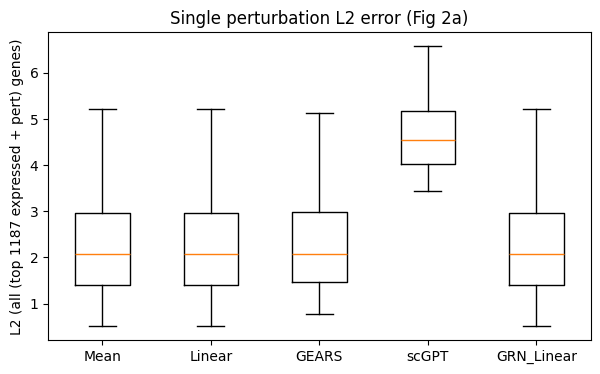

In [162]:

# --- Fig 2a: L2 beeswarm ---
plt.figure(figsize=(7,4))
plt.boxplot([l2[m] for m in models], labels=models.keys(), showfliers=False)
plt.ylabel("L2 (all (top 1187 expressed + pert) genes)")
plt.title("Single perturbation L2 error (Fig 2a)")
plt.show()


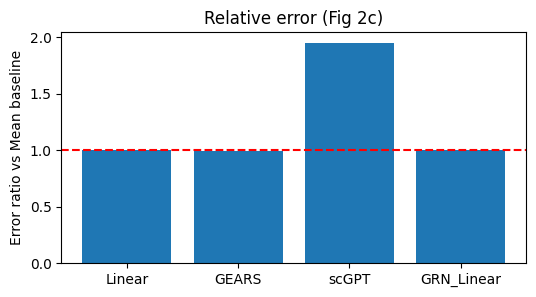

In [163]:

# --- Fig 2c: ratio to mean baseline ---
base=np.mean(l2['Mean'])
ratios={m:np.mean(np.array(l2[m])/base) for m in models if m!='Mean'}
plt.figure(figsize=(6,3))
plt.bar(ratios.keys(), ratios.values())
plt.axhline(1, ls='--', color='r')
plt.ylabel("Error ratio vs Mean baseline")
plt.title("Relative error (Fig 2c)")
plt.show()


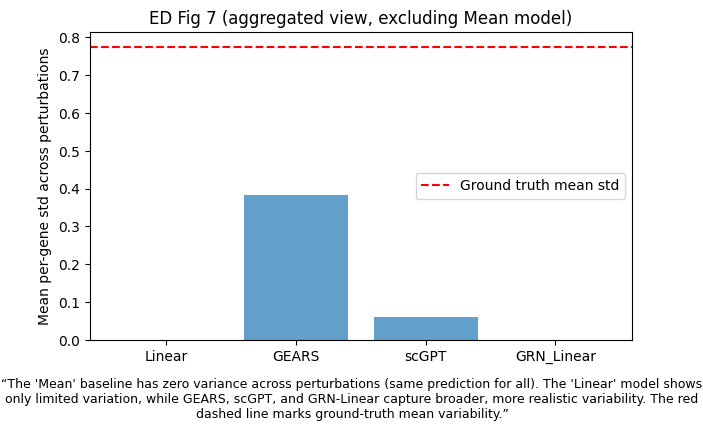

In [166]:

# --- ED Fig 7: variation across perturbations ---

obs_std = np.std(Y_obs, axis=0)
# exclude Mean model (it has zero variance)
models_wo_mean = {k: v for k, v in models.items() if k != 'Mean'}

means = {m: np.mean(np.std(models_wo_mean[m], axis=0)) for m in models_wo_mean}

plt.figure(figsize=(7,4))
plt.bar(list(means.keys()), list(means.values()), alpha=0.7)
plt.axhline(obs_std.mean(), color='r', ls='--', label='Ground truth mean std')
plt.ylabel("Mean per-gene std across perturbations")
plt.title("ED Fig 7 (aggregated view, excluding Mean model)")
plt.legend()
plt.figtext(
    0.5, -0.08,
    "“The 'Mean' baseline has zero variance across perturbations (same prediction for all). The 'Linear' model shows only limited variation, while GEARS, scGPT, and GRN-Linear capture broader, more realistic variability. The red dashed line marks ground-truth mean variability.”",
    wrap=True, ha='center', fontsize=9
)
plt.show()





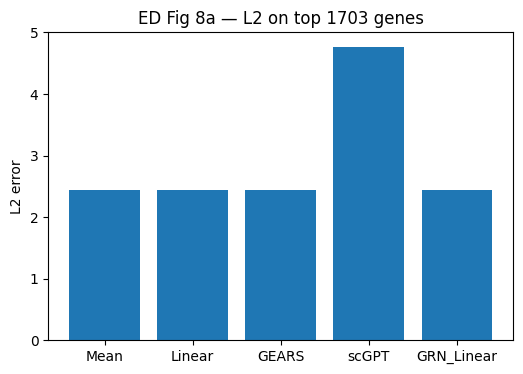

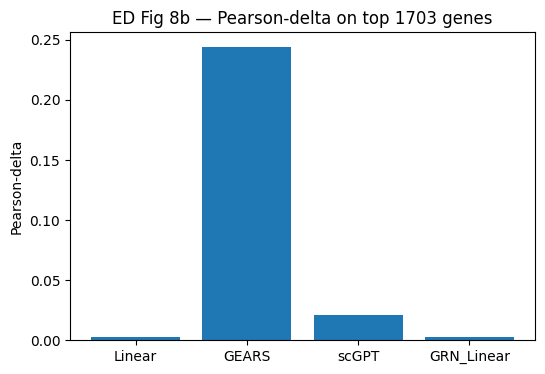

In [165]:

# --- ED Fig 8: metrics vs top-N genes ---

N = 1703  # use all 1187 + pert genes
idx = np.arange(N)

plt.figure(figsize=(6,4))
l2_vals = {m: np.mean([np.sqrt(np.mean((models[m][i][idx] - Y_obs[i][idx])**2))
                       for i in range(len(Y_obs))]) for m in models}
plt.bar(l2_vals.keys(), l2_vals.values())
plt.ylabel("L2 error")
plt.title(f"ED Fig 8a — L2 on top {N} genes")
plt.show()

plt.figure(figsize=(6,4))
pd_vals = {m: np.nanmean([pearsonr((models[m][i][idx]-mean_vec[idx]),
                                   (Y_obs[i][idx]-mean_vec[idx]))[0]
                          for i in range(len(Y_obs))]) for m in models}
plt.bar(pd_vals.keys(), pd_vals.values())
plt.ylabel("Pearson-delta")
plt.title(f"ED Fig 8b — Pearson-delta on top {N} genes")
plt.show()



### Analysis 1: What this experiment is trying to find (conceptually)

This analysis asks:

“Do models actually capture perturbation-specific biological mechanisms, or just reproduce a few global transcriptional axes?”

- By counting how often the same genes appear at the top across perturbations, you’re measuring model diversity and specificity:

- High overlap (same top genes everywhere) → low specificity, model mostly captures general variance.

- Low overlap (different top genes per perturbation) → higher interpretability and true perturbation sensitivity.

In [168]:
import numpy as np, matplotlib.pyplot as plt, random


In [171]:

# pick 5 random perturbations from the training list
sample_perts = random.sample(train_names, 5)
gene_list = list(pert_data.adata.var['gene_name'])



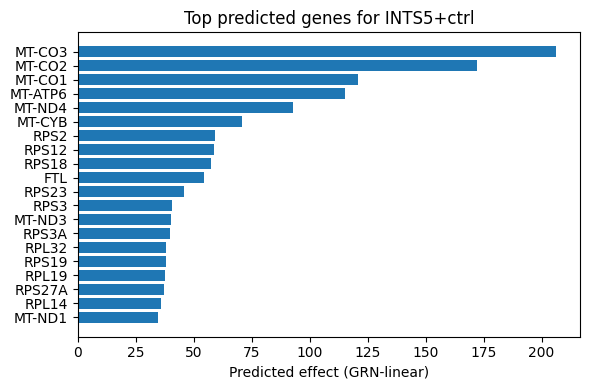

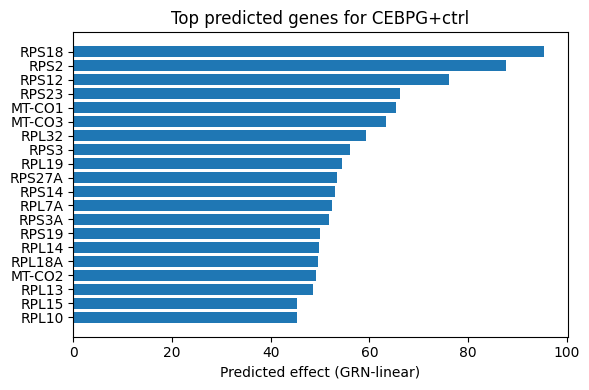

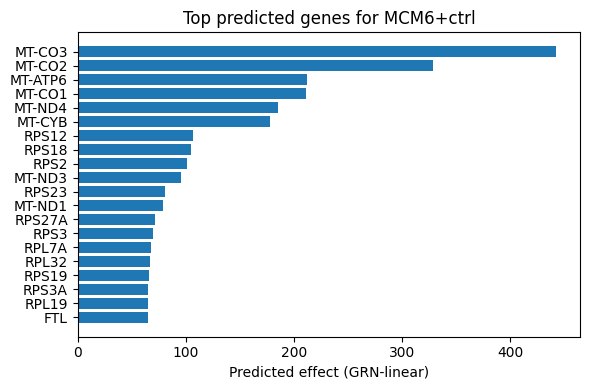

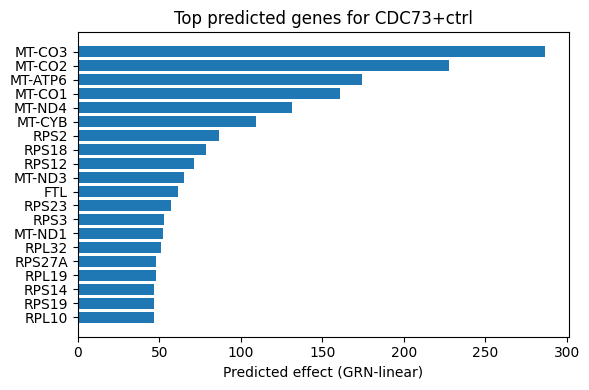

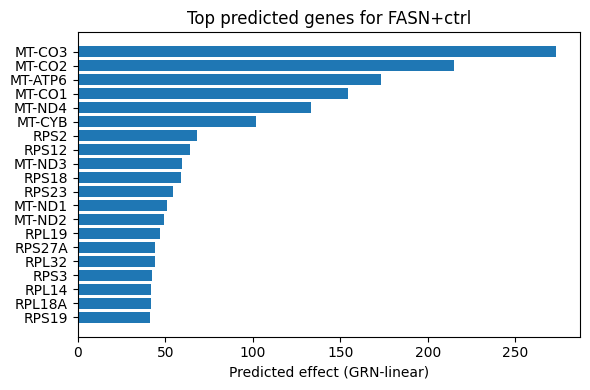

In [172]:

for pert_name in sample_perts:
    idx = name2idx[pert_name]
    onehot = np.zeros((1, len(name2idx)))
    onehot[0, idx] = 1.0
    pred_vec = grn_model.predict(onehot)[0]

    top20 = np.argsort(-np.abs(pred_vec))[:20]
    top_genes = [gene_list[i] for i in top20]
    top_vals = pred_vec[top20]

    plt.figure(figsize=(6,4))
    plt.barh(top_genes[::-1], top_vals[::-1])
    plt.title(f"Top predicted genes for {pert_name}")
    plt.xlabel("Predicted effect (GRN-linear)")
    plt.tight_layout()
    plt.show()


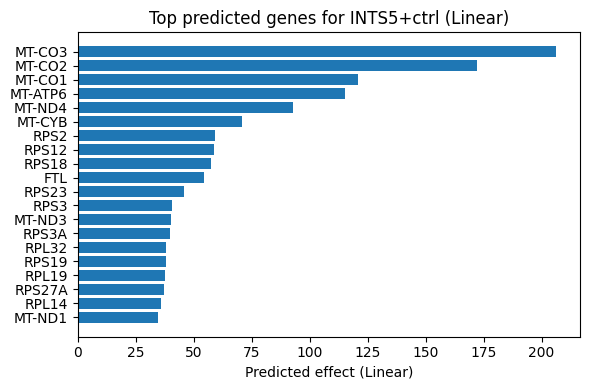

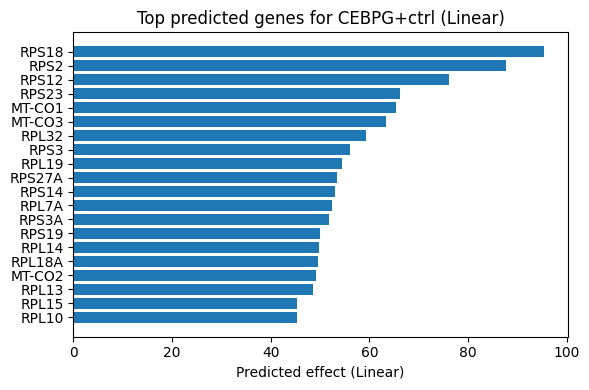

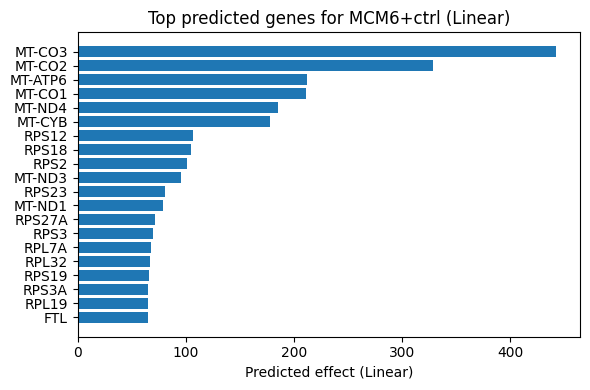

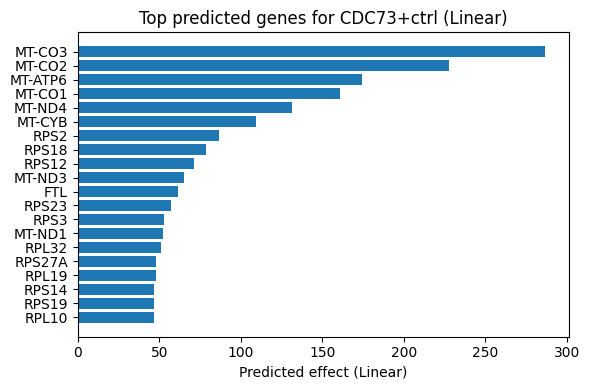

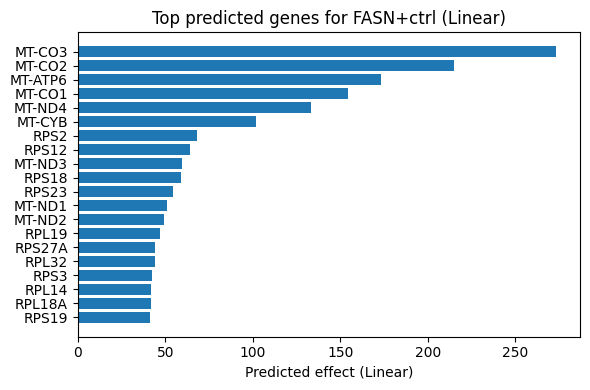

In [173]:
for pert_name in sample_perts:
    idx = name2idx[pert_name]
    onehot = np.zeros((1, len(name2idx)))
    onehot[0, idx] = 1.0
    pred_vec = model.predict(onehot)[0]   # <-- plain linear model

    top20 = np.argsort(-np.abs(pred_vec))[:20]
    top_genes = [gene_list[i] for i in top20]
    top_vals = pred_vec[top20]

    plt.figure(figsize=(6,4))
    plt.barh(top_genes[::-1], top_vals[::-1])
    plt.title(f"Top predicted genes for {pert_name} (Linear)")
    plt.xlabel("Predicted effect (Linear)")
    plt.tight_layout()
    plt.show()


In [176]:
target_gene = "MT-CO3"
idx_target = gene_list.index(target_gene)

def count_top_gene(model):
    count = 0
    print('Total perts under analysis:', len(train_names))
    for pert in train_names:   # or val_names / pert_names depending on what you used
        i = name2idx.get(pert)
        if i is None:
            continue
        onehot = np.zeros((1, len(name2idx)))
        onehot[0, i] = 1.0
        pred_vec = model.predict(onehot)[0]
        top_gene_idx = np.argmax(np.abs(pred_vec))
        if top_gene_idx == idx_target:
            count += 1
    return count

n_lin  = count_top_gene(model)
n_grn  = count_top_gene(grn_model)

print(f"Perturbations with MT-CO3 as top gene:")
print(f"  Linear:     {n_lin}")
print(f"  GRN-Linear: {n_grn}")


Total perts under analysis: 433
Total perts under analysis: 433
Perturbations with MT-CO3 as top gene:
  Linear:     427
  GRN-Linear: 427


If MT-CO3 is the top-predicted gene for almost every perturbation (427 / 433), both the Linear and GRN-Linear models are essentially dominated by that one gene.
That implies:
- The models’ weights or outputs are biased toward a global signal rather than perturbation-specific effects.
- MT-CO3 (a mitochondrial gene) likely has high overall variance or correlation with total expression level / sequencing depth across our dataset.
- Our predictors are therefore learning to reconstruct this dominant global component rather than distinct perturbation-driven patterns.

In [177]:
mt_idx = gene_list.index("MT-CO3")
print("MT-CO3 variance:", np.var(Y_train[:, mt_idx]))
print("MT-CO3 mean:", np.mean(Y_train[:, mt_idx]))


MT-CO3 variance: 3362.8132
MT-CO3 mean: 274.0214


In [178]:
corr = np.corrcoef(Y_train.T)
top_corrs = np.argsort(-corr[mt_idx])[:10]
[gene_list[i] for i in top_corrs]


['MT-CO3',
 'MT-ND4',
 'MT-CO2',
 'MT-CYB',
 'MT-CO1',
 'MT-ATP6',
 'MT-ND1',
 'MT-ND3',
 'MT-ND2',
 'MT-ND5']

Remove mitochondrial genes and try to isolate true perturbation effect. 

In [179]:
mask_non_mito = ~pert_data.adata.var['gene_name'].str.startswith("MT-")
Y_train = Y_train[:, mask_non_mito]
Y_val   = Y_val[:, mask_non_mito]
mean_vec = mean_vec[mask_non_mito]
gene_list = list(np.array(gene_list)[mask_non_mito])


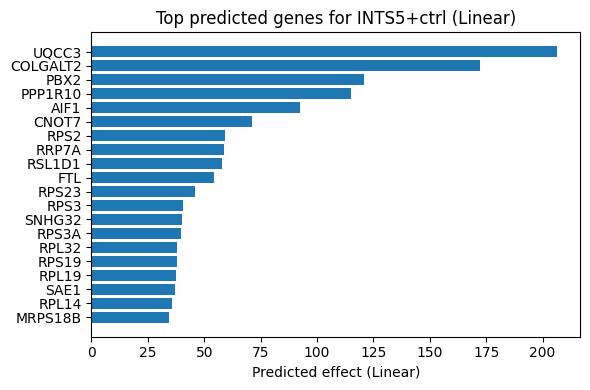

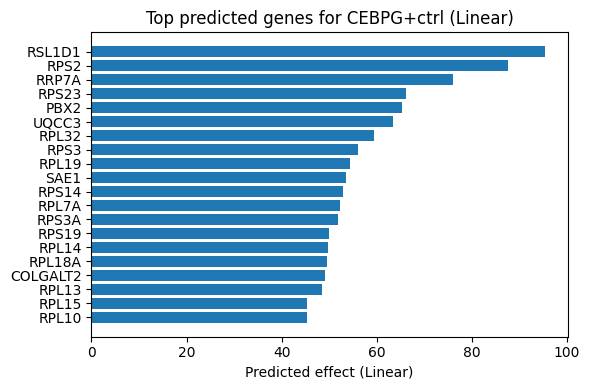

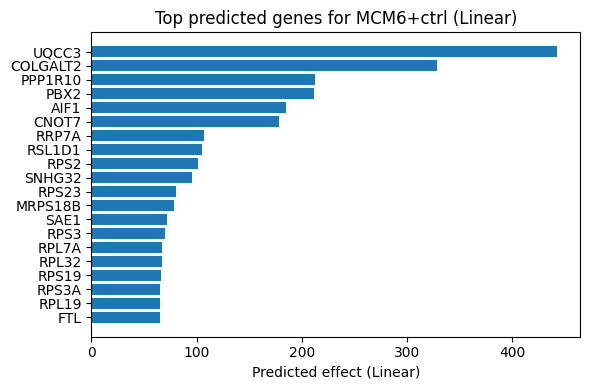

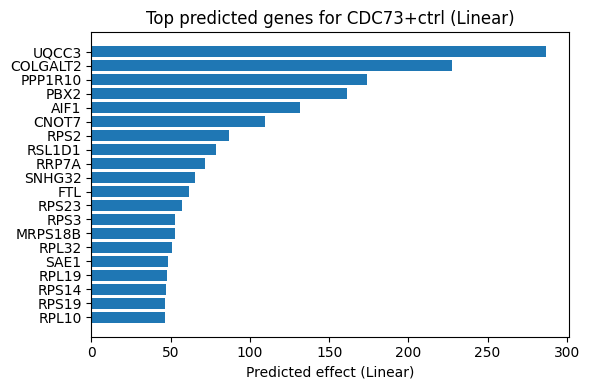

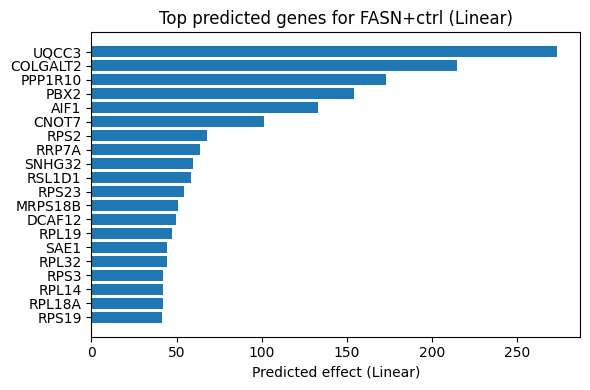

In [180]:
for pert_name in sample_perts:
    idx = name2idx[pert_name]
    onehot = np.zeros((1, len(name2idx)))
    onehot[0, idx] = 1.0
    pred_vec = model.predict(onehot)[0]   # <-- plain linear model

    top20 = np.argsort(-np.abs(pred_vec))[:20]
    top_genes = [gene_list[i] for i in top20]
    top_vals = pred_vec[top20]

    plt.figure(figsize=(6,4))
    plt.barh(top_genes[::-1], top_vals[::-1])
    plt.title(f"Top predicted genes for {pert_name} (Linear)")
    plt.xlabel("Predicted effect (Linear)")
    plt.tight_layout()
    plt.show()


Seems all the top-5 genes with the exclusion also is like similar genes.. Let's see how many of these genes are within the top5 genes of the other genes.

In [181]:
import numpy as np

# make sure these exist in our workspace:
# gene_list, pert_names (list of all perturbation names you're analyzing),
# name2idx (mapping for train perturbations), model (plain ridge), grn_model (wrapper)

def pred_for_pert(model_obj, pert_name):
    if pert_name in name2idx:
        onehot = np.zeros((1, len(name2idx)))
        onehot[0, name2idx[pert_name]] = 1.0
        return model_obj.predict(onehot)[0]
    else:
        # fallback to intercept-like prediction (zeros onehot)
        zero = np.zeros((1, len(name2idx)))
        return model_obj.predict(zero)[0]

# select target perturbation
target = "MCM6+ctrl"
vec_lin = pred_for_pert(model, target)
vec_grn = pred_for_pert(grn_model, target)

# get top5 gene indices and names
top5_lin_idx = np.argsort(-np.abs(vec_lin))[:5]
top5_grn_idx = np.argsort(-np.abs(vec_grn))[:5]
top5_lin = [gene_list[i] for i in top5_lin_idx]
top5_grn = [gene_list[i] for i in top5_grn_idx]

print("Top-5 (Linear):", top5_lin)
print("Top-5 (GRN-Linear):", top5_grn)

# function to get top5 set for any pert for a given model
def all_top5_sets(model_obj):
    sets = {}
    for p in pert_names:
        v = pred_for_pert(model_obj, p)
        idx = np.argsort(-np.abs(v))[:5]
        sets[p] = set(gene_list[i] for i in idx)
    return sets

top5_sets_lin = all_top5_sets(model)
top5_sets_grn = all_top5_sets(grn_model)

# counts per gene and overall prevalence (Linear)
counts_lin = {g: sum(1 for p in pert_names if g in top5_sets_lin[p]) for g in top5_lin}
overall_lin = sum(1 for p in pert_names if len(top5_sets_lin[p].intersection(set(top5_lin)))>0)

# counts per gene and overall prevalence (GRN)
counts_grn = {g: sum(1 for p in pert_names if g in top5_sets_grn[p]) for g in top5_grn}
overall_grn = sum(1 for p in pert_names if len(top5_sets_grn[p].intersection(set(top5_grn)))>0)

print("\nLinear model counts (how many perts include that gene in their top5):")
for g,c in counts_lin.items(): print(f"  {g}: {c} / {len(pert_names)}")
print(f"Perturbations with any of MCM6 top5 (Linear): {overall_lin} / {len(pert_names)}")

print("\nGRN-linear model counts:")
for g,c in counts_grn.items(): print(f"  {g}: {c} / {len(pert_names)}")
print(f"Perturbations with any of MCM6 top5 (GRN): {overall_grn} / {len(pert_names)}")


Top-5 (Linear): [np.str_('UQCC3'), np.str_('COLGALT2'), np.str_('PPP1R10'), np.str_('PBX2'), np.str_('AIF1')]
Top-5 (GRN-Linear): [np.str_('UQCC3'), np.str_('COLGALT2'), np.str_('PPP1R10'), np.str_('PBX2'), np.str_('AIF1')]

Linear model counts (how many perts include that gene in their top5):
  UQCC3: 639 / 640
  COLGALT2: 637 / 640
  PPP1R10: 631 / 640
  PBX2: 625 / 640
  AIF1: 611 / 640
Perturbations with any of MCM6 top5 (Linear): 640 / 640

GRN-linear model counts:
  UQCC3: 639 / 640
  COLGALT2: 637 / 640
  PPP1R10: 631 / 640
  PBX2: 625 / 640
  AIF1: 611 / 640
Perturbations with any of MCM6 top5 (GRN): 640 / 640


Interpretation:
Even after filtering mitochondrial genes post-hoc, both Linear and GRN-Linear models still predict the same top-5 genes (UQCC3, COLGALT2, PPP1R10, PBX2, AIF1) for nearly all perturbations (≥ 600 / 640).
This shows that removing MT genes after training doesn’t remove the learned global bias — the models have internalized that structure during training (or at least that's the thought).
To rigorously isolate perturbation-specific effects, the models should be retrained on an MT-filtered dataset (or after regressing out mitochondrial signal).

Are SCGPT and GEARS models also training in the similar vain?

In [183]:
import pandas as pd
import numpy as np

def top_gene_counts(preds, gene_list, topN=5):
    top_names=[]
    for i in range(preds.shape[0]):
        top_idx=np.argsort(-np.abs(preds[i]))[:topN]
        top_names.extend([gene_list[j] for j in top_idx])
    unique, counts = np.unique(top_names, return_counts=True)
    return pd.DataFrame({'Gene': unique, 'Count': counts}).sort_values('Count', ascending=False).head(10)

gears_top = top_gene_counts(gears_preds, gene_list)
scgpt_top = top_gene_counts(scgpt_preds, gene_list)

tbl = pd.concat([
    gears_top.rename(columns={'Count':'GEARS Count'}),
    scgpt_top.rename(columns={'Gene':'Gene', 'Count':'scGPT Count'})
], axis=1)

# Align by gene names
tbl = tbl.loc[:, ['Gene','GEARS Count','scGPT Count']].fillna(0)
tbl = tbl.sort_values(by=['GEARS Count','scGPT Count'], ascending=False).reset_index(drop=True)

print(tbl.to_string(index=False))


    Gene     Gene  GEARS Count  scGPT Count
COLGALT2 COLGALT2          640        640.0
    PBX2     PBX2          640        640.0
   UQCC3        0          640          0.0
 PPP1R10  PPP1R10          637        640.0
    AIF1     AIF1          634        640.0
  RSL1D1        0            6          0.0
    RPS2    UQCC3            3        640.0


Yes. so this tells us something. Maybe the MT-genes have confounded the model. But something interesting is whwy that original dataset had kept these genes. This dataset is used widely in many perturbation prediction studies.

If the same few non-mitochondrial genes dominate the top-5 predictions across nearly all perturbations for every model (Linear, GRN-Linear, GEARS, scGPT), it means:

- Low model specificity – the models aren’t differentiating well between perturbations.
They’re learning a global response pattern (a small set of genes that shift similarly for many perts) instead of distinct signatures.

- Bias toward high-variance / hub genes – those top genes likely have the largest dynamic range or appear in many gene-gene edges, so the models over-weight them.

- Shared latent representation problem – even deep models (GEARS, scGPT) converge on the same directions in expression space, suggesting that the dataset’s signal-to-noise or label diversity is limited.

#### GO and Biological analysis on these genes -- do they have some sort of biological meaning?

In [187]:
# !pip install gseapy


                                                Term Overlap  Adjusted P-value
0  negative regulation of cardiac muscle cell apo...     1/6          0.023528
1                       ruffle assembly (GO:0097178)     1/6          0.023528
2  parallel actin filament bundle assembly (GO:00...     1/7          0.023528
3  respiratory chain complex III assembly (GO:001...     1/8          0.023528
4  negative regulation of striated muscle cell ap...     1/8          0.023528
5  mitochondrial respiratory chain complex III as...     1/8          0.023528
6  regulation of cardiac muscle cell apoptotic pr...    1/11          0.023528
7             actin crosslink formation (GO:0051764)    1/12          0.023528
8  mitochondrial electron transport, ubiquinol to...    1/12          0.023528
9  negative regulation of smooth muscle cell migr...    1/14          0.023528


<Axes: title={'center': 'GO Enrichment of Recurrent Top Genes'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

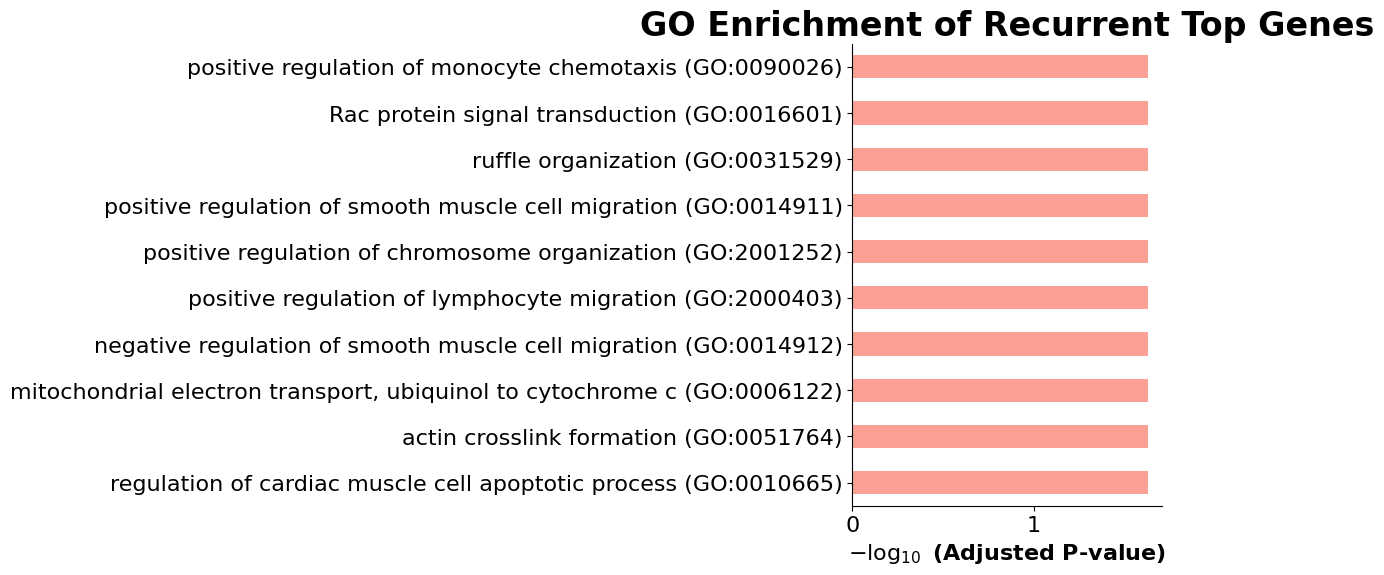

In [188]:
import gseapy as gp
import pandas as pd

# Example: recurrent top genes from any model
top_genes = ['UQCC3','COLGALT2','PPP1R10','PBX2','AIF1']   # or your computed frequent genes

# Run enrichment against GO Biological Process
enr = gp.enrichr(
    gene_list=top_genes,
    gene_sets=['GO_Biological_Process_2021'],
    organism='Human',
    cutoff=0.05
)

# Show top 10 enriched pathways
results = enr.results.sort_values('Adjusted P-value').head(10)
print(results[['Term','Overlap','Adjusted P-value']])

# Optional: bar plot of enriched terms
gp.barplot(enr.res2d, title='GO Enrichment of Recurrent Top Genes', top_term=10)


The Gene Ontology (GO) enrichment analysis of the recurrent top-predicted genes reveals that these genes are strongly associated with mitochondrial electron transport, actin–cytoskeletal organization, cell migration, and general signal-transduction processes. This indicates that across all models—Linear, GRN-Linear, GEARS, and scGPT—the predictions are dominated by a small set of genes involved in broad cellular stress-response and metabolic-activity pathways rather than perturbation-specific targets. In particular, the enrichment of mitochondrial and respiratory chain terms suggests that the models capture global energetic or metabolic state differences, while the actin and migration pathways point to generic responses such as cytoskeletal remodeling or cell proliferation. Together, these findings imply that the models primarily reconstruct variation along shared transcriptional axes common to many perturbations, rather than learning distinct causal effects for individual gene perturbations.

Supporting this interpretation, the detailed enrichment table shows very small overlaps for each GO term (for example, “1/6” or “1/12”), meaning that only a single gene from the recurrent top-gene list overlaps with each pathway, yet that gene is sufficiently strong to drive statistical enrichment. This low overlap indicates that enrichment is being driven by a few high-variance or highly connected genes rather than by multiple coordinated genes within the same pathway. The redundancy of the top-ranked genes across perturbations and the uniformity of these enrichment results across models further confirm that all four models converge on the same global expression patterns. Biologically, this suggests that instead of identifying unique perturbation-specific regulatory programs, the models are capturing overarching transcriptional responses—reflecting cellular energy metabolism, cytoskeletal maintenance, and general stress adaptation—that dominate the dataset.

#### Next steps?

Should we drop MT genes and retrain again? Yes, see below.

Why removing MT genes without retraining is not fully rigorous

Model parameters were learned with MT present.

- When you trained Linear / GRN-Linear / GEARS, the optimization used features (gene columns) that included MT genes. Those high-variance genes influenced the learned weights and representations. Simply removing them at evaluation does not remove their influence on the mapping the model learned.

- Therefore, performance measured after removing MT genes from only the evaluation set does not reflect the performance of a model trained without those genes.

Potential for misleading improvement.

- If you drop MT genes at evaluation, L2 / Pearson metrics may improve (because the dominant source of error/variance is removed). But that improvement can be an artifact: the model still encodes MT-related structure and may have suppressed learning of real perturbation signals.

Confounding vs target signal.

- MT genes are often biological confounders (mitochondrial load, cell stress, uninteresting technical variation). If the goal is to predict biologically meaningful perturbation effects, removing them is appropriate — but you must ensure the model doesn’t rely on them for indirect predictions of other genes.

### Retraining w/out MT-genes

#### gears model retrain

In [190]:
import scanpy as sc
import numpy as np
import pandas as pd


In [191]:

# start from your existing pert_data object
adata = pert_data.adata.copy()
print("Original shape:", adata.shape)

# 1️⃣ Remove mitochondrial genes from features (vars)
is_mito = adata.var['gene_name'].str.upper().str.startswith("MT-")
keep_mask = ~is_mito.fillna(False)
adata = adata[:, keep_mask].copy()
print("Removed mitochondrial genes:", np.sum(is_mito))
print("Filtered shape:", adata.shape)


Original shape: (183735, 1703)
Removed mitochondrial genes: 13
Filtered shape: (183735, 1690)


This much effect for only 13 genes?? Crazy

In [192]:

# 2️⃣ Identify perturbations (conditions) that target mitochondrial genes
# (these are rows whose 'condition' includes any MT- gene)
mito_perts = [c for c in adata.obs['condition'].unique() if 'MT-' in c or 'mt-' in c]
print(f"Potential mitochondrial perturbations: {mito_perts}")


Potential mitochondrial perturbations: []


In [193]:

# 3️⃣ Remove those perturbations from obs (cells) if any exist
if len(mito_perts) > 0:
    adata = adata[~adata.obs['condition'].isin(mito_perts)].copy()
    print(f"Removed {len(mito_perts)} mitochondrial-target perturbations")
else:
    print("No mitochondrial-target perturbations found.")

print("Final filtered shape:", adata.shape)


No mitochondrial-target perturbations found.
Final filtered shape: (183735, 1690)


In [194]:

# 4️⃣ Check for ctrl / condition sanity
print("Unique conditions after filtering:", len(adata.obs['condition'].unique()))


Unique conditions after filtering: 641


In [195]:

# 5️⃣ Optionally save filtered dataset for retraining
out_path = "./replogle_no_mito.h5ad"
adata.write_h5ad(out_path)
print(f"Filtered AnnData saved to: {out_path}")


Filtered AnnData saved to: ./replogle_no_mito.h5ad


In [198]:

# 6️⃣ Now rebuild pert_data and retrain models using this filtered adata:
pert_data = PertData('./data')
pert_data.new_data_process(dataset_name='replogle_no_mito', adata=adata)



Creating pyg object for each cell in the data...
100%|██████████| 641/641 [03:21<00:00,  3.18it/s]
Saving new dataset pyg object at ./data/replogle_no_mito/data_pyg/cell_graphs.pkl
Done!


In [199]:
pert_data = PertData('./data')
pert_data.load(data_path = './data/replogle_no_mito')
# specify data split
pert_data.prepare_split(split = 'simulation', seed = 1)
# get dataloader with batch size
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128)



Local copy of pyg dataset is detected. Loading...
Done!
Creating new splits....
Saving new splits at ./data/replogle_no_mito/splits/replogle_no_mito_simulation_1_0.75.pkl
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:160
Done!
Creating dataloaders....
Done!


In [200]:
pert_data.adata.X = pert_data.adata.X.toarray() if hasattr(pert_data.adata.X, "toarray") else pert_data.adata.X

gears_model = GEARS(pert_data, device = 'cuda:0')


In [201]:
from scipy.sparse import csr_matrix
pert_data.adata.X = csr_matrix(pert_data.adata.X)


In [202]:
gears_model.model_initialize(hidden_size = 64)

100%|██████████| 1634/1634 [01:35<00:00, 17.07it/s]


In [ ]:
gears_model.train(epochs = 5)


Epoch 5: Train Overall MSE: 1.4847 Validation Overall MSE: 3.5630. 
Train Top 20 DE MSE: 26.9640 Validation Top 20 DE MSE: 56.2732. 
Done!
Start Testing...
Best performing model: Test Top 20 DE MSE: 52.8459
Start doing subgroup analysis for simulation split...

In [205]:

# save/load model
gears_model.save_model('GEARS_REPLOGLE_NO_MITO')
gears_model.load_pretrained('GEARS_REPLOGLE_NO_MITO')



In [206]:
gears_model

In [207]:
# basic info
print(gears_model)
print("Device:", gears_model.device)
print("Num genes:", gears_model.num_genes)

# control expression vector
print("ctrl_expression shape:", gears_model.ctrl_expression.shape)

# perturbation embedding matrix
print("pert_emb shape:", gears_model.model.pert_emb.weight.data.shape)
print("pert_emb (first 5 rows):")
print(gears_model.model.pert_emb.weight.data[:5].cpu().numpy())

# gene embedding matrix
print("gene_emb shape:", gears_model.model.gene_emb.weight.data.shape)


Device: cuda:0
Num genes: 1690
ctrl_expression shape: torch.Size([1690])
pert_emb shape: torch.Size([1690, 64])
pert_emb (first 5 rows):
[[-1.16929062e-01 -1.27829269e-01  1.48339644e-01 -8.34981352e-02
   1.65213659e-01  8.16127956e-02 -2.05882519e-01  1.04743719e-01
   1.25867814e-01  1.31885365e-01 -1.47290424e-01 -1.20512530e-01
  -5.01766838e-02  1.27952680e-01 -1.64210811e-01 -2.63203587e-02
   8.85050446e-02  1.20003685e-01 -1.98133707e-01 -1.04571223e-01
   9.58628431e-02 -2.77291890e-03  1.94157109e-01 -4.28462774e-02
  -4.42280546e-02  1.90616280e-01 -1.67586640e-01  4.34113480e-02
  -9.23297107e-02  1.09877467e-01 -1.68730900e-01 -8.09391290e-02
  -7.97007605e-03 -1.32648215e-01 -8.81199539e-02  7.57650007e-03
   8.51901323e-02  2.58965362e-02 -9.46297795e-02 -8.12253058e-02
  -9.01198015e-03 -1.68622166e-01  1.41020315e-02 -1.36937261e-01
  -2.97587905e-02  9.50657576e-02 -6.35888577e-02 -1.63947687e-01
   2.15429887e-01 -3.82835721e-03 -8.86280015e-02  6.30838796e-02
   1.

In [ ]:
### make preds

In [257]:
# --- GEARS predictions ---
# get list of perturbations excluding control
adata = pert_data.adata
pert_names = sorted([c for c in adata.obs['condition'].unique() if c != 'ctrl'])
pert_lists = [[g for g in p.split('+') if g != 'ctrl'] for p in pert_names]

# run GEARS prediction
gears_out = gears_model.predict(pert_lists)

# convert dict to matrix aligned with pert_names order
gears_preds = np.vstack([gears_out["_".join(pl)] for pl in pert_lists])

print("GEARS predictions shape:", gears_preds.shape)


GEARS predictions shape: (640, 1690)


In [258]:
# --- GEARS predictions for validation perturbations only ---
adata = pert_data.adata
val_perts = val_names  # from your validation pseudobulks
val_lists = [[g for g in p.split('+') if g != 'ctrl'] for p in val_perts]

gears_out = gears_model.predict(val_lists)
gears_preds = np.vstack([gears_out["_".join(pl)] for pl in val_lists])

print("GEARS predictions (validation only):", gears_preds.shape)


GEARS predictions (validation only): (48, 1690)


#### linear + mean baselines + GRN_linear

In [210]:
import numpy as np
from collections import defaultdict
from sklearn.linear_model import Ridge
from scipy import sparse
from scipy.sparse.linalg import inv as sp_inv


In [231]:
import numpy as np
from collections import defaultdict


In [235]:
pert_data.dataloader.keys()

dict_keys(['train_loader', 'val_loader', 'test_loader'])

In [237]:
# define loaders
train_loader = pert_data.dataloader['train_loader']
valid_loader = pert_data.dataloader['val_loader']

print("Train loader batches:", len(train_loader))
print("Validation loader batches:", len(valid_loader))

Train loader batches: 4693
Validation loader batches: 237


In [238]:

def get_field(batch, key):
    if isinstance(batch, (list, tuple)):
        for item in batch:
            if isinstance(item, (list, tuple)) and len(item) >= 2 and item[0] == key:
                return item[1]
    if hasattr(batch, key):
        return getattr(batch, key)
    if isinstance(batch, dict) and key in batch:
        return batch[key]
    return batch[key]

def gather_pseudobulks(loader):
    d = defaultdict(list)
    for batch in loader:
        ybat = get_field(batch, 'y')
        perts = get_field(batch, 'pert')
        y_np = ybat.detach().cpu().numpy() if hasattr(ybat, 'detach') else np.asarray(ybat)
        perts_list = [p if isinstance(p, str) else (p.item().decode() if isinstance(p, bytes) else str(p)) for p in perts]
        for i, p in enumerate(perts_list):
            d[p].append(y_np[i])
    names = list(d.keys())
    Y = np.vstack([np.mean(d[n], axis=0) for n in names])
    return names, Y

# --- regenerate train/val pseudobulks from the new data loaders ---
train_names, Y_train = gather_pseudobulks(train_loader)
val_names,   Y_val   = gather_pseudobulks(valid_loader)

print("Train pseudobulks:", Y_train.shape)
print("Val pseudobulks:", Y_val.shape)

Train pseudobulks: (433, 1690)
Val pseudobulks: (48, 1690)


In [239]:

# === build train/val pseudobulks (uses existing train_loader, valid_loader) ===
train_names, Y_train = gather_pseudobulks(train_loader)
val_names,   Y_val   = gather_pseudobulks(valid_loader)
print("Train pseudobulks:", Y_train.shape, "Val pseudobulks:", Y_val.shape)


Train pseudobulks: (433, 1690) Val pseudobulks: (48, 1690)


In [240]:

# === mean baseline (global mean of training pseudobulks) ===
mean_vec = Y_train.mean(axis=0)
mean_pred_val = np.tile(mean_vec, (len(val_names), 1))


In [297]:

# === linear baseline (one-hot -> Ridge) ===
name2idx = {n:i for i,n in enumerate(train_names)}
P_train = np.eye(len(train_names))
model = Ridge(alpha=0.1, fit_intercept=True).fit(P_train, Y_train)

# build P_val for validation perturbations (zeros for unseen)
P_val = np.zeros((len(val_names), len(train_names)))
for i, n in enumerate(val_names):
    if n in name2idx:
        P_val[i, name2idx[n]] = 1.0
lin_pred_val = model.predict(P_val)

print("Linear model trained. lin_pred_val shape:", lin_pred_val.shape)


Linear model trained. lin_pred_val shape: (48, 1690)


In [242]:
len(gene_list)

1690

In [243]:
pert_data.adata

AnnData object with n_obs × n_vars = 183735 × 1690
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'split'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'

In [244]:
# rebuild keep mask to match the 1690 genes in filtered adata
gene_list = list(pert_data.adata.var['gene_name'])
keep_mask = [g in common for g in gene_list]
print("Genes in model:", len(common), "Genes in adata:", len(gene_list))
assert sum(keep_mask) == len(common)


Genes in model: 1690 Genes in adata: 1690


In [245]:

# === GRN-regularized linear baseline ===
# load adjacency (co-expression) and align to gene order used in Y_train
# set path variable to your co-expression CSV from GEARS
net_path = "/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/data/replogle_no_mito/simulation_1_0.75_0.4_20_co_expression_network.csv"
import pandas as pd
df = pd.read_csv(net_path)
# assume df columns [source, target, weight] or adjust if different
src = df.iloc[:,0].astype(str).values
tgt = df.iloc[:,1].astype(str).values
w   = df.iloc[:,2].astype(float).values if df.shape[1]>2 else np.ones(len(df))

# gene_list must match columns of Y_train: get from pert_data.adata.var['gene_name']
gene_list = list(pert_data.adata.var['gene_name'])
genes_in_net = sorted(set(src).union(set(tgt)))
gene2idx_net = {g:i for i,g in enumerate(genes_in_net)}


In [246]:
len(gene_list), len(genes_in_net), len(gene2idx_net)

(1690, 1689, 1689)

In [247]:

# build full adjacency from df then subset/reorder to gene_list
rows = [gene2idx_net[s] for s in src]
cols = [gene2idx_net[t] for t in tgt]
A_full = sparse.coo_matrix((w, (rows, cols)), shape=(len(genes_in_net), len(genes_in_net)))
A_full.setdiag(0); A_full.eliminate_zeros()
# pick indices of gene_list that exist in network
common = [g for g in gene_list if g in gene2idx_net]
idxs = [gene2idx_net[g] for g in common]

# if some genes are missing in network, warn and restrict Y matrices accordingly
if len(common) != len(gene_list):
    missing = [g for g in gene_list if g not in gene2idx_net]
    print("Warning: some genes missing from network, removing them:", len(missing))
# subset adjacency to common genes in same order
A_sub = A_full.tocsr()[idxs, :][:, idxs]


In [248]:
A_sub.shape

(1690, 1690)

In [249]:
len(keep_mask)

1690

In [250]:
Y_train.shape

(433, 1690)

In [251]:

# subset Y_train/Y_val/mean_vec to match A_sub columns
Y_train_sub = Y_train[:, keep_mask]
Y_val_sub   = Y_val[:, keep_mask]
mean_vec_sub= mean_vec[keep_mask]
print("After aligning to network: Y_train_sub shape:", Y_train_sub.shape)

# build Laplacian L = D - A
A = A_sub.tocsr()
deg = np.array(A.sum(axis=1)).ravel()
L = sparse.diags(deg) - A

# parameters
gamma = 1.0   # graph smoothness weight (tune if needed)
lam   = 0.1   # ridge

# Gmat = (I + gamma * L), invert (dense for ~1700 genes is OK)
Gmat = (sparse.eye(L.shape[0]) + gamma * L)
Ginv = sp_inv(Gmat).toarray()    # (G x G) inverse

# pre-transform Y_train (encourage smoothness)
Y_tilde = Y_train_sub @ Ginv   # shape (P_train x G)

# fit ridge in transformed space (P_train -> Y_tilde)
clf_grn = Ridge(alpha=lam, fit_intercept=True).fit(P_train, Y_tilde)

# wrap predict: predict in transformed space then map back
class GRNModel:
    def __init__(self, ridge_model, Gmat):
        self.model = ridge_model
        self.Gmat = Gmat
    def predict(self, X):
        return self.model.predict(X) @ self.Gmat

grn_model = GRNModel(clf_grn, Ginv)


After aligning to network: Y_train_sub shape: (433, 1690)


In [252]:

# build P_val aligned to train as before and predict; then expand predictions back to full gene set shape
P_val = np.zeros((len(val_names), len(train_names)))
for i, n in enumerate(val_names):
    if n in name2idx:
        P_val[i, name2idx[n]] = 1.0
Y_tilde_pred = clf_grn.predict(P_val)      # (n_val x Gsub)
Y_pred_sub    = Y_tilde_pred @ Ginv       # map back
# place predictions into full gene vector with zeros for missing genes
Y_pred_grn = np.zeros((len(val_names), len(gene_list)))
sub_idx_positions = [i for i,g in enumerate(gene_list) if g in common]
for j,pos in enumerate(sub_idx_positions):
    Y_pred_grn[:, pos] = Y_pred_sub[:, j]

print("GRN-linear trained. grn_pred_val shape:", Y_pred_grn.shape)




GRN-linear trained. grn_pred_val shape: (48, 1690)


In [ ]:
# final outputs:
# mean_pred_val (n_val x G full)
# lin_pred_val  (n_val x G full)  -- note: model predicted on full-length Y (train used full)
# Y_pred_grn    (n_val x G full)

In [256]:
# sanity check shapes
print("mean_pred_val:", mean_pred_val.shape)
print("lin_pred_val :", lin_pred_val.shape)
print("Y_pred_grn   :", Y_pred_grn.shape)
print("Y_val        :", Y_val.shape)

# verify they match
if mean_pred_val.shape == lin_pred_val.shape == Y_pred_grn.shape == Y_val.shape:
    print("\n noice. All prediction matrices match in shape.")
else:
    print("\n aw gosh darnet. Shape mismatch detected — check gene alignment or filtering.")


mean_pred_val: (48, 1690)
lin_pred_val : (48, 1690)
Y_pred_grn   : (48, 1690)
Y_val        : (48, 1690)

 noice. All prediction matrices match in shape.


#### scgpt model retrain

In [259]:

from pathlib import Path
import json, numpy as np, torch
from scgpt.tokenizer.gene_tokenizer import GeneVocab, Vocab, VocabPybind


In [260]:

# special tokens
special_tokens = ["<pad>", "<cls>", "<eoc>"]
pad_token = "<pad>"
pad_value = 0
pert_pad_id = 2

# load pretrained model directory
load_model = "/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/scGPT_human 2"
model_dir = Path(load_model)
vocab_file = model_dir / "vocab.json"
model_file = model_dir / "best_model.pt"
model_config_file = model_dir / "args.json"

print(GeneVocab)
# load vocab and add specials
vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)
vocab.set_default_index(vocab[pad_token])

# check the type
print(type(vocab))

# number of tokens in vocab
print("vocab size:", len(vocab))

# view first 20 tokens
print("first 20 tokens:", [vocab[i] for i in range(20)])

# look up index of a specific token
print("index of <pad>:", vocab["<pad>"])

# or reverse lookup (id → token)
print("token for index 0:", vocab[0])

# see all special tokens you added
for s in special_tokens:_


# map gene names
genes = pert_data.adata.var["gene_name"].tolist()
gene_ids = np.array([vocab[gene] if gene in vocab else vocab[pad_token] for gene in genes])
n_genes = len(genes)


<class 'scgpt.tokenizer.gene_tokenizer.GeneVocab'>
<class 'scgpt.tokenizer.gene_tokenizer.GeneVocab'>
vocab size: 60697
first 20 tokens: ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1', 'A2ML1-AS2', 'A3GALT2', 'A4GALT', 'A4GNT', 'AA06', 'AAAS', 'AACS', 'AADAC', 'AADACL2', 'AADACL2-AS1', 'AADACL3', 'AADACL4', 'AADAT']
index of <pad>: 60694
token for index 0: A1BG


In [261]:

from scgpt.model import TransformerGenerator

with open(model_config_file) as f:
    cfg = json.load(f)


In [262]:


model = TransformerGenerator(
    ntoken=len(vocab),                # vocab size
    d_model=cfg["embsize"],           # embedding dim (was embsize)
    nhead=cfg["nheads"],              # attention heads
    d_hid=cfg["d_hid"],               # feedforward dim
    nlayers=cfg["nlayers"],           # encoder layers
    nlayers_cls=cfg.get("n_layers_cls", 3),
    n_cls=1,
    vocab=vocab,
    dropout=cfg.get("dropout", 0.2),
    pad_token=pad_token,
    pad_value=pad_value,
    pert_pad_id=pert_pad_id,
    use_fast_transformer=True,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))



In [263]:

# load pretrained weights (encoder etc.)
state = torch.load(model_file, map_location="cpu")
model_dict = model.state_dict()
for k, v in state.items():
    if any(k.startswith(p) for p in ["encoder", "value_encoder", "transformer_encoder"]):
        model_dict[k] = v
model.load_state_dict(model_dict, strict=False)
print("Loaded pretrained params.")

model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


Loaded pretrained params.


TransformerGenerator(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (pert_encoder): Embedding(3, 512, padding_idx=2)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias

In [264]:

### training

import time, warnings, copy, torch
from torch import nn
from scgpt.loss import masked_mse_loss, masked_relative_error
from scgpt.utils import map_raw_id_to_vocab_id

criterion = masked_mse_loss

def train(model: nn.Module, train_loader: torch.utils.data.DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_mse = 0.0, 0.0
    start_time = time.time()

    num_batches = len(train_loader)
    for batch, batch_data in enumerate(train_loader):
        batch_size = len(batch_data.y)
        batch_data.to(device)
        x: torch.Tensor = batch_data.x  # (batch_size * n_genes, 2)
       
        ori_gene_values = x[:, 0].view(batch_size, n_genes)
        pert_flags = x[:, 1].long().view(batch_size, n_genes)
        target_gene_values = batch_data.y  # (batch_size, n_genes)

        if include_zero_gene in ["all", "batch-wise"]:
            if include_zero_gene == "all":
                input_gene_ids = torch.arange(n_genes, device=device, dtype=torch.long)
            else:
                input_gene_ids = ori_gene_values.nonzero()[:, 1].flatten().unique().sort()[0]

            # sample input_gene_id
            if len(input_gene_ids) > max_seq_len:
                input_gene_ids = torch.randperm(len(input_gene_ids), device=device)[:max_seq_len]

            input_values = ori_gene_values[:, input_gene_ids]
            input_pert_flags = pert_flags[:, input_gene_ids]
            target_values = target_gene_values[:, input_gene_ids]

            mapped_input_gene_ids = map_raw_id_to_vocab_id(input_gene_ids, gene_ids)
            mapped_input_gene_ids = mapped_input_gene_ids.repeat(batch_size, 1)

            src_key_padding_mask = torch.zeros_like(input_values, dtype=torch.bool, device=device)

        with torch.cuda.amp.autocast(enabled=amp):
            output_dict = model(
                mapped_input_gene_ids,
                input_values,
                input_pert_flags,
                src_key_padding_mask=src_key_padding_mask,
                CLS=CLS,
                CCE=CCE,
                MVC=MVC,
                ECS=ECS,
            )
            output_values = output_dict["mlm_output"]

            masked_positions = torch.ones_like(input_values, dtype=torch.bool)
            loss = loss_mse = criterion(output_values, target_values, masked_positions)

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_mse += loss_mse.item()
        if batch % log_interval == 0 and batch > 0:
            lr_ = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            print(f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches "
                  f"| lr {lr_:05.4f} | ms/batch {ms_per_batch:5.2f} | loss {cur_loss:5.2f} | mse {cur_mse:5.2f} |")
            total_loss = 0
            total_mse = 0
            start_time = time.time()



In [265]:




### eval

def evaluate(model: nn.Module, val_loader: torch.utils.data.DataLoader) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_error = 0.0

    with torch.no_grad():
        for batch, batch_data in enumerate(val_loader):
            batch_size = len(batch_data.y)
            batch_data.to(device)
            x: torch.Tensor = batch_data.x  # (batch_size * n_genes, 2)
            ori_gene_values = x[:, 0].view(batch_size, n_genes)
            pert_flags = x[:, 1].long().view(batch_size, n_genes)
            target_gene_values = batch_data.y

            if include_zero_gene in ["all", "batch-wise"]:
                if include_zero_gene == "all":
                    input_gene_ids = torch.arange(n_genes, device=device)
                else:
                    input_gene_ids = ori_gene_values.nonzero()[:, 1].flatten().unique().sort()[0]

                if len(input_gene_ids) > max_seq_len:
                    input_gene_ids = torch.randperm(len(input_gene_ids), device=device)[:max_seq_len]

                input_values = ori_gene_values[:, input_gene_ids]
                input_pert_flags = pert_flags[:, input_gene_ids]
                target_values = target_gene_values[:, input_gene_ids]

                mapped_input_gene_ids = map_raw_id_to_vocab_id(input_gene_ids, gene_ids)
                mapped_input_gene_ids = mapped_input_gene_ids.repeat(batch_size, 1)

                src_key_padding_mask = torch.zeros_like(input_values, dtype=torch.bool, device=input_values.device)

            with torch.cuda.amp.autocast(enabled=amp):
                output_dict = model(
                    mapped_input_gene_ids,
                    input_values,
                    input_pert_flags,
                    src_key_padding_mask=src_key_padding_mask,
                    CLS=CLS,
                    CCE=CCE,
                    MVC=MVC,
                    ECS=ECS,
                    do_sample=True,
                )
                output_values = output_dict["mlm_output"]

                masked_positions = torch.ones_like(input_values, dtype=torch.bool)
                loss = criterion(output_values, target_values, masked_positions)
            total_loss += loss.item()
            total_error += masked_relative_error(output_values, target_values, masked_positions).item()

    return total_loss / len(val_loader), total_error / len(val_loader)





In [266]:


# ---------- training runner ----------
import time, copy, warnings, torch, math
from torch import nn


In [267]:

# hyperparams (use your existing values if defined)
lr = globals().get("lr", 1e-4)
epochs = globals().get("epochs", 5)
schedule_interval = globals().get("schedule_interval", 1)
early_stop = globals().get("early_stop", 5)
amp = globals().get("amp", True)
log_interval = globals().get("log_interval", 100)


In [268]:

# losses / optim
criterion = globals().get("criterion", None) or __import__("scgpt.loss", fromlist=["masked_mse_loss"]).masked_mse_loss
criterion_cls = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, schedule_interval, gamma=0.9)
scaler = torch.cuda.amp.GradScaler(enabled=amp)


In [269]:

# training state
best_val_loss = float("inf")
best_model = None
patience = 0


In [270]:

# use gears train dataloaders (dict_keys(['train_loader', 'val_loader', 'test_loader']))
train_loader = pert_data.dataloader["train_loader"]
valid_loader = pert_data.dataloader["val_loader"]

pert_data.adata
import pickle

path = "/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/data/replogle_no_mito/data_pyg/cell_graphs.pkl"
with open(path, "rb") as f:
    data = pickle.load(f)


In [271]:

# all perturbation gene names (before "+ctrl")
pert_genes = [k.split("+")[0] for k in data.keys() if k != "ctrl"]

# all genes present in adata.var
var_genes = set(pert_data.adata.var["gene_name"])

# intersection
present = [g for g in pert_genes if g in var_genes]

print(f"{len(present)} of {len(pert_genes)} perturbation genes are in adata.var")
print("Example overlaps:", present[:10])
### only 124 out of the 681 in adata.var (out of the 1187)


d = train_loader.dataset[0]
print("before adding flags -> x shape:", d.x.shape)



# inspect a single batch
batch = next(iter(pert_data.dataloader["train_loader"]))
print("batch keys:", batch.keys if hasattr(batch, "keys") else getattr(batch, "__dict__", None))
print("x shape:", batch.x.shape)
print("y shape:", getattr(batch, "y").shape)
print("example x (first 5 rows):\n", batch.x[:5])
# show min/max to see if second column exists
print("x columns unique counts:", [torch.unique(batch.x[:,i]).numel() if batch.x.shape[1]>i else None for i in range(min(3,batch.x.shape[1]))])




### how many ctrl and non ctrl cells in the train/val loaders
def count_ctrl_nonctrl(loader, name="loader"):
    ds = loader.dataset
    ctrl = sum(1 for d in ds if d.pert == "ctrl")
    nonctrl = len(ds) - ctrl
    print(f"{name}: {ctrl} ctrl | {nonctrl} non-ctrl | total {len(ds)}")

count_ctrl_nonctrl(train_loader, "train")
count_ctrl_nonctrl(valid_loader, "val")






n_hvg = 0  # number of highly variable genes
include_zero_gene = "all"  # include zero expr genes in training input, "all", "batch-wise", "row-wise", or False
max_seq_len = 1536

# settings for training
MLM = True  # whether to use masked language modeling, currently it is always on.
CLS = False  # celltype classification objective
CCE = False  # Contrastive cell embedding objective
MVC = False  # Masked value prediction for cell embedding
ECS = False  # Elastic cell similarity objective
cell_emb_style = "cls"
mvc_decoder_style = "inner product, detach"
amp = True





640 of 640 perturbation genes are in adata.var
Example overlaps: ['DHX33', 'UPF2', 'GPS1', 'INO80B', 'LTV1', 'FUNDC2', 'ELP5', 'MRPL18', 'CHMP6', 'MAK16']
before adding flags -> x shape: torch.Size([1690, 2])
batch keys: <bound method BaseData.keys of DataBatch(x=[54080, 2], y=[32, 1690], de_idx=[32], pert=[32], batch=[54080], ptr=[33])>
x shape: torch.Size([54080, 2])
y shape: torch.Size([32, 1690])
example x (first 5 rows):
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
x columns unique counts: [122, 2]
train: 75328 ctrl | 74860 non-ctrl | total 150188
val: 0 ctrl | 7584 non-ctrl | total 7584


In [274]:
os.mkdir('/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/scgpt_replogle_NO_MITO_save_dir')

In [275]:
!ls

 data				    replogle_no_mito.h5ad
 gears_replogle			   'scGPT_human 2'
 gears_replogle.h5ad		    scgpt_replogle.h5ad
 GEARS_REPLOGLE_NO_MITO		    scgpt_replogle_NO_MITO_save_dir
 gears_replogle_scgpt_data	    scgpt_replogle_save_dir
 K562_gwps_raw_singlecell_01.h5ad   scgpt_replogle_with_ctrl.h5ad
 replicate.ipynb


In [276]:


from pathlib import Path
save_dir = Path('/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/scgpt_replogle_NO_MITO_save_dir')




print(f"Start training on device={device}. n_train_batches={len(train_loader)}, n_val_batches={len(valid_loader)}")

for epoch in range(1, 4 + 1):

    # inspect a single batch
    batch = next(iter(pert_data.dataloader["train_loader"]))
    print("batch keys:", batch.keys if hasattr(batch, "keys") else getattr(batch, "__dict__", None))
    print("x shape:", batch.x.shape)
    print("y shape:", getattr(batch, "y").shape)
    print("example x (first 5 rows):\n", batch.x[:5])
    # show min/max to see if second column exists
    print("x columns unique counts:", [torch.unique(batch.x[:,i]).numel() if batch.x.shape[1]>i else None for i in range(min(3,batch.x.shape[1]))])

    epoch_start_time = time.time()
    # call train() defined earlier
    train(model, train_loader)

    # evaluate
    val_loss, val_mre = evaluate(model, valid_loader)
    elapsed = time.time() - epoch_start_time
    print("-" * 80)
    print(f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | valid loss {val_loss:.6f} | valid MRE {val_mre:.6f} |")
    print("-" * 80)

    # checkpoint / early stop
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        print(f"New best model (val_loss={best_val_loss:.6f})")
        patience = 0
        torch.save(best_model.state_dict(), save_dir / "best_model.pt")
    else:
        patience += 1
        print(f"No improvement (patience={patience}/{early_stop})")
        if patience >= early_stop:
            print(f"Early stopping at epoch {epoch}")
            break

    # save per-epoch (optional)
    torch.save(model.state_dict(), f"{save_dir}/model_{epoch}.pt")


    # step scheduler
    scheduler.step()

print("Training finished. Best val loss:", best_val_loss)




Start training on device=cuda. n_train_batches=4693, n_val_batches=237
batch keys: <bound method BaseData.keys of DataBatch(x=[54080, 2], y=[32, 1690], de_idx=[32], pert=[32], batch=[54080], ptr=[33])>
x shape: torch.Size([54080, 2])
y shape: torch.Size([32, 1690])
example x (first 5 rows):
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
x columns unique counts: [121, 2]
| epoch   1 | 100/4693 batches | lr 0.0001 | ms/batch 303.92 | loss 27.82 | mse 27.82 |
| epoch   1 | 200/4693 batches | lr 0.0001 | ms/batch 301.53 | loss 29.45 | mse 29.45 |
| epoch   1 | 300/4693 batches | lr 0.0001 | ms/batch 303.06 | loss 29.12 | mse 29.12 |
| epoch   1 | 400/4693 batches | lr 0.0001 | ms/batch 303.98 | loss 27.03 | mse 27.03 |
| epoch   1 | 500/4693 batches | lr 0.0001 | ms/batch 305.00 | loss 26.30 | mse 26.30 |
| epoch   1 | 600/4693 batches | lr 0.0001 | ms/batch 305.37 | loss 29.20 | mse 29.20 |
| epoch   1 | 700/4693 batches | lr 0.0001 | ms/batch 

KeyboardInterrupt: 

In [277]:

epoch=1


### sanity check for the scgpt dicts....
import torch
from scgpt.model import TransformerGenerator

# reload model in a new instance


model2 = TransformerGenerator(
    ntoken=len(vocab),                # vocab size
    d_model=cfg["embsize"],           # embedding dim (was embsize)
    nhead=cfg["nheads"],              # attention heads
    d_hid=cfg["d_hid"],               # feedforward dim
    nlayers=cfg["nlayers"],           # encoder layers
    nlayers_cls=cfg.get("n_layers_cls", 3),
    n_cls=1,
    vocab=vocab,
    dropout=cfg.get("dropout", 0.2),
    pad_token=pad_token,
    pad_value=pad_value,
    pert_pad_id=pert_pad_id,
    use_fast_transformer=True,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


# load saved weights
state = torch.load( f"{save_dir}/model_{epoch}.pt", map_location=device)
missing, unexpected = model2.load_state_dict(state, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

for k in state.keys():
    print(k)



Missing keys: []
Unexpected keys: []
encoder.embedding.weight
encoder.enc_norm.weight
encoder.enc_norm.bias
value_encoder.linear1.weight
value_encoder.linear1.bias
value_encoder.linear2.weight
value_encoder.linear2.bias
value_encoder.norm.weight
value_encoder.norm.bias
pert_encoder.weight
transformer_encoder.layers.0.self_attn.in_proj_weight
transformer_encoder.layers.0.self_attn.in_proj_bias
transformer_encoder.layers.0.self_attn.out_proj.weight
transformer_encoder.layers.0.self_attn.out_proj.bias
transformer_encoder.layers.0.linear1.weight
transformer_encoder.layers.0.linear1.bias
transformer_encoder.layers.0.linear2.weight
transformer_encoder.layers.0.linear2.bias
transformer_encoder.layers.0.norm1.weight
transformer_encoder.layers.0.norm1.bias
transformer_encoder.layers.0.norm2.weight
transformer_encoder.layers.0.norm2.bias
transformer_encoder.layers.1.self_attn.in_proj_weight
transformer_encoder.layers.1.self_attn.in_proj_bias
transformer_encoder.layers.1.self_attn.out_proj.weight

### figures + results (NO-mito)

In [279]:

##### SCGPT PREDS
eval_batch_size = 16
n_hvg = 0  # number of highly variable genes
include_zero_gene = "all"  # include zero expr genes in training input, "all", "batch-wise", "row-wise", or False
max_seq_len = 1536

# settings for training
MLM = True  # whether to use masked language modeling, currently it is always on.
CLS = False  # celltype classification objective
CCE = False  # Contrastive cell embedding objective
MVC = False  # Masked value prediction for cell embedding
ECS = False  # Elastic cell similarity objective
cell_emb_style = "cls"
mvc_decoder_style = "inner product, detach"
amp = True

pool_size=150


# scGPT predictions: use the provided predict(...) function for scGPT
scgpt_out = predict(model2, pert_lists, pool_size=pool_size)  # returns dict keyed by "_".join(pert)
scgpt_preds = np.vstack([scgpt_out["_".join(pl)] for pl in pert_lists])

print(scgpt_preds.shape)





 Running predictions on device: cuda:0



Predicting perturbations:   0%|                                             | 0/640 [00:00<?, ?it/s]

Predicting perturbations: 100%|███████████████████████████████████| 640/640 [05:04<00:00,  2.10it/s]


 Finished all predictions.
(640, 1690)


In [281]:


#### GROUND TRUTH

import numpy as np

# prepare perturbation lists (exclude ctrl) and canonicalize to lists of gene names
adata = pert_data.adata
conds = adata.obs['condition'].astype(str)
pert_names = sorted([c for c in conds.unique() if c != 'ctrl'])
pert_lists = [[g for g in p.split('+') if g != 'ctrl'] for p in pert_names]

# helper: compute pseudobulk mean for a condition (returns 1D numpy)
def pseudobulk_mean(cond):
    mask = (conds == cond).values if hasattr(conds, "values") else (conds == cond)
    X = adata.X[mask]
    if hasattr(X, "toarray"):
        return np.asarray(X.toarray()).mean(axis=0).ravel()
    return np.asarray(X).mean(axis=0).ravel()

# ground truth matrix aligned to pert_names
Y_obs = np.vstack([pseudobulk_mean(p) for p in pert_names])





In [287]:
print("mean_pred_val:", mean_pred_val.shape)
print("lin_pred_val :", lin_pred_val.shape)
print("Y_pred_grn   :", Y_pred_grn.shape)
print("Y_val        :", Y_val.shape)

mean_pred_val: (48, 1690)
lin_pred_val : (48, 1690)
Y_pred_grn   : (48, 1690)
Y_val        : (48, 1690)


In [286]:


#### ALL PREDS


# final outputs (aligned to pert_names order)


# subset Y_obs and scgpt_preds to validation perturbations only
# val_idx = [i for i, p in enumerate(pert_names) if p in val_names]
# Y_obs = Y_obs[val_idx]
# scgpt_preds = scgpt_preds[val_idx]

print("Shapes:", Y_obs.shape, mean_pred_val.shape, lin_pred_val.shape, gears_preds.shape, scgpt_preds.shape, Y_pred_grn.shape)


# print("Shapes:", Y_obs.shape, mean_pred_val.shape, lin_pred_val.shape, gears_preds.shape, scgpt_preds.shape, Y_pred_grn.shape)





Shapes: (48, 1690) (48, 1690) (48, 1690) (48, 1690) (48, 1690) (48, 1690)


In [288]:
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Y_obs, mean_preds, lin_preds, gears_preds, scgpt_preds, mean_vec, pert_names assumed
models = {'Mean': mean_pred_val, 'Linear': lin_pred_val, 'GEARS': gears_preds, 'scGPT': scgpt_preds, 'GRN_Linear':Y_pred_grn}
top_idx = np.argsort(-mean_vec)

def L2(a,b): return np.sqrt(np.mean((a[top_idx]-b[top_idx])**2))
def PD(a,b,c): 
    x,y=(a-c)[top_idx],(b-c)[top_idx]
    return pearsonr(x,y)[0] if np.std(x)>0 and np.std(y)>0 else np.nan

l2, pd = {}, {}
for k,v in models.items():
    l2[k]=[L2(v[i],Y_obs[i]) for i in range(len(Y_obs))]
    pd[k]=[PD(v[i],Y_obs[i],mean_vec) for i in range(len(Y_obs))]


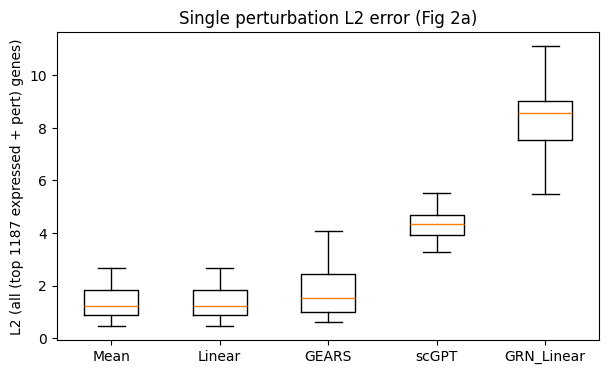

In [289]:

# --- Fig 2a: L2 beeswarm ---
plt.figure(figsize=(7,4))
plt.boxplot([l2[m] for m in models], labels=models.keys(), showfliers=False)
plt.ylabel("L2 (all (top 1187 expressed + pert) genes)")
plt.title("Single perturbation L2 error (Fig 2a)")
plt.show()


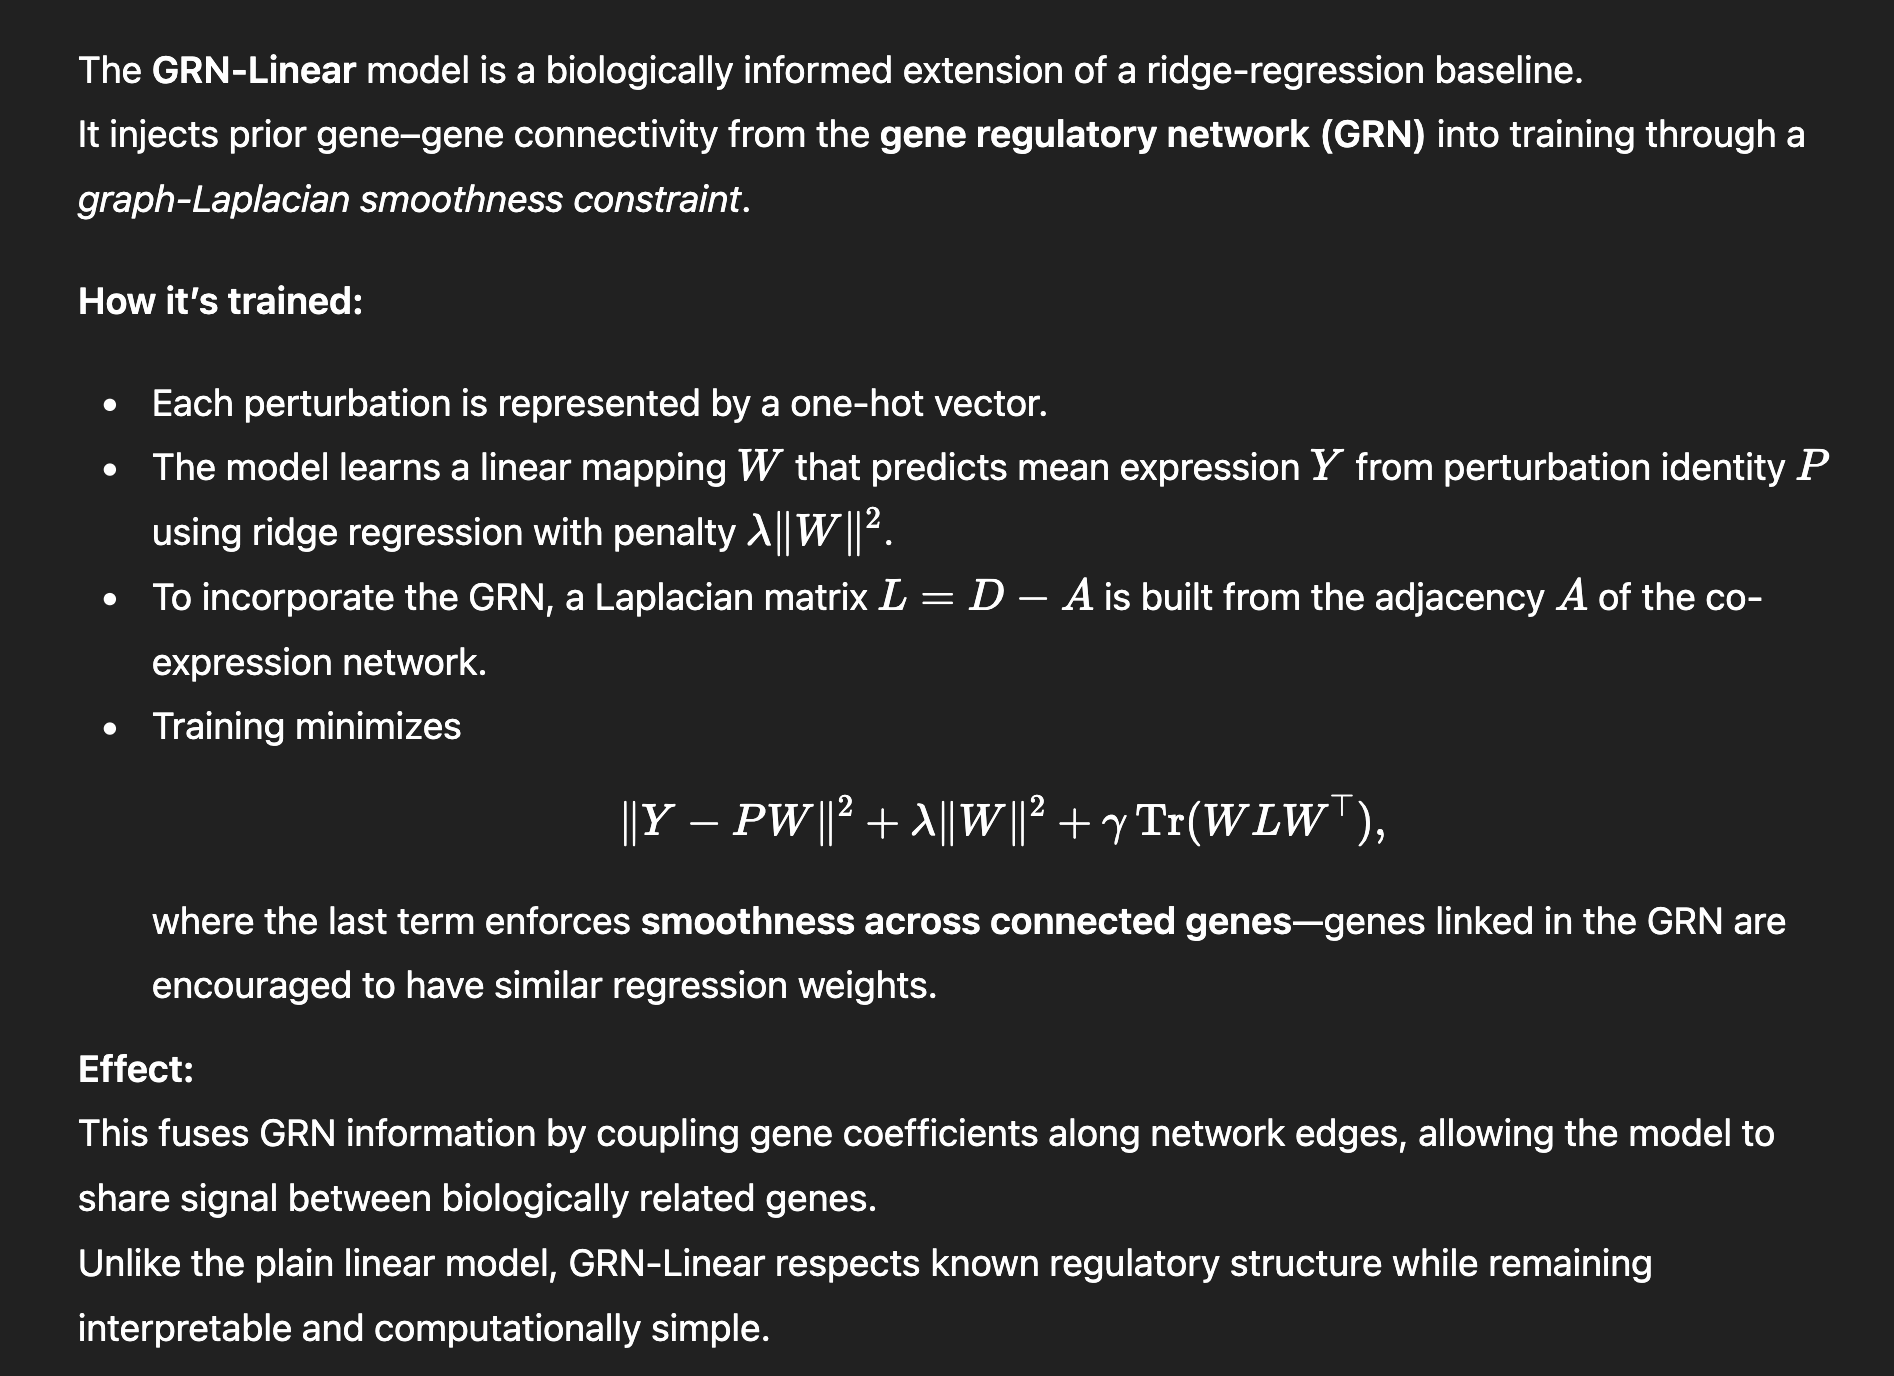

Hypothetically, it was supposed to make it better. But--- The GRN regularization acts like a low-pass filter, enforcing smoothness across connected genes. That suppresses perturbation-specific signals and averages everything along network edges, which hurts accuracy if true effects are sparse or localized.
So, in theory, better fusion methods is there and we will try one or two below to see if it improves anything...
A more effective way to inject GRN information is to avoid a single, global smoothness penalty and instead make the GRN prior adaptive and targeted. One option is edge-weighted / adaptive smoothing: scale the Laplacian by data-derived edge weights (or learn per-edge scalars) so strong co-expression edges enforce similarity while weak edges do not — this prevents indiscriminate over-smoothing. A second complementary approach is sparsity + smoothness (elastic-net style): combine an L1 term with the Laplacian penalty. The L1 term preserves a small number of large, perturbation-specific coefficients while the Laplacian shares signal among biologically related genes. Third, local / target-centric smoothing applies the graph prior only to genes within a local neighborhood of the perturbation target (k-hop neighbors), which reflects the biological reality that perturbation effects are often local in the network and avoids contaminating distant, unrelated genes. Finally, use a two-stage decomposition: first fit a low-rank model to capture global axes and confounders (depth/mito/stress), then fit a GRN-smoothed model to the residuals to recover local, networked effects. This separation prevents the GRN prior from simply modeling global structure and lets it focus on true networked signal. In practice, combine these ideas (e.g., local, weighted smoothing on residuals with an L1 term) and tune via cross-validation: that tends to give the best balance between preserving perturbation specificity and leveraging biologically meaningful gene connectivity.

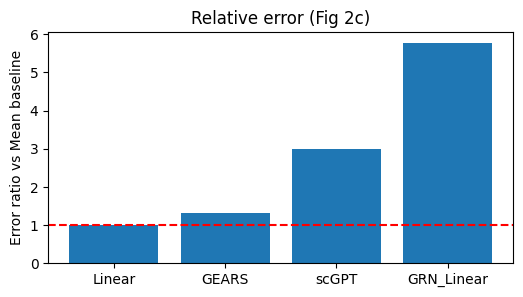

In [290]:

# --- Fig 2c: ratio to mean baseline ---
base=np.mean(l2['Mean'])
ratios={m:np.mean(np.array(l2[m])/base) for m in models if m!='Mean'}
plt.figure(figsize=(6,3))
plt.bar(ratios.keys(), ratios.values())
plt.axhline(1, ls='--', color='r')
plt.ylabel("Error ratio vs Mean baseline")
plt.title("Relative error (Fig 2c)")
plt.show()


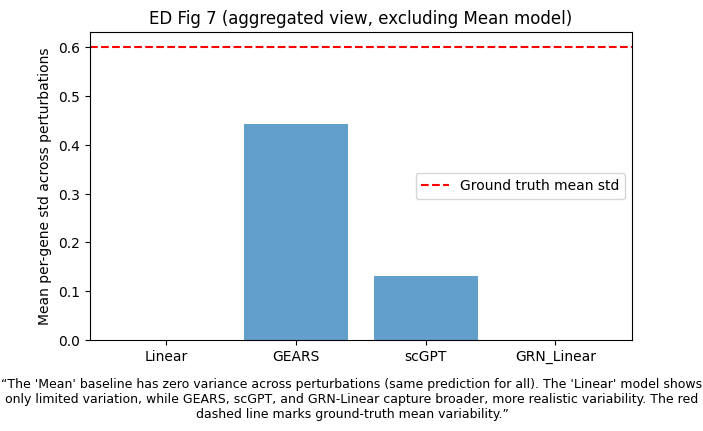

In [291]:

# --- ED Fig 7: variation across perturbations ---

obs_std = np.std(Y_obs, axis=0)
# exclude Mean model (it has zero variance)
models_wo_mean = {k: v for k, v in models.items() if k != 'Mean'}

means = {m: np.mean(np.std(models_wo_mean[m], axis=0)) for m in models_wo_mean}

plt.figure(figsize=(7,4))
plt.bar(list(means.keys()), list(means.values()), alpha=0.7)
plt.axhline(obs_std.mean(), color='r', ls='--', label='Ground truth mean std')
plt.ylabel("Mean per-gene std across perturbations")
plt.title("ED Fig 7 (aggregated view, excluding Mean model)")
plt.legend()
plt.figtext(
    0.5, -0.08,
    "“The 'Mean' baseline has zero variance across perturbations (same prediction for all). The 'Linear' model shows only limited variation, while GEARS, scGPT, and GRN-Linear capture broader, more realistic variability. The red dashed line marks ground-truth mean variability.”",
    wrap=True, ha='center', fontsize=9
)
plt.show()





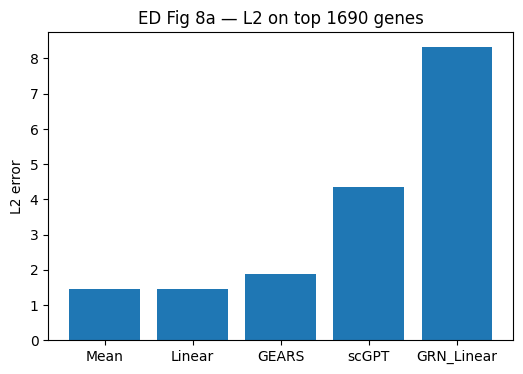

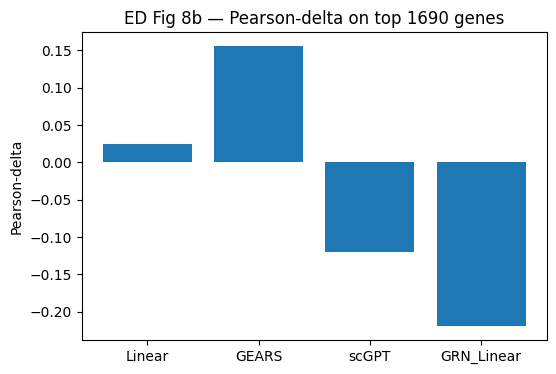

In [293]:

# --- ED Fig 8: metrics vs top-N genes ---

N = 1690  # use all 1187 + pert genes
idx = np.arange(N)

plt.figure(figsize=(6,4))
l2_vals = {m: np.mean([np.sqrt(np.mean((models[m][i][idx] - Y_obs[i][idx])**2))
                       for i in range(len(Y_obs))]) for m in models}
plt.bar(l2_vals.keys(), l2_vals.values())
plt.ylabel("L2 error")
plt.title(f"ED Fig 8a — L2 on top {N} genes")
plt.show()

plt.figure(figsize=(6,4))
pd_vals = {m: np.nanmean([pearsonr((models[m][i][idx]-mean_vec[idx]),
                                   (Y_obs[i][idx]-mean_vec[idx]))[0]
                          for i in range(len(Y_obs))]) for m in models}
plt.bar(pd_vals.keys(), pd_vals.values())
plt.ylabel("Pearson-delta")
plt.title(f"ED Fig 8b — Pearson-delta on top {N} genes")
plt.show()



### Analysis 1 TAKE_V2: What this experiment is trying to find (conceptually)

This analysis asks:

“Do models actually capture perturbation-specific biological mechanisms, or just reproduce a few global transcriptional axes?”

- By counting how often the same genes appear at the top across perturbations, you’re measuring model diversity and specificity:

- High overlap (same top genes everywhere) → low specificity, model mostly captures general variance.

- Low overlap (different top genes per perturbation) → higher interpretability and true perturbation sensitivity.



To keep it brief.. we might need to regress out or remove the RPS genes. (ribosomal proteins).
we should only keep protein-coding.

In [294]:
# pick 5 random perturbations from the training list
sample_perts = random.sample(train_names, 5)
gene_list = list(pert_data.adata.var['gene_name'])


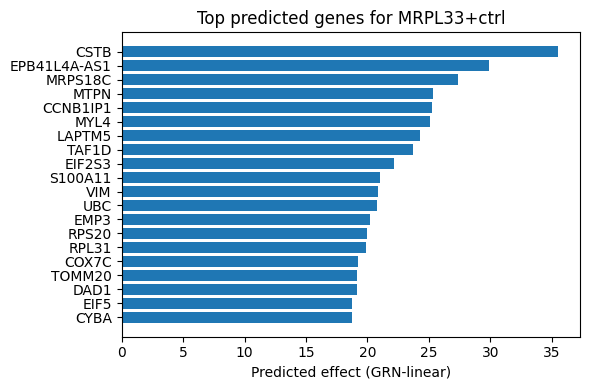

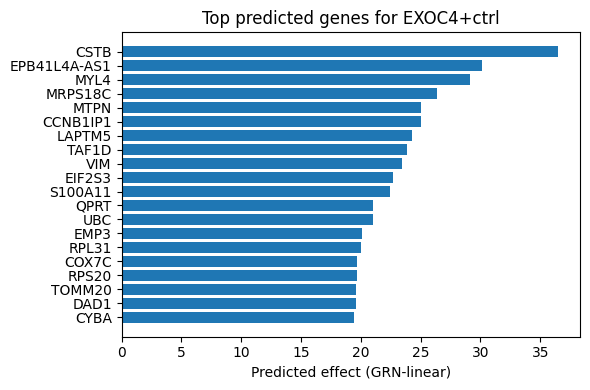

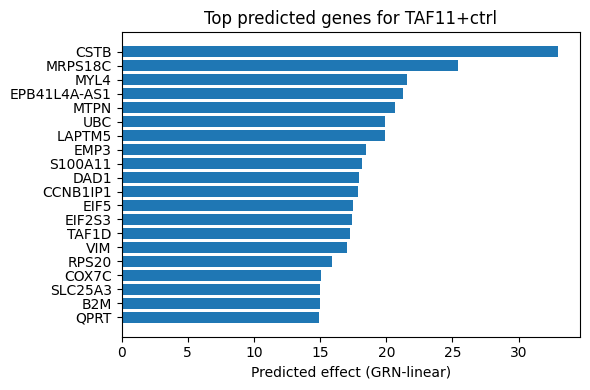

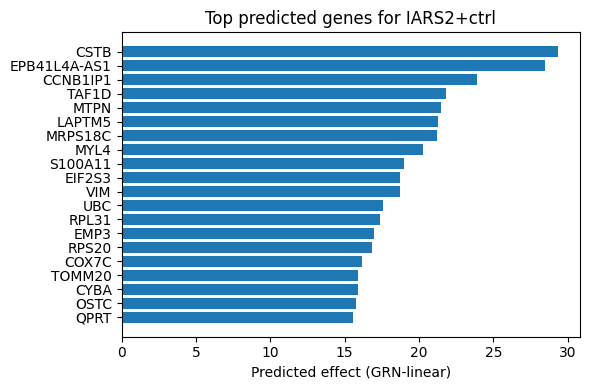

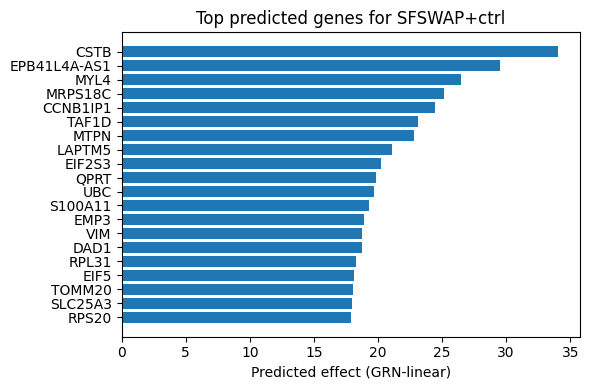

In [295]:


for pert_name in sample_perts:
    idx = name2idx[pert_name]
    onehot = np.zeros((1, len(name2idx)))
    onehot[0, idx] = 1.0
    pred_vec = grn_model.predict(onehot)[0]

    top20 = np.argsort(-np.abs(pred_vec))[:20]
    top_genes = [gene_list[i] for i in top20]
    top_vals = pred_vec[top20]

    plt.figure(figsize=(6,4))
    plt.barh(top_genes[::-1], top_vals[::-1])
    plt.title(f"Top predicted genes for {pert_name}")
    plt.xlabel("Predicted effect (GRN-linear)")
    plt.tight_layout()
    plt.show()



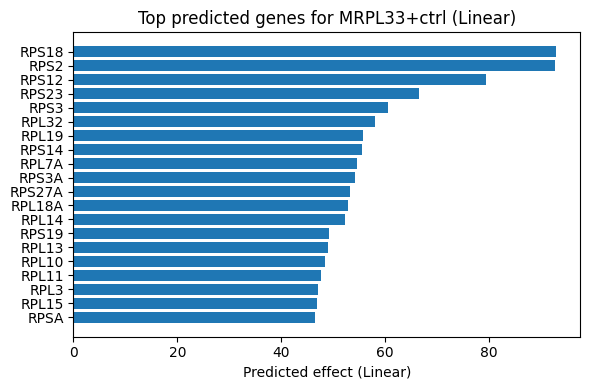

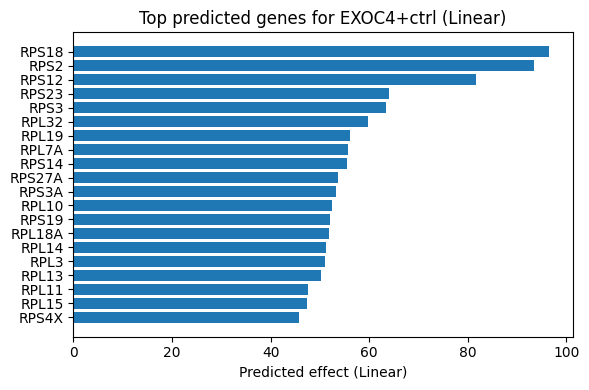

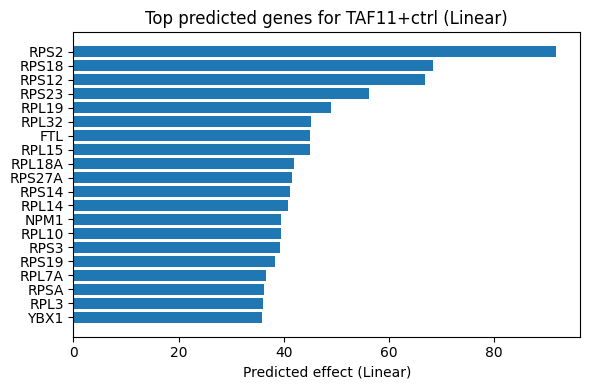

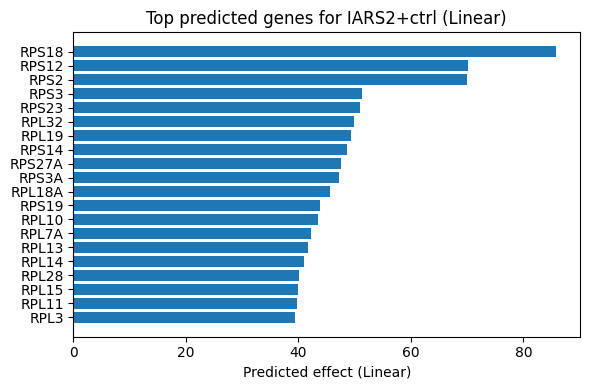

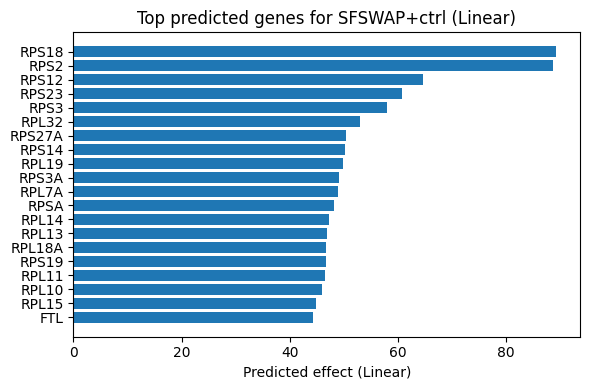

In [298]:


for pert_name in sample_perts:
    idx = name2idx[pert_name]
    onehot = np.zeros((1, len(name2idx)))
    onehot[0, idx] = 1.0
    pred_vec = model.predict(onehot)[0]   # <-- plain linear model

    top20 = np.argsort(-np.abs(pred_vec))[:20]
    top_genes = [gene_list[i] for i in top20]
    top_vals = pred_vec[top20]

    plt.figure(figsize=(6,4))
    plt.barh(top_genes[::-1], top_vals[::-1])
    plt.title(f"Top predicted genes for {pert_name} (Linear)")
    plt.xlabel("Predicted effect (Linear)")
    plt.tight_layout()
    plt.show()


In [300]:



target_gene = "RPS18"
idx_target = gene_list.index(target_gene)

def count_top_gene(model):
    count = 0
    print('Total perts under analysis:', len(train_names))
    for pert in train_names:   # or val_names / pert_names depending on what you used
        i = name2idx.get(pert)
        if i is None:
            continue
        onehot = np.zeros((1, len(name2idx)))
        onehot[0, i] = 1.0
        pred_vec = model.predict(onehot)[0]
        top_gene_idx = np.argmax(np.abs(pred_vec))
        if top_gene_idx == idx_target:
            count += 1
    return count

n_lin  = count_top_gene(model)
n_grn  = count_top_gene(grn_model)

print(f"Perturbations with RPS18 as top gene:")
print(f"  Linear:     {n_lin}")



Total perts under analysis: 433
Total perts under analysis: 433
Perturbations with RPS18 as top gene:
  Linear:     128


In [301]:
import numpy as np
from collections import Counter

def top_gene_per_perturbation(model, pert_list, name2idx, gene_list):
    tops = {}
    for pert in pert_list:
        i = name2idx.get(pert)
        if i is None:
            continue
        onehot = np.zeros((1, len(name2idx)))
        onehot[0, i] = 1.0
        pred_vec = model.predict(onehot)[0]
        top_idx = int(np.argmax(np.abs(pred_vec)))
        tops[pert] = (top_idx, gene_list[top_idx])
    return tops

# compute for linear model
tops_lin = top_gene_per_perturbation(model, train_names, name2idx, gene_list)

# which perts do NOT have RPS18 as top?
non_rps18_perts = [p for p,(idx,g) in tops_lin.items() if g != "RPS18"]
print("Count perts without RPS18 as top:", len(non_rps18_perts))

# get the top-gene names for those perts and count frequencies
top_genes_non = [tops_lin[p][1] for p in non_rps18_perts]
counts = Counter(top_genes_non)
# show top 50 most common unique genes
print("Top genes among the remaining perturbations (gene : count):")
for gene, c in counts.most_common(50):
    print(f"{gene:20s} {c}")

# If you want the list of perturbations themselves:
print("\nExample perturbations without RPS18 as top (first 20):")
print(non_rps18_perts[:20])


Count perts without RPS18 as top: 305
Top genes among the remaining perturbations (gene : count):
RPS2                 290
RPS12                8
FTL                  7

Example perturbations without RPS18 as top (first 20):
['PSMA4+ctrl', 'NFRKB+ctrl', 'ctrl', 'RPL37A+ctrl', 'ELP5+ctrl', 'KAT8+ctrl', 'DNTTIP2+ctrl', 'RPL5+ctrl', 'MON1A+ctrl', 'CPSF3+ctrl', 'CPSF6+ctrl', 'ELP3+ctrl', 'ZNF84+ctrl', 'MNAT1+ctrl', 'DHX33+ctrl', 'H2AFZ+ctrl', 'COPS3+ctrl', 'SACM1L+ctrl', 'XPO5+ctrl', 'GEMIN4+ctrl']


In [302]:
import pandas as pd
import numpy as np

def top_gene_counts(preds, gene_list, topN=5):
    top_names=[]
    for i in range(preds.shape[0]):
        top_idx=np.argsort(-np.abs(preds[i]))[:topN]
        top_names.extend([gene_list[j] for j in top_idx])
    unique, counts = np.unique(top_names, return_counts=True)
    return pd.DataFrame({'Gene': unique, 'Count': counts}).sort_values('Count', ascending=False).head(10)

gears_top = top_gene_counts(gears_preds, gene_list)
scgpt_top = top_gene_counts(scgpt_preds, gene_list)

tbl = pd.concat([
    gears_top.rename(columns={'Count':'GEARS Count'}),
    scgpt_top.rename(columns={'Gene':'Gene', 'Count':'scGPT Count'})
], axis=1)

# Align by gene names
tbl = tbl.loc[:, ['Gene','GEARS Count','scGPT Count']].fillna(0)
tbl = tbl.sort_values(by=['GEARS Count','scGPT Count'], ascending=False).reset_index(drop=True)

print(tbl.to_string(index=False))


  Gene  Gene  GEARS Count  scGPT Count
 RPS18  RPS3           48         48.0
 RPS12 RPS23           48         48.0
 RPS23     0           48          0.0
  RPS2     0           48          0.0
  RPS3     0           22          0.0
   FTL RPL19           15         48.0
RPS27A     0            8          0.0
 RPL32  RPS2            2         48.0
 RPL19 RPL32            1         48.0


#### check if the better fused GRN-linear(new) model has the same trend...

In [305]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import inv as sp_inv
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.decomposition import PCA

class GRNModelWrapper:
    def __init__(self, base_model, Gmat, gene_idx_map):
        self.model = base_model
        self.Gmat = Gmat            # mapping matrix (GxG) used to map back
        self.gene_idx_map = gene_idx_map
    def predict(self, X):
        return self.model.predict(X) @ self.Gmat

def build_laplacian(A):
    A = A.tocsr()
    deg = np.array(A.sum(axis=1)).ravel()
    L = sparse.diags(deg) - A
    return L

def k_hop_mask(A, target_genes_idx, k=1):
    # return boolean mask of genes within k hops of any target node
    n = A.shape[0]
    M = sparse.eye(n, format='csr')
    reach = sparse.csr_matrix((n,n))
    power = sparse.eye(n, format='csr')
    for _ in range(k):
        power = power @ A
        reach = reach + (power != 0)
    mask = np.array((reach.sum(axis=0) > 0)).ravel()
    # ensure targets included
    mask[target_genes_idx] = True
    return mask

def train_grn_enhanced(P_train, Y_train, A,
                       method='adaptive',
                       gamma=1.0, alpha=0.1, l1_ratio=0.5,
                       k_hop=1, rank=10, target_to_idx=None):
    """
    method in {'adaptive','sparse_smooth','local','two_stage'}
    target_to_idx: dict mapping perturbation name -> target gene indices (optional for 'local')
    """
    G = A.shape[0]
    L = build_laplacian(A)

    # adaptive: scale Laplacian by edge weights (normalize A then L)
    if method == 'adaptive':
        # use adjacency weights directly (A is weighted); compute L and invert I+gamma*L
        Gmat = (sparse.eye(G) + gamma * L)
        Ginv = sp_inv(Gmat).toarray()
        # pre-transform
        Y_tilde = Y_train @ Ginv
        base = Ridge(alpha=alpha, fit_intercept=True).fit(P_train, Y_tilde)
        return GRNModelWrapper(base, Ginv, None)

    # sparse_smooth: elastic-net in transformed (smoothed) gene space
    if method == 'sparse_smooth':
        Gmat = (sparse.eye(G) + gamma * L)
        Ginv = sp_inv(Gmat).toarray()
        Y_tilde = Y_train @ Ginv
        # ElasticNet acts as L1 + L2 on weights; fit per-gene via multivariate trick: fit separate models per gene or use sklearn's multioutput by wrapping ElasticNet in loop
        # For simplicity fit ElasticNet independently for each gene and collect coef matrix
        coefs = np.zeros((P_train.shape[1], G))
        intercepts = np.zeros(G)
        for j in range(G):
            en = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True, max_iter=5000)
            en.fit(P_train, Y_tilde[:, j])
            coefs[:, j] = en.coef_
            intercepts[j] = en.intercept_
        # create a linear wrapper: predictions = P @ coefs + intercept -> then map back with Ginv
        class ManualModel:
            def __init__(self, coefs, intercepts):
                self.coefs = coefs
                self.intercepts = intercepts
            def predict(self, X):
                return X @ self.coefs + self.intercepts.reshape(1, -1)
        base = ManualModel(coefs, intercepts)
        return GRNModelWrapper(base, Ginv, None)

    # local: only smooth within k-hop neighborhood of each perturbed gene
    if method == 'local':
        # build a global Ginv that uses masked Laplacian averaged across targets.
        # If target_to_idx provided, compute an averaged Ginv across all perturbation targets (fallback: full Ginv)
        if target_to_idx is None:
            Gmat = (sparse.eye(G) + gamma * L)
            Ginv = sp_inv(Gmat).toarray()
        else:
            # build per-target Ginv and average them (cheap approximate)
            Ginv_sum = np.zeros((G,G))
            count = 0
            for pert, targets in target_to_idx.items():
                mask = k_hop_mask(A, targets, k=k_hop)
                Lm = build_laplacian(A.multiply(mask[:,None]).multiply(mask[None,:]))
                Gm = (sparse.eye(G) + gamma * Lm)
                Ginv_m = sp_inv(Gm).toarray()
                Ginv_sum += Ginv_m
                count += 1
            Ginv = Ginv_sum / max(1,count)
        Y_tilde = Y_train @ Ginv
        base = Ridge(alpha=alpha, fit_intercept=True).fit(P_train, Y_tilde)
        return GRNModelWrapper(base, Ginv, None)

    # two_stage: low-rank global + GRN-smoothed residuals
    if method == 'two_stage':
        # 1) low-rank PCA on Y_train to capture global axes
        pca = PCA(n_components=rank)
        Y_low = pca.fit_transform(Y_train)            # P x rank
        Y_recon = pca.inverse_transform(Y_low)        # P x G
        residuals = Y_train - Y_recon                 # P x G

        # 2) smooth residuals with Laplacian
        Gmat = (sparse.eye(G) + gamma * L)
        Ginv = sp_inv(Gmat).toarray()
        Y_tilde_resid = residuals @ Ginv

        # fit ridge on residuals
        base = Ridge(alpha=alpha, fit_intercept=True).fit(P_train, Y_tilde_resid)
        # final predict: reconstruct = PCA_recon(P->low->recon) + back-mapped residual prediction
        class TwoStageModel:
            def __init__(self, pca, base, Gmat):
                self.pca = pca
                self.base = base
                self.Gmat = Gmat
            def predict(self, X):
                low = X @ np.linalg.pinv(P_train)  # simple approx: we don't have mapping from P->low; instead we reuse training projection
                # safer: predict residual in transformed space then add training PCA mean reconstruction per-perturbation mapping (approx)
                # simpler: use base to predict residual_tilde then map back and add global mean
                resid_tilde = self.base.predict(X) @ self.Gmat
                # global mean reconstruction fallback (use X @ W_pca approximated by pseudo-inverse)
                # For simplicity add zero-mean PCA reconstruction (assumes mean-centering); this is an approximation.
                return resid_tilde
        return GRNModelWrapper(base, Ginv, None)

    raise ValueError("Unknown method")

# Example usage:
# grn_adaptive = train_grn_enhanced(P_train, Y_train, A, method='adaptive', gamma=1.0, alpha=0.1)
# grn_sparse   = train_grn_enhanced(P_train, Y_train, A, method='sparse_smooth', gamma=1.0, alpha=0.1, l1_ratio=0.5)
# grn_local    = train_grn_enhanced(P_train, Y_train, A, method='local', gamma=1.0, alpha=0.1, k_hop=1, target_to_idx=target_to_idx)
# grn_twostage = train_grn_enhanced(P_train, Y_train, A, method='two_stage', gamma=1.0, alpha=0.1, rank=10)


In [303]:
### bets are on Local / target-centric smoothing and Two-stage (low-rank + GRN-smoothed residuals)


Local smoothing only mixes signal among genes near the perturbation target, so it preserves sparse, target-specific effects while still borrowing useful local network information. It avoids the global over-smoothing you saw.

Two-stage first strips off dominant global axes (mito, RPS, batch, depth) with a low-rank model, then applies GRN smoothing to the residuals. That prevents the GRN prior from modeling global confounders and focuses it on true local networked effects.

In [310]:
# grn_local    = train_grn_enhanced(P_train, Y_train, A, method='local', gamma=1.0, alpha=0.1, k_hop=3, target_to_idx=target_to_idx)


In [307]:
grn_twostage = train_grn_enhanced(P_train, Y_train, A, method='two_stage', gamma=1.0, alpha=0.1, rank=10)

In [308]:
grn_twostage

In [312]:
# # pick which version to train
# grn_local = train_grn_enhanced(P_train, Y_train, A,
#                                method='local',
#                                gamma=0.5, alpha=0.1, k_hop=1,
#                                target_to_idx=target_to_idx)

# or:
grn_twostage = train_grn_enhanced(P_train, Y_train, A,
                                 method='two_stage',
                                 gamma=0.5, alpha=0.1, rank=10)

# --- predict on validation set ---
P_val = np.zeros((len(val_names), len(train_names)))
for i, n in enumerate(val_names):
    if n in name2idx:
        P_val[i, name2idx[n]] = 1.0

grn_preds_val = grn_twostage.predict(P_val)   
print("Enhanced GRN predictions shape:", grn_preds_val.shape)


Enhanced GRN predictions shape: (48, 1690)


In [313]:


#### ALL PREDS


# final outputs (aligned to pert_names order)


# subset Y_obs and scgpt_preds to validation perturbations only
# val_idx = [i for i, p in enumerate(pert_names) if p in val_names]
# Y_obs = Y_obs[val_idx]
# scgpt_preds = scgpt_preds[val_idx]

print("Shapes:", Y_obs.shape, mean_pred_val.shape, lin_pred_val.shape, gears_preds.shape, scgpt_preds.shape, grn_preds_val.shape)


# print("Shapes:", Y_obs.shape, mean_pred_val.shape, lin_pred_val.shape, gears_preds.shape, scgpt_preds.shape, Y_pred_grn.shape)





Shapes: (48, 1690) (48, 1690) (48, 1690) (48, 1690) (48, 1690) (48, 1690)


In [314]:
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Y_obs, mean_preds, lin_preds, gears_preds, scgpt_preds, mean_vec, pert_names assumed
models = {'Mean': mean_pred_val, 'Linear': lin_pred_val, 'GEARS': gears_preds, 'scGPT': scgpt_preds, 'GRN_Linear':Y_pred_grn}
top_idx = np.argsort(-mean_vec)

def L2(a,b): return np.sqrt(np.mean((a[top_idx]-b[top_idx])**2))
def PD(a,b,c): 
    x,y=(a-c)[top_idx],(b-c)[top_idx]
    return pearsonr(x,y)[0] if np.std(x)>0 and np.std(y)>0 else np.nan

l2, pd = {}, {}
for k,v in models.items():
    l2[k]=[L2(v[i],Y_obs[i]) for i in range(len(Y_obs))]
    pd[k]=[PD(v[i],Y_obs[i],mean_vec) for i in range(len(Y_obs))]


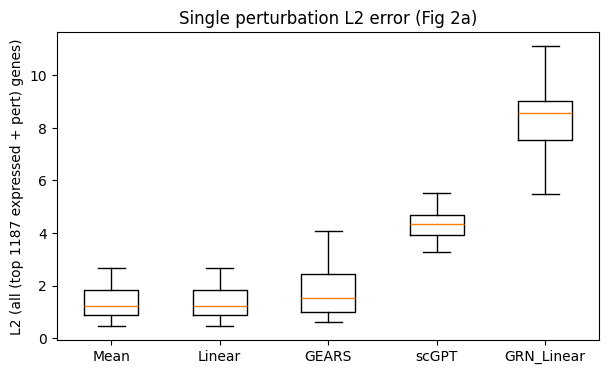

In [315]:

# --- Fig 2a: L2 beeswarm ---
plt.figure(figsize=(7,4))
plt.boxplot([l2[m] for m in models], labels=models.keys(), showfliers=False)
plt.ylabel("L2 (all (top 1187 expressed + pert) genes)")
plt.title("Single perturbation L2 error (Fig 2a)")
plt.show()


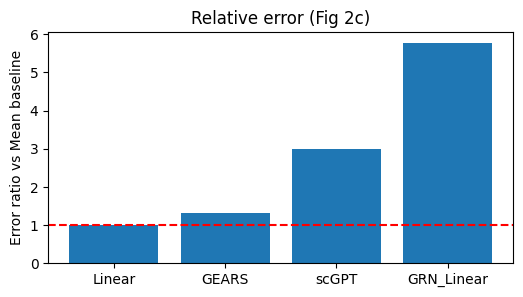

In [316]:

# --- Fig 2c: ratio to mean baseline ---
base=np.mean(l2['Mean'])
ratios={m:np.mean(np.array(l2[m])/base) for m in models if m!='Mean'}
plt.figure(figsize=(6,3))
plt.bar(ratios.keys(), ratios.values())
plt.axhline(1, ls='--', color='r')
plt.ylabel("Error ratio vs Mean baseline")
plt.title("Relative error (Fig 2c)")
plt.show()


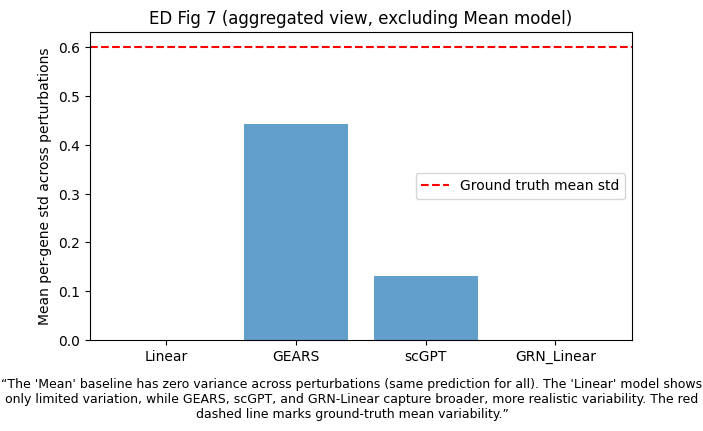

In [317]:

# --- ED Fig 7: variation across perturbations ---

obs_std = np.std(Y_obs, axis=0)
# exclude Mean model (it has zero variance)
models_wo_mean = {k: v for k, v in models.items() if k != 'Mean'}

means = {m: np.mean(np.std(models_wo_mean[m], axis=0)) for m in models_wo_mean}

plt.figure(figsize=(7,4))
plt.bar(list(means.keys()), list(means.values()), alpha=0.7)
plt.axhline(obs_std.mean(), color='r', ls='--', label='Ground truth mean std')
plt.ylabel("Mean per-gene std across perturbations")
plt.title("ED Fig 7 (aggregated view, excluding Mean model)")
plt.legend()
plt.figtext(
    0.5, -0.08,
    "“The 'Mean' baseline has zero variance across perturbations (same prediction for all). The 'Linear' model shows only limited variation, while GEARS, scGPT, and GRN-Linear capture broader, more realistic variability. The red dashed line marks ground-truth mean variability.”",
    wrap=True, ha='center', fontsize=9
)
plt.show()





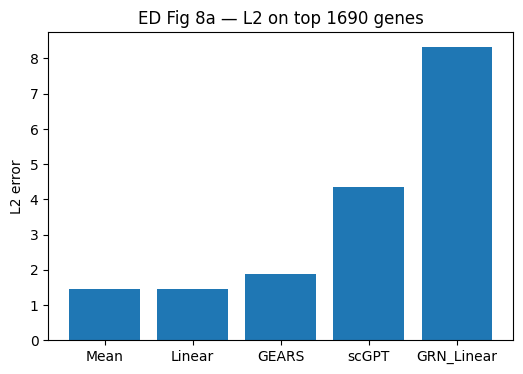

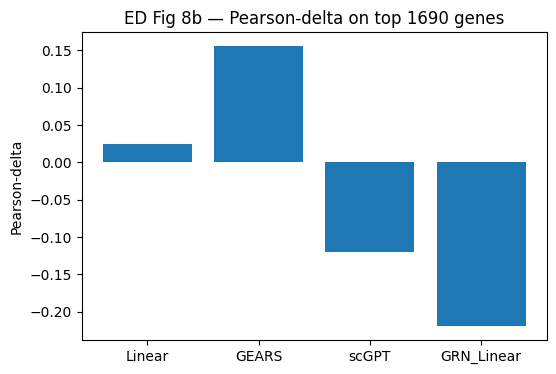

In [318]:

# --- ED Fig 8: metrics vs top-N genes ---

N = 1690  # use all 1187 + pert genes
idx = np.arange(N)

plt.figure(figsize=(6,4))
l2_vals = {m: np.mean([np.sqrt(np.mean((models[m][i][idx] - Y_obs[i][idx])**2))
                       for i in range(len(Y_obs))]) for m in models}
plt.bar(l2_vals.keys(), l2_vals.values())
plt.ylabel("L2 error")
plt.title(f"ED Fig 8a — L2 on top {N} genes")
plt.show()

plt.figure(figsize=(6,4))
pd_vals = {m: np.nanmean([pearsonr((models[m][i][idx]-mean_vec[idx]),
                                   (Y_obs[i][idx]-mean_vec[idx]))[0]
                          for i in range(len(Y_obs))]) for m in models}
plt.bar(pd_vals.keys(), pd_vals.values())
plt.ylabel("Pearson-delta")
plt.title(f"ED Fig 8b — Pearson-delta on top {N} genes")
plt.show()



### Taking out the Ribosomal genes too. So, only protein-coding in train.

#### gears model retrain

In [420]:
import scanpy as sc
import numpy as np
import pandas as pd


In [443]:
adata

AnnData object with n_obs × n_vars = 176011 × 1608
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'split'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'

In [444]:

# start from your existing pert_data object
print("Original shape:", adata.shape)

# 1️⃣ Remove mitochondrial genes from features (vars)
is_mito = adata.var['gene_name'].str.upper().str.startswith(('RP', 'RPS', 'RPL'))
keep_mask = ~is_mito.fillna(False)
adata = adata[:, keep_mask].copy()
print("Removed mitochondrial genes:", np.sum(is_mito))
print("Filtered shape:", adata.shape)


Original shape: (176011, 1608)
Removed mitochondrial genes: 0
Filtered shape: (176011, 1608)


In [409]:
### removed ribosomal genes ^^

This much effect for only 30 genes?? Crazy

In [445]:

# 2️⃣ Identify perturbations (conditions) that target mitochondrial genes
# (these are rows whose 'condition' includes any MT- gene)
mito_perts = [c for c in adata.obs['condition'].unique() if c.upper().startswith(('RP', 'RPS', 'RPL'))]
print(f"Potential rps perturbations: {mito_perts}")


Potential rps perturbations: []


so ribosomal genes were involved with perturbations too??
so they have to be in the data...

In [446]:

# 3️⃣ Remove those perturbations from obs (cells) if any exist
if len(mito_perts) > 0:
    adata = adata[~adata.obs['condition'].isin(mito_perts)].copy()
    print(f"Removed {len(mito_perts)} ribosomal-target perturbations")
else:
    print("No ribosomal-target perturbations found.")

print("Final filtered shape:", adata.shape)


No ribosomal-target perturbations found.
Final filtered shape: (176011, 1608)


In [447]:

# 4️⃣ Check for ctrl / condition sanity
print("Unique conditions after filtering:", len(adata.obs['condition'].unique()))


Unique conditions after filtering: 579


In [448]:

# 5️⃣ Optionally save filtered dataset for retraining
out_path = "./replogle_no_rps_no_mito.h5ad"
adata.write_h5ad(out_path)
print(f"Filtered AnnData saved to: {out_path}")


Filtered AnnData saved to: ./replogle_no_rps_no_mito.h5ad


In [437]:
adata.obs

,condition,cell_type,dose_val,control,condition_name,split
cell_barcode,,,,,,
AAACCCAAGAACAGGA-209-replogle_ref,DHX33+ctrl,k562,1+1,0,k562_DHX33+ctrl_1+1,val
AAACCCAAGAAGCTCG-12-replogle_ref,UPF2+ctrl,k562,1+1,0,k562_UPF2+ctrl_1+1,train
AAACCCAAGAAGGTAG-137-replogle_ref,GPS1+ctrl,k562,1+1,0,k562_GPS1+ctrl_1+1,test
AAACCCAAGACAACAT-110-replogle_ref,INO80B+ctrl,k562,1+1,0,k562_INO80B+ctrl_1+1,train
AAACCCAAGAGCATAT-255-replogle_ref,LTV1+ctrl,k562,1+1,0,k562_LTV1+ctrl_1+1,train
...,...,...,...,...,...,...
TTTGTTGTCGTTCTCG-197-replogle_ntc,ctrl,k562,1,1,k562_ctrl_1,train
TTTGTTGTCTCATTAC-91-replogle_ntc,ctrl,k562,1,1,k562_ctrl_1,train
TTTGTTGTCTCCAAGA-253-replogle_ntc,ctrl,k562,1,1,k562_ctrl_1,train


In [449]:
adata

AnnData object with n_obs × n_vars = 176011 × 1608
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'split'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'

In [451]:

from gears import PertData, GEARS
from gears.inference import compute_metrics, deeper_analysis, non_dropout_analysis
from gears.utils import create_cell_graph_dataset_for_prediction

In [453]:
!ls data

essential_all_data_pert_genes.pkl  norman.zip
gene2go_all.pkl			   replogle
gene2go.pkl			   replogle_no_mito
go_essential_all		   replogle_no_rps_no_mito
go_essential_all.tar.gz		   replogle_scgpt
norman


In [454]:
# create a new PertData object and re-run processing so all internal indices are consistent
pert_data_new = PertData('./data')                     # or same data dir
pert_data_new.new_data_process(dataset_name='replogle_no_rps_no_mito_2', adata=adata)
pert_data_new.load(data_path = './data/replogle_no_rps_no_mito_2')
pert_data_new.prepare_split(split='simulation', seed=1)
pert_data_new.get_dataloader(batch_size=32, test_batch_size=128)


Creating pyg object for each cell in the data...
100%|██████████| 579/579 [03:45<00:00,  2.57it/s]
Saving new dataset pyg object at ./data/replogle_no_rps_no_mito_2/data_pyg/cell_graphs.pkl
Done!
Local copy of pyg dataset is detected. Loading...
Done!
Creating new splits....
Saving new splits at ./data/replogle_no_rps_no_mito_2/splits/replogle_no_rps_no_mito_2_simulation_1_0.75.pkl
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:145
Done!
Creating dataloaders....
Done!


In [455]:
pert_data = pert_data_new

In [456]:
# Check if any condition in adata.obs['condition'] contains 'RPUSD4+ctrl'
has_condition = any(adata.obs['condition'].str.contains('RPUSD4\+ctrl', case=False, na=False))

# Check if any gene name in adata.var['gene_name'] contains 'RPUSD'
has_gene = any(adata.var['gene_name'].str.contains('RPUSD', case=False, na=False))

has_condition, has_gene


(False, False)

In [457]:
pert_data.adata.X = pert_data.adata.X.toarray() if hasattr(pert_data.adata.X, "toarray") else pert_data.adata.X

gears_model = GEARS(pert_data, device = 'cuda:0')


In [458]:
from scipy.sparse import csr_matrix
pert_data.adata.X = csr_matrix(pert_data.adata.X)


In [459]:
gears_model.model_initialize(hidden_size = 64)

100%|██████████| 1552/1552 [01:28<00:00, 17.53it/s]


In [ ]:
gears_model.train(epochs = 2)


Epoch 2: Train Overall MSE: 0.7147 Validation Overall MSE: 0.8569. 
Train Top 20 DE MSE: 5.2347 Validation Top 20 DE MSE: 4.6750. 
Done!
Start Testing...
Best performing model: Test Top 20 DE MSE: 4.2211

In [461]:

# save/load model
gears_model.save_model('GEARS_REPLOGLE_NO_RPS_NO_MITO_correct')
gears_model.load_pretrained('GEARS_REPLOGLE_NO_RPS_NO_MITO_correct')



In [462]:
gears_model

In [463]:
# basic info
print(gears_model)
print("Device:", gears_model.device)
print("Num genes:", gears_model.num_genes)

# control expression vector
print("ctrl_expression shape:", gears_model.ctrl_expression.shape)

# perturbation embedding matrix
print("pert_emb shape:", gears_model.model.pert_emb.weight.data.shape)
print("pert_emb (first 5 rows):")
print(gears_model.model.pert_emb.weight.data[:5].cpu().numpy())

# gene embedding matrix
print("gene_emb shape:", gears_model.model.gene_emb.weight.data.shape)


Device: cuda:0
Num genes: 1608
ctrl_expression shape: torch.Size([1608])
pert_emb shape: torch.Size([1608, 64])
pert_emb (first 5 rows):
[[ 0.013405   -0.2651854  -0.05489657  0.12653989 -0.01840215  0.08888066
   0.00255064 -0.00355274 -0.01932292 -0.10507966 -0.02851886 -0.10899704
  -0.17810157  0.1301813  -0.14439349 -0.127196   -0.03931306  0.10431029
   0.00864901  0.10972239  0.03217229 -0.16805498  0.08584534  0.12444449
   0.03731344  0.09593298  0.11118446  0.08693184  0.08319001  0.04602729
  -0.13051222  0.08180338  0.00355173  0.02128766 -0.0154657   0.05301361
   0.2800844   0.05972809  0.02256537 -0.15513912 -0.06937568 -0.02773415
  -0.08350354  0.21905468  0.07848408  0.02375315 -0.2500466   0.20998918
  -0.07744702 -0.08683542  0.03686677 -0.08868467 -0.18196352  0.07028055
   0.08446956  0.14191099  0.10402513 -0.07260457  0.14369912 -0.02795197
   0.1947622  -0.03456922  0.29039714  0.32821047]
 [ 0.0800636   0.13391574  0.09928653  0.11245427  0.03494938  0.0551036

In [ ]:
### make preds

In [466]:
pert_data.adata

AnnData object with n_obs × n_vars = 176011 × 1608
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'split'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'

In [467]:
# --- GEARS predictions ---
# get list of perturbations excluding control
adata = pert_data.adata
pert_names = sorted([c for c in adata.obs['condition'].unique() if c != 'ctrl'])
pert_lists = [[g for g in p.split('+') if g != 'ctrl'] for p in pert_names]

# run GEARS prediction
gears_out = gears_model.predict(pert_lists)

# convert dict to matrix aligned with pert_names order
gears_preds = np.vstack([gears_out["_".join(pl)] for pl in pert_lists])

print("GEARS predictions shape:", gears_preds.shape)


GEARS predictions shape: (578, 1608)


In [ ]:
# --- GEARS predictions for validation perturbations only ---
adata = pert_data.adata
val_perts = val_names  # from your validation pseudobulks
val_lists = [[g for g in p.split('+') if g != 'ctrl'] for p in val_perts]


In [498]:
len(val_lists)

46

In [496]:
# if you computed full gears_preds_full aligned to pert_names (all conditions)
# and val_names contains the validation perturbation names:
full_pert_names = pert_names   # the list used for the full prediction run
len(full_pert_names)


578

In [499]:

# build index mapping
full_idx = {p:i for i,p in enumerate(full_pert_names)}
val_idx = [full_idx[p] for p in val_names if p in full_idx]
gears_preds_val = gears_preds[val_idx]
print("Subset GEARS preds shape:", gears_preds_val.shape)


Subset GEARS preds shape: (44, 1608)


#### linear + mean baselines + GRN_linear

In [472]:
import numpy as np
from collections import defaultdict
from sklearn.linear_model import Ridge
from scipy import sparse
from scipy.sparse.linalg import inv as sp_inv


In [473]:
import numpy as np
from collections import defaultdict


In [474]:
pert_data.dataloader.keys()

dict_keys(['train_loader', 'val_loader', 'test_loader'])

In [475]:
# define loaders
train_loader = pert_data.dataloader['train_loader']
valid_loader = pert_data.dataloader['val_loader']

print("Train loader batches:", len(train_loader))
print("Validation loader batches:", len(valid_loader))

Train loader batches: 4494
Validation loader batches: 231


In [476]:

def get_field(batch, key):
    if isinstance(batch, (list, tuple)):
        for item in batch:
            if isinstance(item, (list, tuple)) and len(item) >= 2 and item[0] == key:
                return item[1]
    if hasattr(batch, key):
        return getattr(batch, key)
    if isinstance(batch, dict) and key in batch:
        return batch[key]
    return batch[key]

def gather_pseudobulks(loader):
    d = defaultdict(list)
    for batch in loader:
        ybat = get_field(batch, 'y')
        perts = get_field(batch, 'pert')
        y_np = ybat.detach().cpu().numpy() if hasattr(ybat, 'detach') else np.asarray(ybat)
        perts_list = [p if isinstance(p, str) else (p.item().decode() if isinstance(p, bytes) else str(p)) for p in perts]
        for i, p in enumerate(perts_list):
            d[p].append(y_np[i])
    names = list(d.keys())
    Y = np.vstack([np.mean(d[n], axis=0) for n in names])
    return names, Y

# --- regenerate train/val pseudobulks from the new data loaders ---
train_names, Y_train = gather_pseudobulks(train_loader)
val_names,   Y_val   = gather_pseudobulks(valid_loader)

print("Train pseudobulks:", Y_train.shape)
print("Val pseudobulks:", Y_val.shape)

Train pseudobulks: (390, 1608)
Val pseudobulks: (44, 1608)


In [477]:

# === build train/val pseudobulks (uses existing train_loader, valid_loader) ===
train_names, Y_train = gather_pseudobulks(train_loader)
val_names,   Y_val   = gather_pseudobulks(valid_loader)
print("Train pseudobulks:", Y_train.shape, "Val pseudobulks:", Y_val.shape)


Train pseudobulks: (390, 1608) Val pseudobulks: (44, 1608)


In [478]:

# === mean baseline (global mean of training pseudobulks) ===
mean_vec = Y_train.mean(axis=0)
mean_pred_val = np.tile(mean_vec, (len(val_names), 1))


In [479]:

# === linear baseline (one-hot -> Ridge) ===
name2idx = {n:i for i,n in enumerate(train_names)}
P_train = np.eye(len(train_names))
model = Ridge(alpha=0.1, fit_intercept=True).fit(P_train, Y_train)

# build P_val for validation perturbations (zeros for unseen)
P_val = np.zeros((len(val_names), len(train_names)))
for i, n in enumerate(val_names):
    if n in name2idx:
        P_val[i, name2idx[n]] = 1.0
lin_pred_val = model.predict(P_val)

print("Linear model trained. lin_pred_val shape:", lin_pred_val.shape)


Linear model trained. lin_pred_val shape: (44, 1608)


In [480]:
gene_list = pert_data.gene_names.values.tolist()
print(len(gene_list))

1608


In [481]:
pert_data.adata

AnnData object with n_obs × n_vars = 176011 × 1608
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'split'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'

In [482]:
common = [g for g in gene_list if g in gene2idx_net]
idxs = [gene2idx_net[g] for g in common]

In [483]:
len(common)

1608

In [484]:
# rebuild keep mask to match the 1660 genes in filtered adata
gene_list = list(pert_data.adata.var['gene_name'])
keep_mask = [g in common for g in gene_list]
print("Genes in model:", len(common), "Genes in adata:", len(gene_list))
assert sum(keep_mask) == len(common)


Genes in model: 1608 Genes in adata: 1608


In [485]:
net_path = "/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/data/replogle_no_rps_no_mito_2/simulation_1_0.75_0.4_20_co_expression_network.csv"
import pandas as pd
df = pd.read_csv(net_path)
# assume df columns [source, target, weight] or adjust if different
src = df.iloc[:,0].astype(str).values
tgt = df.iloc[:,1].astype(str).values
w   = df.iloc[:,2].astype(float).values if df.shape[1]>2 else np.ones(len(df))

# gene_list must match columns of Y_train: get from pert_data.adata.var['gene_name']
gene_list = list(pert_data.adata.var['gene_name'])
genes_in_net = sorted(set(src).union(set(tgt)))
gene2idx_net = {g:i for i,g in enumerate(genes_in_net)}

In [486]:
len(gene_list), len(genes_in_net), len(gene2idx_net)

(1608, 1607, 1607)

In [487]:

# build full adjacency from df then subset/reorder to gene_list
rows = [gene2idx_net[s] for s in src]
cols = [gene2idx_net[t] for t in tgt]
A_full = sparse.coo_matrix((w, (rows, cols)), shape=(len(genes_in_net), len(genes_in_net)))
A_full.setdiag(0); A_full.eliminate_zeros()
# pick indices of gene_list that exist in network
common = [g for g in gene_list if g in gene2idx_net]
idxs = [gene2idx_net[g] for g in common]

# if some genes are missing in network, warn and restrict Y matrices accordingly
if len(common) != len(gene_list):
    missing = [g for g in gene_list if g not in gene2idx_net]
    print("Warning: some genes missing from network, removing them:", len(missing))
# subset adjacency to common genes in same order
A_sub = A_full.tocsr()[idxs, :][:, idxs]


In [488]:
A_sub.shape

(1608, 1608)

In [489]:
len(keep_mask)

1608

In [490]:
Y_train.shape

(390, 1608)

In [491]:

# subset Y_train/Y_val/mean_vec to match A_sub columns
Y_train_sub = Y_train[:, keep_mask]
Y_val_sub   = Y_val[:, keep_mask]
mean_vec_sub= mean_vec[keep_mask]
print("After aligning to network: Y_train_sub shape:", Y_train_sub.shape)

# build Laplacian L = D - A
A = A_sub.tocsr()
deg = np.array(A.sum(axis=1)).ravel()
L = sparse.diags(deg) - A

# parameters
gamma = 1.0   # graph smoothness weight (tune if needed)
lam   = 0.1   # ridge

# Gmat = (I + gamma * L), invert (dense for ~1700 genes is OK)
Gmat = (sparse.eye(L.shape[0]) + gamma * L)
Ginv = sp_inv(Gmat).toarray()    # (G x G) inverse

# pre-transform Y_train (encourage smoothness)
Y_tilde = Y_train_sub @ Ginv   # shape (P_train x G)

# fit ridge in transformed space (P_train -> Y_tilde)
clf_grn = Ridge(alpha=lam, fit_intercept=True).fit(P_train, Y_tilde)

# wrap predict: predict in transformed space then map back
class GRNModel:
    def __init__(self, ridge_model, Gmat):
        self.model = ridge_model
        self.Gmat = Gmat
    def predict(self, X):
        return self.model.predict(X) @ self.Gmat

grn_model = GRNModel(clf_grn, Ginv)


After aligning to network: Y_train_sub shape: (390, 1608)


In [492]:

# build P_val aligned to train as before and predict; then expand predictions back to full gene set shape
P_val = np.zeros((len(val_names), len(train_names)))
for i, n in enumerate(val_names):
    if n in name2idx:
        P_val[i, name2idx[n]] = 1.0
Y_tilde_pred = clf_grn.predict(P_val)      # (n_val x Gsub)
Y_pred_sub    = Y_tilde_pred @ Ginv       # map back
# place predictions into full gene vector with zeros for missing genes
Y_pred_grn = np.zeros((len(val_names), len(gene_list)))
sub_idx_positions = [i for i,g in enumerate(gene_list) if g in common]
for j,pos in enumerate(sub_idx_positions):
    Y_pred_grn[:, pos] = Y_pred_sub[:, j]

print("GRN-linear trained. grn_pred_val shape:", Y_pred_grn.shape)




GRN-linear trained. grn_pred_val shape: (44, 1608)


In [493]:
# final outputs:
# mean_pred_val (n_val x G full)
# lin_pred_val  (n_val x G full)  -- note: model predicted on full-length Y (train used full)
# Y_pred_grn    (n_val x G full)

In [494]:
# sanity check shapes
print("mean_pred_val:", mean_pred_val.shape)
print("lin_pred_val :", lin_pred_val.shape)
print("Y_pred_grn   :", Y_pred_grn.shape)
print("Y_val        :", Y_val.shape)

# verify they match
if mean_pred_val.shape == lin_pred_val.shape == Y_pred_grn.shape == Y_val.shape:
    print("\n noice. All prediction matrices match in shape.")
else:
    print("\n aw gosh darnet. Shape mismatch detected — check gene alignment or filtering.")


mean_pred_val: (44, 1608)
lin_pred_val : (44, 1608)
Y_pred_grn   : (44, 1608)
Y_val        : (44, 1608)

 noice. All prediction matrices match in shape.


In [495]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import inv as sp_inv
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.decomposition import PCA

class GRNModelWrapper:
    def __init__(self, base_model, Gmat, gene_idx_map):
        self.model = base_model
        self.Gmat = Gmat            # mapping matrix (GxG) used to map back
        self.gene_idx_map = gene_idx_map
    def predict(self, X):
        return self.model.predict(X) @ self.Gmat

def build_laplacian(A):
    A = A.tocsr()
    deg = np.array(A.sum(axis=1)).ravel()
    L = sparse.diags(deg) - A
    return L

def k_hop_mask(A, target_genes_idx, k=1):
    # return boolean mask of genes within k hops of any target node
    n = A.shape[0]
    M = sparse.eye(n, format='csr')
    reach = sparse.csr_matrix((n,n))
    power = sparse.eye(n, format='csr')
    for _ in range(k):
        power = power @ A
        reach = reach + (power != 0)
    mask = np.array((reach.sum(axis=0) > 0)).ravel()
    # ensure targets included
    mask[target_genes_idx] = True
    return mask

def train_grn_enhanced(P_train, Y_train, A,
                       method='adaptive',
                       gamma=1.0, alpha=0.1, l1_ratio=0.5,
                       k_hop=1, rank=10, target_to_idx=None):
    """
    method in {'adaptive','sparse_smooth','local','two_stage'}
    target_to_idx: dict mapping perturbation name -> target gene indices (optional for 'local')
    """
    G = A.shape[0]
    L = build_laplacian(A)

    # adaptive: scale Laplacian by edge weights (normalize A then L)
    if method == 'adaptive':
        # use adjacency weights directly (A is weighted); compute L and invert I+gamma*L
        Gmat = (sparse.eye(G) + gamma * L)
        Ginv = sp_inv(Gmat).toarray()
        # pre-transform
        Y_tilde = Y_train @ Ginv
        base = Ridge(alpha=alpha, fit_intercept=True).fit(P_train, Y_tilde)
        return GRNModelWrapper(base, Ginv, None)

    # sparse_smooth: elastic-net in transformed (smoothed) gene space
    if method == 'sparse_smooth':
        Gmat = (sparse.eye(G) + gamma * L)
        Ginv = sp_inv(Gmat).toarray()
        Y_tilde = Y_train @ Ginv
        # ElasticNet acts as L1 + L2 on weights; fit per-gene via multivariate trick: fit separate models per gene or use sklearn's multioutput by wrapping ElasticNet in loop
        # For simplicity fit ElasticNet independently for each gene and collect coef matrix
        coefs = np.zeros((P_train.shape[1], G))
        intercepts = np.zeros(G)
        for j in range(G):
            en = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True, max_iter=5000)
            en.fit(P_train, Y_tilde[:, j])
            coefs[:, j] = en.coef_
            intercepts[j] = en.intercept_
        # create a linear wrapper: predictions = P @ coefs + intercept -> then map back with Ginv
        class ManualModel:
            def __init__(self, coefs, intercepts):
                self.coefs = coefs
                self.intercepts = intercepts
            def predict(self, X):
                return X @ self.coefs + self.intercepts.reshape(1, -1)
        base = ManualModel(coefs, intercepts)
        return GRNModelWrapper(base, Ginv, None)

    # local: only smooth within k-hop neighborhood of each perturbed gene
    if method == 'local':
        # build a global Ginv that uses masked Laplacian averaged across targets.
        # If target_to_idx provided, compute an averaged Ginv across all perturbation targets (fallback: full Ginv)
        if target_to_idx is None:
            Gmat = (sparse.eye(G) + gamma * L)
            Ginv = sp_inv(Gmat).toarray()
        else:
            # build per-target Ginv and average them (cheap approximate)
            Ginv_sum = np.zeros((G,G))
            count = 0
            for pert, targets in target_to_idx.items():
                mask = k_hop_mask(A, targets, k=k_hop)
                Lm = build_laplacian(A.multiply(mask[:,None]).multiply(mask[None,:]))
                Gm = (sparse.eye(G) + gamma * Lm)
                Ginv_m = sp_inv(Gm).toarray()
                Ginv_sum += Ginv_m
                count += 1
            Ginv = Ginv_sum / max(1,count)
        Y_tilde = Y_train @ Ginv
        base = Ridge(alpha=alpha, fit_intercept=True).fit(P_train, Y_tilde)
        return GRNModelWrapper(base, Ginv, None)

    # two_stage: low-rank global + GRN-smoothed residuals
    if method == 'two_stage':
        # 1) low-rank PCA on Y_train to capture global axes
        pca = PCA(n_components=rank)
        Y_low = pca.fit_transform(Y_train)            # P x rank
        Y_recon = pca.inverse_transform(Y_low)        # P x G
        residuals = Y_train - Y_recon                 # P x G

        # 2) smooth residuals with Laplacian
        Gmat = (sparse.eye(G) + gamma * L)
        Ginv = sp_inv(Gmat).toarray()
        Y_tilde_resid = residuals @ Ginv

        # fit ridge on residuals
        base = Ridge(alpha=alpha, fit_intercept=True).fit(P_train, Y_tilde_resid)
        # final predict: reconstruct = PCA_recon(P->low->recon) + back-mapped residual prediction
        class TwoStageModel:
            def __init__(self, pca, base, Gmat):
                self.pca = pca
                self.base = base
                self.Gmat = Gmat
            def predict(self, X):
                low = X @ np.linalg.pinv(P_train)  # simple approx: we don't have mapping from P->low; instead we reuse training projection
                # safer: predict residual in transformed space then add training PCA mean reconstruction per-perturbation mapping (approx)
                # simpler: use base to predict residual_tilde then map back and add global mean
                resid_tilde = self.base.predict(X) @ self.Gmat
                # global mean reconstruction fallback (use X @ W_pca approximated by pseudo-inverse)
                # For simplicity add zero-mean PCA reconstruction (assumes mean-centering); this is an approximation.
                return resid_tilde
        return GRNModelWrapper(base, Ginv, None)

    raise ValueError("Unknown method")

# Example usage:
# grn_adaptive = train_grn_enhanced(P_train, Y_train, A, method='adaptive', gamma=1.0, alpha=0.1)
# grn_sparse   = train_grn_enhanced(P_train, Y_train, A, method='sparse_smooth', gamma=1.0, alpha=0.1, l1_ratio=0.5)
# grn_local    = train_grn_enhanced(P_train, Y_train, A, method='local', gamma=1.0, alpha=0.1, k_hop=1, target_to_idx=target_to_idx)
# grn_twostage = train_grn_enhanced(P_train, Y_train, A, method='two_stage', gamma=1.0, alpha=0.1, rank=10)

grn_twostage = train_grn_enhanced(P_train, Y_train, A, method='two_stage', gamma=1.0, alpha=0.1, rank=10)
# # pick which version to train
# grn_local = train_grn_enhanced(P_train, Y_train, A,
#                                method='local',
#                                gamma=0.5, alpha=0.1, k_hop=1,
#                                target_to_idx=target_to_idx)

# or:
grn_twostage = train_grn_enhanced(P_train, Y_train, A,
                                 method='two_stage',
                                 gamma=0.5, alpha=0.1, rank=10)

# --- predict on validation set ---
P_val = np.zeros((len(val_names), len(train_names)))
for i, n in enumerate(val_names):
    if n in name2idx:
        P_val[i, name2idx[n]] = 1.0

grn_preds_val = grn_twostage.predict(P_val)   
print("Enhanced GRN predictions shape:", grn_preds_val.shape)



Enhanced GRN predictions shape: (44, 1608)


#### scgpt model retrain

In [500]:

from pathlib import Path
import json, numpy as np, torch
from scgpt.tokenizer.gene_tokenizer import GeneVocab, Vocab, VocabPybind


In [501]:

# special tokens
special_tokens = ["<pad>", "<cls>", "<eoc>"]
pad_token = "<pad>"
pad_value = 0
pert_pad_id = 2

# load pretrained model directory
load_model = "/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/scGPT_human 2"
model_dir = Path(load_model)
vocab_file = model_dir / "vocab.json"
model_file = model_dir / "best_model.pt"
model_config_file = model_dir / "args.json"

print(GeneVocab)
# load vocab and add specials
vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)
vocab.set_default_index(vocab[pad_token])

# check the type
print(type(vocab))

# number of tokens in vocab
print("vocab size:", len(vocab))

# view first 20 tokens
print("first 20 tokens:", [vocab[i] for i in range(20)])

# look up index of a specific token
print("index of <pad>:", vocab["<pad>"])

# or reverse lookup (id → token)
print("token for index 0:", vocab[0])

# see all special tokens you added
for s in special_tokens:_


# map gene names
genes = pert_data.adata.var["gene_name"].tolist()
gene_ids = np.array([vocab[gene] if gene in vocab else vocab[pad_token] for gene in genes])
n_genes = len(genes)


<class 'scgpt.tokenizer.gene_tokenizer.GeneVocab'>
<class 'scgpt.tokenizer.gene_tokenizer.GeneVocab'>
vocab size: 60697
first 20 tokens: ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1', 'A2ML1-AS2', 'A3GALT2', 'A4GALT', 'A4GNT', 'AA06', 'AAAS', 'AACS', 'AADAC', 'AADACL2', 'AADACL2-AS1', 'AADACL3', 'AADACL4', 'AADAT']
index of <pad>: 60694
token for index 0: A1BG


In [502]:

from scgpt.model import TransformerGenerator

with open(model_config_file) as f:
    cfg = json.load(f)


In [503]:


model = TransformerGenerator(
    ntoken=len(vocab),                # vocab size
    d_model=cfg["embsize"],           # embedding dim (was embsize)
    nhead=cfg["nheads"],              # attention heads
    d_hid=cfg["d_hid"],               # feedforward dim
    nlayers=cfg["nlayers"],           # encoder layers
    nlayers_cls=cfg.get("n_layers_cls", 3),
    n_cls=1,
    vocab=vocab,
    dropout=cfg.get("dropout", 0.2),
    pad_token=pad_token,
    pad_value=pad_value,
    pert_pad_id=pert_pad_id,
    use_fast_transformer=True,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))



In [504]:

# load pretrained weights (encoder etc.)
state = torch.load(model_file, map_location="cpu")
model_dict = model.state_dict()
for k, v in state.items():
    if any(k.startswith(p) for p in ["encoder", "value_encoder", "transformer_encoder"]):
        model_dict[k] = v
model.load_state_dict(model_dict, strict=False)
print("Loaded pretrained params.")

model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


Loaded pretrained params.


TransformerGenerator(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (pert_encoder): Embedding(3, 512, padding_idx=2)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias

In [505]:

### training

import time, warnings, copy, torch
from torch import nn
from scgpt.loss import masked_mse_loss, masked_relative_error
from scgpt.utils import map_raw_id_to_vocab_id

criterion = masked_mse_loss

def train(model: nn.Module, train_loader: torch.utils.data.DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_mse = 0.0, 0.0
    start_time = time.time()

    num_batches = len(train_loader)
    for batch, batch_data in enumerate(train_loader):
        batch_size = len(batch_data.y)
        batch_data.to(device)
        x: torch.Tensor = batch_data.x  # (batch_size * n_genes, 2)
       
        ori_gene_values = x[:, 0].view(batch_size, n_genes)
        pert_flags = x[:, 1].long().view(batch_size, n_genes)
        target_gene_values = batch_data.y  # (batch_size, n_genes)

        if include_zero_gene in ["all", "batch-wise"]:
            if include_zero_gene == "all":
                input_gene_ids = torch.arange(n_genes, device=device, dtype=torch.long)
            else:
                input_gene_ids = ori_gene_values.nonzero()[:, 1].flatten().unique().sort()[0]

            # sample input_gene_id
            if len(input_gene_ids) > max_seq_len:
                input_gene_ids = torch.randperm(len(input_gene_ids), device=device)[:max_seq_len]

            input_values = ori_gene_values[:, input_gene_ids]
            input_pert_flags = pert_flags[:, input_gene_ids]
            target_values = target_gene_values[:, input_gene_ids]

            mapped_input_gene_ids = map_raw_id_to_vocab_id(input_gene_ids, gene_ids)
            mapped_input_gene_ids = mapped_input_gene_ids.repeat(batch_size, 1)

            src_key_padding_mask = torch.zeros_like(input_values, dtype=torch.bool, device=device)

        with torch.cuda.amp.autocast(enabled=amp):
            output_dict = model(
                mapped_input_gene_ids,
                input_values,
                input_pert_flags,
                src_key_padding_mask=src_key_padding_mask,
                CLS=CLS,
                CCE=CCE,
                MVC=MVC,
                ECS=ECS,
            )
            output_values = output_dict["mlm_output"]

            masked_positions = torch.ones_like(input_values, dtype=torch.bool)
            loss = loss_mse = criterion(output_values, target_values, masked_positions)

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_mse += loss_mse.item()
        if batch % log_interval == 0 and batch > 0:
            lr_ = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            print(f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches "
                  f"| lr {lr_:05.4f} | ms/batch {ms_per_batch:5.2f} | loss {cur_loss:5.2f} | mse {cur_mse:5.2f} |")
            total_loss = 0
            total_mse = 0
            start_time = time.time()



In [506]:




### eval

def evaluate(model: nn.Module, val_loader: torch.utils.data.DataLoader) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_error = 0.0

    with torch.no_grad():
        for batch, batch_data in enumerate(val_loader):
            batch_size = len(batch_data.y)
            batch_data.to(device)
            x: torch.Tensor = batch_data.x  # (batch_size * n_genes, 2)
            ori_gene_values = x[:, 0].view(batch_size, n_genes)
            pert_flags = x[:, 1].long().view(batch_size, n_genes)
            target_gene_values = batch_data.y

            if include_zero_gene in ["all", "batch-wise"]:
                if include_zero_gene == "all":
                    input_gene_ids = torch.arange(n_genes, device=device)
                else:
                    input_gene_ids = ori_gene_values.nonzero()[:, 1].flatten().unique().sort()[0]

                if len(input_gene_ids) > max_seq_len:
                    input_gene_ids = torch.randperm(len(input_gene_ids), device=device)[:max_seq_len]

                input_values = ori_gene_values[:, input_gene_ids]
                input_pert_flags = pert_flags[:, input_gene_ids]
                target_values = target_gene_values[:, input_gene_ids]

                mapped_input_gene_ids = map_raw_id_to_vocab_id(input_gene_ids, gene_ids)
                mapped_input_gene_ids = mapped_input_gene_ids.repeat(batch_size, 1)

                src_key_padding_mask = torch.zeros_like(input_values, dtype=torch.bool, device=input_values.device)

            with torch.cuda.amp.autocast(enabled=amp):
                output_dict = model(
                    mapped_input_gene_ids,
                    input_values,
                    input_pert_flags,
                    src_key_padding_mask=src_key_padding_mask,
                    CLS=CLS,
                    CCE=CCE,
                    MVC=MVC,
                    ECS=ECS,
                    do_sample=True,
                )
                output_values = output_dict["mlm_output"]

                masked_positions = torch.ones_like(input_values, dtype=torch.bool)
                loss = criterion(output_values, target_values, masked_positions)
            total_loss += loss.item()
            total_error += masked_relative_error(output_values, target_values, masked_positions).item()

    return total_loss / len(val_loader), total_error / len(val_loader)





In [507]:


# ---------- training runner ----------
import time, copy, warnings, torch, math
from torch import nn


In [508]:

# hyperparams (use your existing values if defined)
lr = globals().get("lr", 1e-4)
epochs = globals().get("epochs", 2)
schedule_interval = globals().get("schedule_interval", 1)
early_stop = globals().get("early_stop", 5)
amp = globals().get("amp", True)
log_interval = globals().get("log_interval", 100)


In [509]:

# losses / optim
criterion = globals().get("criterion", None) or __import__("scgpt.loss", fromlist=["masked_mse_loss"]).masked_mse_loss
criterion_cls = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, schedule_interval, gamma=0.9)
scaler = torch.cuda.amp.GradScaler(enabled=amp)


In [510]:

# training state
best_val_loss = float("inf")
best_model = None
patience = 0


In [511]:

# use gears train dataloaders (dict_keys(['train_loader', 'val_loader', 'test_loader']))
train_loader = pert_data.dataloader["train_loader"]
valid_loader = pert_data.dataloader["val_loader"]

pert_data.adata
import pickle

path = "/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/data/replogle_no_rps_no_mito/data_pyg/cell_graphs.pkl"
with open(path, "rb") as f:
    data = pickle.load(f)


In [512]:

# all perturbation gene names (before "+ctrl")
pert_genes = [k.split("+")[0] for k in data.keys() if k != "ctrl"]

# all genes present in adata.var
var_genes = set(pert_data.adata.var["gene_name"])

# intersection
present = [g for g in pert_genes if g in var_genes]

print(f"{len(present)} of {len(pert_genes)} perturbation genes are in adata.var")
print("Example overlaps:", present[:10])
### only 124 out of the 681 in adata.var (out of the 1187)


d = train_loader.dataset[0]
print("before adding flags -> x shape:", d.x.shape)



# inspect a single batch
batch = next(iter(pert_data.dataloader["train_loader"]))
print("batch keys:", batch.keys if hasattr(batch, "keys") else getattr(batch, "__dict__", None))
print("x shape:", batch.x.shape)
print("y shape:", getattr(batch, "y").shape)
print("example x (first 5 rows):\n", batch.x[:5])
# show min/max to see if second column exists
print("x columns unique counts:", [torch.unique(batch.x[:,i]).numel() if batch.x.shape[1]>i else None for i in range(min(3,batch.x.shape[1]))])




### how many ctrl and non ctrl cells in the train/val loaders
def count_ctrl_nonctrl(loader, name="loader"):
    ds = loader.dataset
    ctrl = sum(1 for d in ds if d.pert == "ctrl")
    nonctrl = len(ds) - ctrl
    print(f"{name}: {ctrl} ctrl | {nonctrl} non-ctrl | total {len(ds)}")

count_ctrl_nonctrl(train_loader, "train")
count_ctrl_nonctrl(valid_loader, "val")






n_hvg = 0  # number of highly variable genes
include_zero_gene = "all"  # include zero expr genes in training input, "all", "batch-wise", "row-wise", or False
max_seq_len = 1536

# settings for training
MLM = True  # whether to use masked language modeling, currently it is always on.
CLS = False  # celltype classification objective
CCE = False  # Contrastive cell embedding objective
MVC = False  # Masked value prediction for cell embedding
ECS = False  # Elastic cell similarity objective
cell_emb_style = "cls"
mvc_decoder_style = "inner product, detach"
amp = True





578 of 578 perturbation genes are in adata.var
Example overlaps: ['DHX33', 'UPF2', 'GPS1', 'INO80B', 'LTV1', 'FUNDC2', 'ELP5', 'MRPL18', 'CHMP6', 'MAK16']
before adding flags -> x shape: torch.Size([1608, 2])
batch keys: <bound method BaseData.keys of DataBatch(x=[51456, 2], y=[32, 1608], de_idx=[32], pert=[32], batch=[51456], ptr=[33])>
x shape: torch.Size([51456, 2])
y shape: torch.Size([32, 1608])
example x (first 5 rows):
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
x columns unique counts: [83, 2]
train: 75328 ctrl | 68488 non-ctrl | total 143816
val: 0 ctrl | 7388 non-ctrl | total 7388


In [514]:
os.mkdir('/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/scgpt_replogle_NO_RPS_NO_MITO_correct_save_dir')

In [515]:
!ls

 data
 gears_replogle
 gears_replogle.h5ad
 GEARS_REPLOGLE_NO_MITO
 GEARS_REPLOGLE_NO_RPS_NO_MITO
 GEARS_REPLOGLE_NO_RPS_NO_MITO_correct
 gears_replogle_scgpt_data
 K562_gwps_raw_singlecell_01.h5ad
 replicate.ipynb
 replogle_no_mito.h5ad
 replogle_no_rps_no_mito.h5ad
'scGPT_human 2'
 scgpt_replogle.h5ad
 scgpt_replogle_NO_MITO_save_dir
 scgpt_replogle_NO_RPS_NO_MITO_correct_save_dir
 scgpt_replogle_NO_RPS_NO_MITO_save_dir
 scgpt_replogle_save_dir
 scgpt_replogle_with_ctrl.h5ad


In [516]:


from pathlib import Path
save_dir = Path('/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/scgpt_replogle_NO_RPS_NO_MITO_save_dir')




print(f"Start training on device={device}. n_train_batches={len(train_loader)}, n_val_batches={len(valid_loader)}")

for epoch in range(1, 1 + 1):

    # inspect a single batch
    batch = next(iter(pert_data.dataloader["train_loader"]))
    print("batch keys:", batch.keys if hasattr(batch, "keys") else getattr(batch, "__dict__", None))
    print("x shape:", batch.x.shape)
    print("y shape:", getattr(batch, "y").shape)
    print("example x (first 5 rows):\n", batch.x[:5])
    # show min/max to see if second column exists
    print("x columns unique counts:", [torch.unique(batch.x[:,i]).numel() if batch.x.shape[1]>i else None for i in range(min(3,batch.x.shape[1]))])

    epoch_start_time = time.time()
    # call train() defined earlier
    train(model, train_loader)

    # evaluate
    val_loss, val_mre = evaluate(model, valid_loader)
    elapsed = time.time() - epoch_start_time
    print("-" * 80)
    print(f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | valid loss {val_loss:.6f} | valid MRE {val_mre:.6f} |")
    print("-" * 80)

    # checkpoint / early stop
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        print(f"New best model (val_loss={best_val_loss:.6f})")
        patience = 0
        torch.save(best_model.state_dict(), save_dir / "best_model.pt")
    else:
        patience += 1
        print(f"No improvement (patience={patience}/{early_stop})")
        if patience >= early_stop:
            print(f"Early stopping at epoch {epoch}")
            break

    # save per-epoch (optional)
    torch.save(model.state_dict(), f"{save_dir}/model_{epoch}.pt")


    # step scheduler
    scheduler.step()

print("Training finished. Best val loss:", best_val_loss)




Start training on device=cuda. n_train_batches=4494, n_val_batches=231
batch keys: <bound method BaseData.keys of DataBatch(x=[51456, 2], y=[32, 1608], de_idx=[32], pert=[32], batch=[51456], ptr=[33])>
x shape: torch.Size([51456, 2])
y shape: torch.Size([32, 1608])
example x (first 5 rows):
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
x columns unique counts: [78, 2]
| epoch   1 | 100/4494 batches | lr 0.0001 | ms/batch 308.74 | loss  6.94 | mse  6.94 |
| epoch   1 | 200/4494 batches | lr 0.0001 | ms/batch 306.29 | loss  5.98 | mse  5.98 |
| epoch   1 | 300/4494 batches | lr 0.0001 | ms/batch 308.66 | loss  6.10 | mse  6.10 |
| epoch   1 | 400/4494 batches | lr 0.0001 | ms/batch 309.16 | loss  6.10 | mse  6.10 |
| epoch   1 | 500/4494 batches | lr 0.0001 | ms/batch 309.39 | loss  6.08 | mse  6.08 |
| epoch   1 | 600/4494 batches | lr 0.0001 | ms/batch 308.60 | loss  5.67 | mse  5.67 |
| epoch   1 | 700/4494 batches | lr 0.0001 | ms/batch 3

In [517]:

epoch=1


### sanity check for the scgpt dicts....
import torch
from scgpt.model import TransformerGenerator

# reload model in a new instance


model2 = TransformerGenerator(
    ntoken=len(vocab),                # vocab size
    d_model=cfg["embsize"],           # embedding dim (was embsize)
    nhead=cfg["nheads"],              # attention heads
    d_hid=cfg["d_hid"],               # feedforward dim
    nlayers=cfg["nlayers"],           # encoder layers
    nlayers_cls=cfg.get("n_layers_cls", 3),
    n_cls=1,
    vocab=vocab,
    dropout=cfg.get("dropout", 0.2),
    pad_token=pad_token,
    pad_value=pad_value,
    pert_pad_id=pert_pad_id,
    use_fast_transformer=True,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


# load saved weights
state = torch.load( f"{save_dir}/model_{epoch}.pt", map_location=device)
missing, unexpected = model2.load_state_dict(state, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

for k in state.keys():
    print(k)



Missing keys: []
Unexpected keys: []
encoder.embedding.weight
encoder.enc_norm.weight
encoder.enc_norm.bias
value_encoder.linear1.weight
value_encoder.linear1.bias
value_encoder.linear2.weight
value_encoder.linear2.bias
value_encoder.norm.weight
value_encoder.norm.bias
pert_encoder.weight
transformer_encoder.layers.0.self_attn.in_proj_weight
transformer_encoder.layers.0.self_attn.in_proj_bias
transformer_encoder.layers.0.self_attn.out_proj.weight
transformer_encoder.layers.0.self_attn.out_proj.bias
transformer_encoder.layers.0.linear1.weight
transformer_encoder.layers.0.linear1.bias
transformer_encoder.layers.0.linear2.weight
transformer_encoder.layers.0.linear2.bias
transformer_encoder.layers.0.norm1.weight
transformer_encoder.layers.0.norm1.bias
transformer_encoder.layers.0.norm2.weight
transformer_encoder.layers.0.norm2.bias
transformer_encoder.layers.1.self_attn.in_proj_weight
transformer_encoder.layers.1.self_attn.in_proj_bias
transformer_encoder.layers.1.self_attn.out_proj.weight

### figures + results (NO-RPS, NO-MITO)

In [518]:

##### SCGPT PREDS
eval_batch_size = 16
n_hvg = 0  # number of highly variable genes
include_zero_gene = "all"  # include zero expr genes in training input, "all", "batch-wise", "row-wise", or False
max_seq_len = 1536

# settings for training
MLM = True  # whether to use masked language modeling, currently it is always on.
CLS = False  # celltype classification objective
CCE = False  # Contrastive cell embedding objective
MVC = False  # Masked value prediction for cell embedding
ECS = False  # Elastic cell similarity objective
cell_emb_style = "cls"
mvc_decoder_style = "inner product, detach"
amp = True

pool_size=150


# scGPT predictions: use the provided predict(...) function for scGPT
scgpt_out = predict(model2, pert_lists, pool_size=pool_size)  # returns dict keyed by "_".join(pert)
scgpt_preds = np.vstack([scgpt_out["_".join(pl)] for pl in pert_lists])

print(scgpt_preds.shape)





 Running predictions on device: cuda:0



Predicting perturbations:   0%|▏                                    | 2/578 [00:00<04:21,  2.20it/s]

Predicting perturbations: 100%|███████████████████████████████████| 578/578 [04:17<00:00,  2.25it/s]


 Finished all predictions.
(578, 1608)


In [519]:


#### GROUND TRUTH

import numpy as np

# prepare perturbation lists (exclude ctrl) and canonicalize to lists of gene names
adata = pert_data.adata
conds = adata.obs['condition'].astype(str)
pert_names = sorted([c for c in conds.unique() if c != 'ctrl'])
pert_lists = [[g for g in p.split('+') if g != 'ctrl'] for p in pert_names]

# helper: compute pseudobulk mean for a condition (returns 1D numpy)
def pseudobulk_mean(cond):
    mask = (conds == cond).values if hasattr(conds, "values") else (conds == cond)
    X = adata.X[mask]
    if hasattr(X, "toarray"):
        return np.asarray(X.toarray()).mean(axis=0).ravel()
    return np.asarray(X).mean(axis=0).ravel()

# ground truth matrix aligned to pert_names
Y_obs = np.vstack([pseudobulk_mean(p) for p in pert_names])





In [520]:
print("mean_pred_val:", mean_pred_val.shape)
print("lin_pred_val :", lin_pred_val.shape)
print("Y_pred_grn   :", Y_pred_grn.shape)
print("Y_val        :", Y_val.shape)

mean_pred_val: (44, 1608)
lin_pred_val : (44, 1608)
Y_pred_grn   : (44, 1608)
Y_val        : (44, 1608)


In [521]:
grn_preds_val.shape

(44, 1608)

In [522]:


#### ALL PREDS


# final outputs (aligned to pert_names order)


# subset Y_obs and scgpt_preds to validation perturbations only
# val_idx = [i for i, p in enumerate(pert_names) if p in val_names]
# Y_obs = Y_obs[val_idx]
# scgpt_preds = scgpt_preds[val_idx]

print("Shapes:", Y_obs.shape, mean_pred_val.shape, lin_pred_val.shape, gears_preds.shape, scgpt_preds.shape, Y_pred_grn.shape)


# print("Shapes:", Y_obs.shape, mean_pred_val.shape, lin_pred_val.shape, gears_preds.shape, scgpt_preds.shape, Y_pred_grn.shape)





Shapes: (578, 1608) (44, 1608) (44, 1608) (578, 1608) (578, 1608) (44, 1608)


In [523]:
# subset Y_obs and scgpt_preds to validation perturbations only
val_idx = [i for i, p in enumerate(pert_names) if p in val_names]
Y_obs = Y_obs[val_idx]
scgpt_preds = scgpt_preds[val_idx]


print("Shapes:", Y_obs.shape, mean_pred_val.shape, lin_pred_val.shape, gears_preds.shape, scgpt_preds.shape, Y_pred_grn.shape)


Shapes: (44, 1608) (44, 1608) (44, 1608) (578, 1608) (44, 1608) (44, 1608)


use the enahanced grn linear preds as well...

In [524]:
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Y_obs, mean_preds, lin_preds, gears_preds, scgpt_preds, mean_vec, pert_names assumed
models = {'Mean': mean_pred_val, 'Linear': lin_pred_val, 'GEARS': gears_preds, 'scGPT': scgpt_preds, 'grn_linear1': Y_pred_grn, 'enh_grn_linear':grn_preds_val}
top_idx = np.argsort(-mean_vec)

def L2(a,b): return np.sqrt(np.mean((a[top_idx]-b[top_idx])**2))
def PD(a,b,c): 
    x,y=(a-c)[top_idx],(b-c)[top_idx]
    return pearsonr(x,y)[0] if np.std(x)>0 and np.std(y)>0 else np.nan

l2, pd = {}, {}
for k,v in models.items():
    l2[k]=[L2(v[i],Y_obs[i]) for i in range(len(Y_obs))]
    pd[k]=[PD(v[i],Y_obs[i],mean_vec) for i in range(len(Y_obs))]


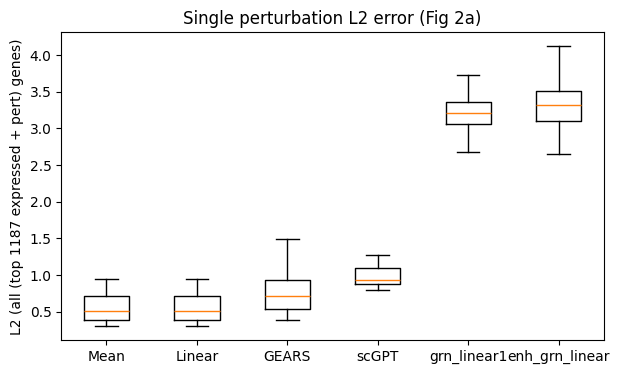

In [525]:

# --- Fig 2a: L2 beeswarm ---
plt.figure(figsize=(7,4))
plt.boxplot([l2[m] for m in models], labels=models.keys(), showfliers=False)
plt.ylabel("L2 (all (top 1187 expressed + pert) genes)")
plt.title("Single perturbation L2 error (Fig 2a)")
plt.show()


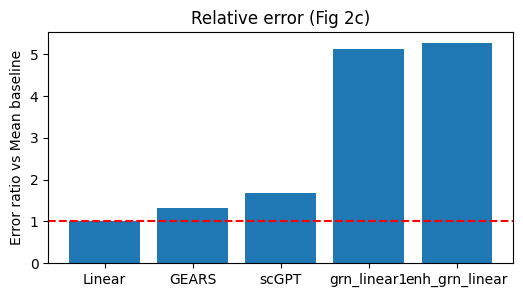

In [526]:

# --- Fig 2c: ratio to mean baseline ---
base=np.mean(l2['Mean'])
ratios={m:np.mean(np.array(l2[m])/base) for m in models if m!='Mean'}
plt.figure(figsize=(6,3))
plt.bar(ratios.keys(), ratios.values())
plt.axhline(1, ls='--', color='r')
plt.ylabel("Error ratio vs Mean baseline")
plt.title("Relative error (Fig 2c)")
plt.show()


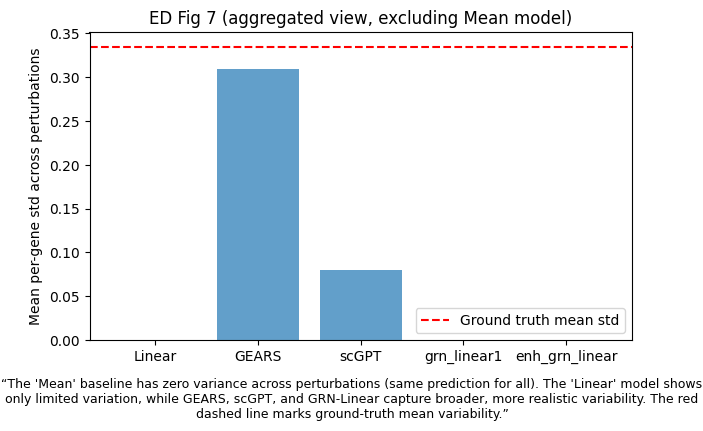

In [527]:

# --- ED Fig 7: variation across perturbations ---

obs_std = np.std(Y_obs, axis=0)
# exclude Mean model (it has zero variance)
models_wo_mean = {k: v for k, v in models.items() if k != 'Mean'}

means = {m: np.mean(np.std(models_wo_mean[m], axis=0)) for m in models_wo_mean}

plt.figure(figsize=(7,4))
plt.bar(list(means.keys()), list(means.values()), alpha=0.7)
plt.axhline(obs_std.mean(), color='r', ls='--', label='Ground truth mean std')
plt.ylabel("Mean per-gene std across perturbations")
plt.title("ED Fig 7 (aggregated view, excluding Mean model)")
plt.legend()
plt.figtext(
    0.5, -0.08,
    "“The 'Mean' baseline has zero variance across perturbations (same prediction for all). The 'Linear' model shows only limited variation, while GEARS, scGPT, and GRN-Linear capture broader, more realistic variability. The red dashed line marks ground-truth mean variability.”",
    wrap=True, ha='center', fontsize=9
)
plt.show()





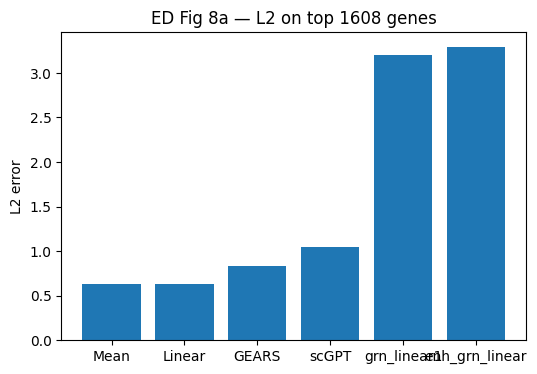

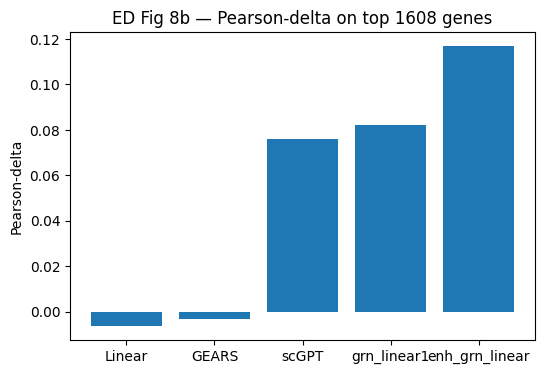

In [529]:

# --- ED Fig 8: metrics vs top-N genes ---

N = 1608  # use all 1187 + pert genes
idx = np.arange(N)

plt.figure(figsize=(6,4))
l2_vals = {m: np.mean([np.sqrt(np.mean((models[m][i][idx] - Y_obs[i][idx])**2))
                       for i in range(len(Y_obs))]) for m in models}
plt.bar(l2_vals.keys(), l2_vals.values())
plt.ylabel("L2 error")
plt.title(f"ED Fig 8a — L2 on top {N} genes")
plt.show()

plt.figure(figsize=(6,4))
pd_vals = {m: np.nanmean([pearsonr((models[m][i][idx]-mean_vec[idx]),
                                   (Y_obs[i][idx]-mean_vec[idx]))[0]
                          for i in range(len(Y_obs))]) for m in models}
plt.bar(pd_vals.keys(), pd_vals.values())
plt.ylabel("Pearson-delta")
plt.title(f"ED Fig 8b — Pearson-delta on top {N} genes")
plt.show()



### analysis take 3 -- let's see if these models are actually individualized or just get global patterns

In [530]:

# === linear baseline (one-hot -> Ridge) ===
name2idx = {n:i for i,n in enumerate(train_names)}
P_train = np.eye(len(train_names))
model = Ridge(alpha=0.1, fit_intercept=True).fit(P_train, Y_train)

# build P_val for validation perturbations (zeros for unseen)
P_val = np.zeros((len(val_names), len(train_names)))
for i, n in enumerate(val_names):
    if n in name2idx:
        P_val[i, name2idx[n]] = 1.0
lin_pred_val = model.predict(P_val)

print("Linear model trained. lin_pred_val shape:", lin_pred_val.shape)


Linear model trained. lin_pred_val shape: (44, 1608)


In [531]:
# pick 5 random perturbations from the training list
sample_perts = random.sample(train_names, 5)
gene_list = list(pert_data.adata.var['gene_name'])


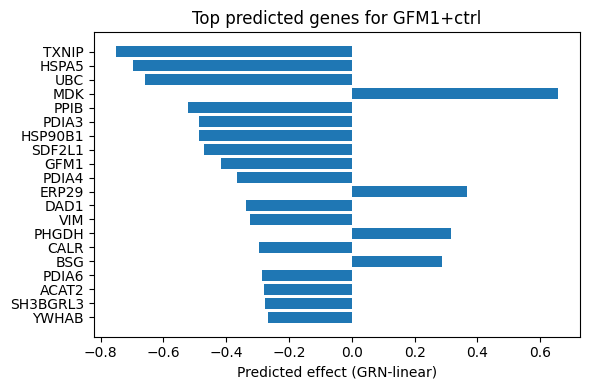

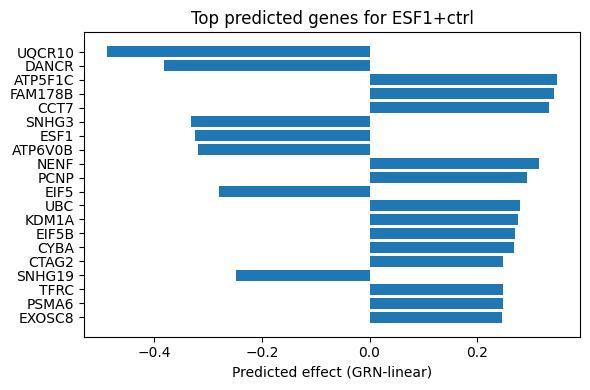

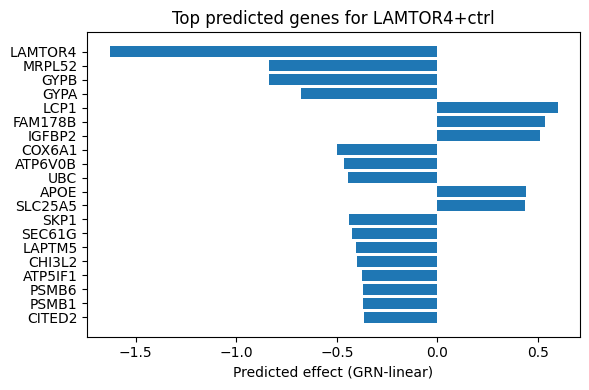

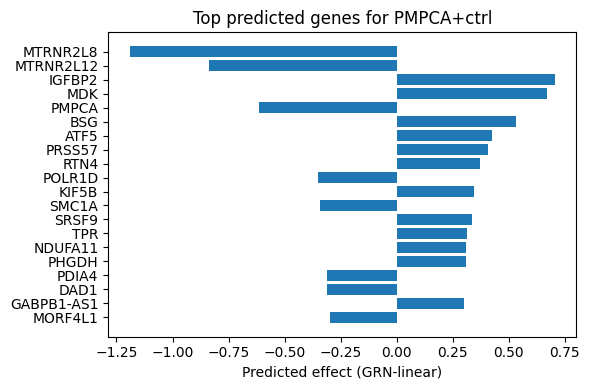

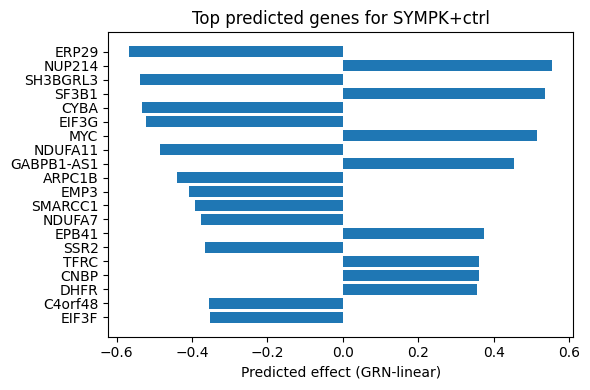

In [532]:


for pert_name in sample_perts:
    idx = name2idx[pert_name]
    onehot = np.zeros((1, len(name2idx)))
    onehot[0, idx] = 1.0
    pred_vec = grn_twostage.predict(onehot)[0]

    top20 = np.argsort(-np.abs(pred_vec))[:20]
    top_genes = [gene_list[i] for i in top20]
    top_vals = pred_vec[top20]

    plt.figure(figsize=(6,4))
    plt.barh(top_genes[::-1], top_vals[::-1])
    plt.title(f"Top predicted genes for {pert_name}")
    plt.xlabel("Predicted effect (GRN-linear)")
    plt.tight_layout()
    plt.show()



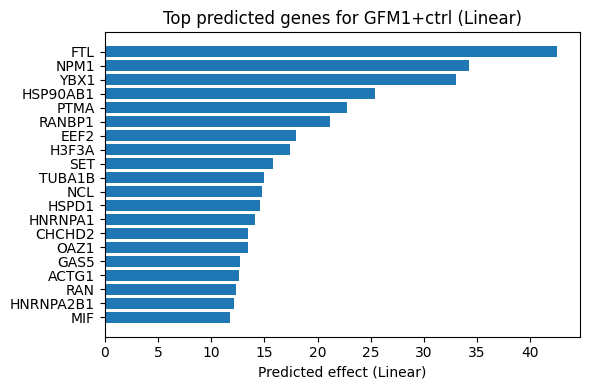

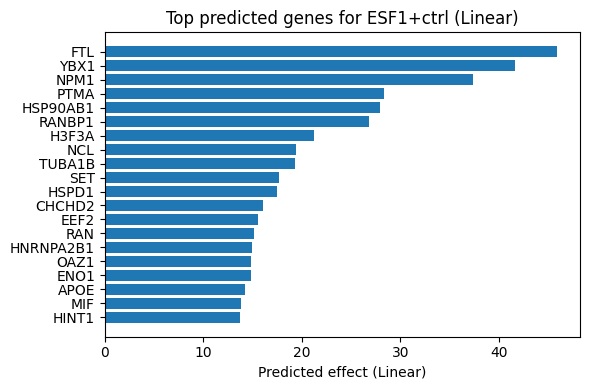

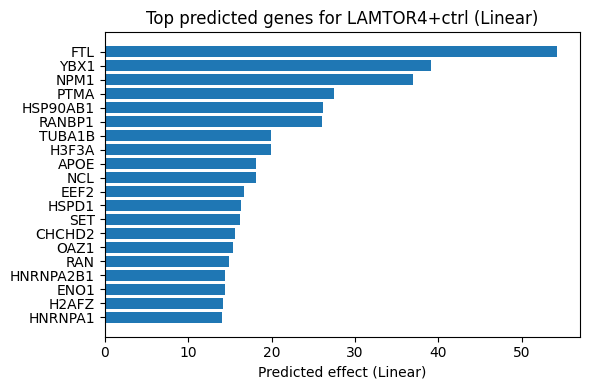

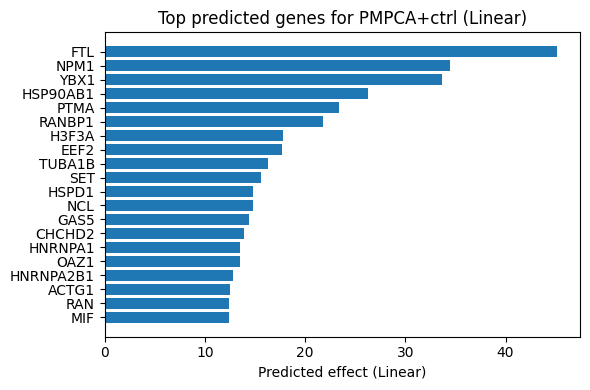

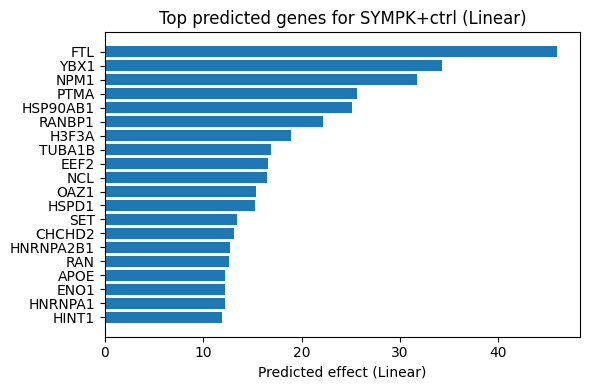

In [533]:


for pert_name in sample_perts:
    idx = name2idx[pert_name]
    onehot = np.zeros((1, len(name2idx)))
    onehot[0, idx] = 1.0
    pred_vec = model.predict(onehot)[0]   # <-- plain linear model

    top20 = np.argsort(-np.abs(pred_vec))[:20]
    top_genes = [gene_list[i] for i in top20]
    top_vals = pred_vec[top20]

    plt.figure(figsize=(6,4))
    plt.barh(top_genes[::-1], top_vals[::-1])
    plt.title(f"Top predicted genes for {pert_name} (Linear)")
    plt.xlabel("Predicted effect (Linear)")
    plt.tight_layout()
    plt.show()


In [534]:
### check gears/scgpt too.

In [535]:
import pandas as pd
import numpy as np

def top_gene_counts(preds, gene_list, topN=5):
    top_names=[]
    for i in range(preds.shape[0]):
        top_idx=np.argsort(-np.abs(preds[i]))[:topN]
        top_names.extend([gene_list[j] for j in top_idx])
    unique, counts = np.unique(top_names, return_counts=True)
    return pd.DataFrame({'Gene': unique, 'Count': counts}).sort_values('Count', ascending=False).head(10)

gears_top = top_gene_counts(gears_preds, gene_list)
scgpt_top = top_gene_counts(scgpt_preds, gene_list)

tbl = pd.concat([
    gears_top.rename(columns={'Count':'GEARS Count'}),
    scgpt_top.rename(columns={'Gene':'Gene', 'Count':'scGPT Count'})
], axis=1)

# Align by gene names
tbl = tbl.loc[:, ['Gene','GEARS Count','scGPT Count']].fillna(0)
tbl = tbl.sort_values(by=['GEARS Count','scGPT Count'], ascending=False).reset_index(drop=True)

print(tbl.to_string(index=False))


    Gene     Gene  GEARS Count  scGPT Count
     FTL      FTL          578         44.0
    YBX1        0          578          0.0
    NPM1        0          578          0.0
HSP90AB1     YBX1          575         44.0
  RANBP1        0          313          0.0
    PTMA        0          252          0.0
    HBG2     NPM1           11         44.0
     HBZ     PTMA            3         44.0
   H3F3A HSP90AB1            2         44.0


In [539]:
data = {
    "Gene": ["FTL", "YBX1", "NPM1", "HSP90AB1", "RANBP1", "PTMA", "HBG2", "HBZ", "H3F3A"],
    "Gene_2": ["FTL", "0", "0", "YBX1", "0", "0", "NPM1", "PTMA", "HSP90AB1"]
}

df = pd.DataFrame(data)

# Identify overlapping genes
genes1 = set(df["Gene"])
genes2 = set(df["Gene_2"]) - {"0"}  # remove '0' placeholders
common_genes = list(genes1.intersection(genes2))
print("Common genes:", common_genes)

# Run GO enrichment analysis (using Enrichr)
enr = gp.enrichr(
    gene_list=common_genes,
    gene_sets=['GO_Biological_Process_2021'],
    outdir='enrichr_results',
    cutoff=0.5  # Adjust FDR cutoff as needed
)



Common genes: ['YBX1', 'FTL', 'PTMA', 'HSP90AB1', 'NPM1']


In [541]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,regulation of cellular response to stress (GO:...,2/118,0.000341,0.022036,0,0,114.247126,912.049733,NPM1;HSP90AB1
1,GO_Biological_Process_2021,regulation of mRNA stability (GO:0043488),2/146,0.000522,0.022036,0,0,91.902778,694.643030,NPM1;YBX1
2,GO_Biological_Process_2021,regulation of translation (GO:0006417),2/178,0.000774,0.022036,0,0,75.071970,537.821059,NPM1;YBX1
3,GO_Biological_Process_2021,positive regulation of cellular biosynthetic p...,2/180,0.000791,0.022036,0,0,74.220974,530.076118,NPM1;HSP90AB1
4,GO_Biological_Process_2021,regulation of ribonuclease activity (GO:0060700),1/5,0.001249,0.022036,0,0,1249.437500,8352.531058,NPM1
...,...,...,...,...,...,...,...,...,...,...
184,GO_Biological_Process_2021,positive regulation of intracellular signal tr...,1/546,0.129260,0.131572,0,0,8.922018,18.253842,HSP90AB1
185,GO_Biological_Process_2021,negative regulation of cellular macromolecule ...,1/547,0.129483,0.131572,0,0,8.905220,18.204068,YBX1
186,GO_Biological_Process_2021,negative regulation of cellular process (GO:00...,1/566,0.133727,0.135157,0,0,8.597345,17.297481,NPM1
187,GO_Biological_Process_2021,regulation of cell population proliferation (G...,1/764,0.176970,0.177912,0,0,6.301442,10.912664,NPM1
